# **TF**

> Curso: MACHINE LEARNING

> Tema: Verificación de la Popularidad del token

> Integrantes:
* Cano Chocce, Samuel Esteban –  U202116508
* Guerrero Icochea, Nicolas Miguel – U202115535
* Puglisevich Vergara, Eduardo Elias – U20201E850


> Seccion: CC72

In [843]:
#Librerias para la conexion a la API
from requests import Request, Session, get
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
from datetime import datetime, timedelta,UTC,timezone
from time import sleep

#Librerias para el manejo de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Librerias de sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, learning_curve

#MODELOS DE CLUSTERING
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift


#MODELOS DE CLASIFICACIÓN
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import Adam
import os


#API KEY de CryptoCompare
API_KEY_CC = '943f4fec09a0c4a9dfa22b511b98ec3a2cbef5f8316fdf4f164464558ab37d4a'
#API KEY de CoinMarketCap
API_KEY_CM = 'd289910c-613c-41dc-9481-af80cbb47102'

## **1) Recolección de datos**

### Extracción de datos por medio de API de CryptoCompare

Extraemos datos de 2 meses antes del tercer halving y 8 meses despues del tercer halving

In [3]:
def requestGetCryptoITB():
  url = "https://min-api.cryptocompare.com/data/blockchain/list"
  headers = {
    'Accepts': 'application/json',
    'authorization': f'Apikey {API_KEY_CC}'
  }
  session = Session()
  session.headers.update(headers)
  try:
    response = session.get(url)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def dfCryptosITB():
  data = requestGetCryptoITB()
  df = pd.DataFrame(data['Data'])
  df = df.transpose()
  df = df.drop("data_available_from",axis=1)
  return df

def requestCryptoITBDailyData(symbol,daysBefore=30,timestamp=0):
  url = "https://min-api.cryptocompare.com/data/blockchain/histo/day"
  parameters = {
      "fsym": symbol,
      "toTs": timestamp,
      "limit": daysBefore,
  }
  headers = {
    'Accepts': 'application/json',
    'authorization': f'Apikey {API_KEY_CC}'
  }
  session = Session()
  session.headers.update(headers)
  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def dfCryptoITBDailyData(symbol,daysBefore=30,timestamp=0):
  data = requestCryptoITBDailyData(symbol,daysBefore,timestamp)
  if data["Response"] != "Error" and len(data["Data"]["Data"]) > 0:
    df = pd.DataFrame(data['Data']["Data"])
  else:
    time_range = list(range(timestamp - ((daysBefore) * 86400), timestamp + 86400, 86400))
    df = pd.DataFrame(time_range, columns=['time'])
  return df

def requestGetCryptoCC():
  url = "https://min-api.cryptocompare.com/data/all/coinlist"
  headers = {
    'Accepts': 'application/json',
    'authorization': f'Apikey{API_KEY_CC}'
  }
  session = Session()
  session.headers.update(headers)
  try:
    response = session.get(url)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def dfCryptosCC():
  data = requestGetCryptoCC()
  df = pd.DataFrame(data['Data'])
  df = df.transpose()
  #Cambiamos los indices
  df = df.reset_index()
  return df

def requestCryptoCCDailyData(symbol,tsym="USD",daysBefore=30,timestamp=0):
  url = "https://min-api.cryptocompare.com/data/v2/histoday"
  parameters = {
      "fsym": symbol,
      "tsym": tsym,
      "limit": daysBefore,
      "toTs": timestamp
  }
  headers = {
    'Accepts': 'application/json',
    'authorization': f'Apikey {API_KEY_CC}'
  }
  session = Session()
  session.headers.update(headers)
  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def dfCryptoCCDailyData(symbol,tsym="USD",daysBefore=30,timestamp=0):
  data = requestCryptoCCDailyData(symbol,tsym,daysBefore,timestamp)
  if data["Response"] != "Error":
    df = pd.DataFrame(data['Data']["Data"])
  else:
    time_range = list(range(timestamp - ((daysBefore) * 86400), timestamp + 86400, 86400))
    df = pd.DataFrame(time_range, columns=['time'])
  return df

def requestCryptoCCComunityData(coinId,daysBefore=30,timestamp=0):
  url = "https://min-api.cryptocompare.com/data/social/coin/histo/day"
  parameters = {
      "coinId": coinId,
      "limit": daysBefore,
      "toTs": timestamp
  }
  headers = {
    'Accepts': 'application/json',
    'authorization': f'Apikey {API_KEY_CC}'
  }
  session = Session()
  session.headers.update(headers)
  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def dfCryptoCCComunityData(coinId,daysBefore=30,timestamp=0):
  data = requestCryptoCCComunityData(coinId,daysBefore,timestamp)
  if data["Response"] != "Error":
    df = pd.DataFrame(data['Data'])
  else:
    time_range = list(range(timestamp - ((daysBefore) * 86400), timestamp + 86400, 86400))
    df = pd.DataFrame(time_range, columns=['time'])
  return df

def convertDateToTimeStap(date):
  return int(datetime.strptime(date, '%Y-%m-%d-%H-%M-%S').replace(tzinfo=timezone.utc).timestamp())

def convertTimestampToDate(timestamp):
  return datetime.fromtimestamp(timestamp, UTC).strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
#Carga de datos por categorias
dfCat = pd.read_csv('dfInicial.csv')

In [5]:
dfITB = dfCryptosITB()

In [6]:
dfCC = dfCryptosCC()

In [7]:
#Generamos la interseccion de los datos
dfInter = pd.merge(dfCat,dfCC,left_on='symbol',right_on='Symbol',how='inner')
dfInter = pd.merge(dfInter,dfITB,on='symbol',how='inner')
dfInter

,id_x,name,symbol,slug,class,index,Id,Url,ImageUrl,ContentCreatedOn,...,IsUsedInNft,PlatformType,BuiltOn,SmartContractAddress,OtherSmartContractAddress,DecimalPoints,AlgorithmType,Difficulty,id_y,partner_symbol
0,2580,Leadcoin,LDC,leadcoin,0,LDC,732021,/coins/ldc/overview,/media/27010513/ldc.png,1517414103,...,0,token,ETH,0x5102791ca02fc3595398400bfe0e33d7b6c82267,ETH:0x5102791ca02fc3595398400bfe0e33d7b6c82267,18,NaN,NaN,732021,LDC
1,1757,FUNToken,FUN,funtoken,1,FUN,178978,/coins/fun/overview,/media/39500876/fun.png,1499849898,...,0,token,ETH,0x419d0d8bdd9af5e606ae2232ed285aff190e711b,ETH:0x419d0d8bdd9af5e606ae2232ed285aff190e711b...,8,NaN,NaN,178978,FUN
2,2275,ProChain,PRA,prochain,0,PRA,925159,/coins/pra/overview,/media/34478149/prochain.png,1534497831,...,0,token,ETH,0x9041Fe5B3FDEA0f5e4afDC17e75180738D877A01,ETH:0x9041Fe5B3FDEA0f5e4afDC17e75180738D877A01,18,NaN,NaN,925159,PRA
3,16262,Starbots,BOT,starbots,1,BOT,948246,/coins/bot/overview,/media/40124906/bot.png,1651238058,...,0,token,BNB,0x1ab7e7deda201e5ea820f6c02c65fce7ec6bed32,BNB:0x1ab7e7deda201e5ea820f6c02c65fce7ec6bed32,18,NaN,NaN,660947,BOT
4,28400,Rock,ROCK,erc20rock,3,ROCK,948150,/coins/rock/overview,/media/40061779/rock.png,1650983039,...,0,token,NaN,NaN,NaN,NaN,NaN,NaN,384950,ROCK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,28835,Ada,ADA,ada,3,ADA,321992,/coins/ada/overview,/media/37746235/ada.png,1507247613,...,0,blockchain,NaN,NaN,NaN,6,blake-256,NaN,321992,ADA
116,22892,Atlas Navi,NAVI,atlas-navi,0,NAVI,954808,/coins/navi/overview,/media/44221462/navi.png,1706197679,...,0,token,ETH,0xfc1c93a2507975e98b9d0e9260ded61a00152bf1,ETH:0xfc1c93a2507975e98b9d0e9260ded61a00152bf1,18,NaN,NaN,780767,NAVI
117,2859,XMax,XMX,xmax,1,XMX,921375,/coins/xmx/overview,/media/39501196/xmx.png,1531903217,...,0,token,ETH,0x0f8c45b896784a1e408526b9300519ef8660209c,ETH:0x0f8c45b896784a1e408526b9300519ef8660209c,8,NaN,NaN,921375,XMX
118,2166,Ties.DB,TIE,tiesdb,0,TIE,205991,/coins/tie/overview,/media/1383955/tie.png,1501782182,...,0,token,NaN,NaN,NaN,NaN,NaN,NaN,205991,TIE


In [8]:
#Obtenemos los datos historicos de las criptomonedas de la interseccion
dfHist = pd.DataFrame()
listSymbols = dfInter['symbol'].values.tolist()    
listIds = dfInter['Id'].values.tolist()   

#Establecemos el rango de fechas
halvingDate = '2020-05-03-00-00-00'
daysAfter = 240
daysBefore = 300
timestamp = convertDateToTimeStap(halvingDate) + (86400 * daysAfter)
print(f"Extrayendo datos desde la fecha {convertTimestampToDate(timestamp)} con timestamp {timestamp}")

#Aplicamos un bucle para obtener los datos de las criptomonedas
for i in range(len(listSymbols)):
  dfAux = pd.DataFrame()
  symbol = listSymbols[i]
  id = listIds[i]
  print(f"Recolección {i}: Obteniendo datos de {symbol} con id {id}")
  dfAux1 = dfCryptoCCDailyData(symbol,daysBefore=daysBefore,timestamp=timestamp)
  dfAux1['Symbol'] = symbol
  dfAux2 = dfCryptoCCComunityData(id,daysBefore=daysBefore,timestamp=timestamp)
  dfAux2['Symbol'] = symbol
  dfAux3 = dfCryptoITBDailyData(symbol,daysBefore=daysBefore,timestamp=timestamp)
  dfAux3['Symbol'] = symbol
  dfAux = pd.merge(dfAux1,dfAux2,on=['Symbol','time'],how='outer')
  dfAux = pd.merge(dfAux,dfAux3,on=['Symbol','time'],how='outer')
  dfHist = pd.concat([dfHist,dfAux])
  print(dfHist.shape)
dfHist.reset_index(drop=True,inplace=True)

Extrayendo datos desde la fecha 2020-12-29-00-00-00 con timestamp 1609200000
Recolección 0: Obteniendo datos de LDC con id 732021
(301, 13)
Recolección 1: Obteniendo datos de FUN con id 178978
(602, 21)
Recolección 2: Obteniendo datos de PRA con id 925159
(903, 21)
Recolección 3: Obteniendo datos de BOT con id 948246
(1204, 21)
Recolección 4: Obteniendo datos de ROCK con id 948150
(1505, 21)
Recolección 5: Obteniendo datos de DIO con id 929433
(1806, 21)
Recolección 6: Obteniendo datos de DOGE con id 4432
(2107, 26)
Recolección 7: Obteniendo datos de CTXC con id 856139
(2408, 26)
Recolección 8: Obteniendo datos de HER con id 897513
(2709, 26)
Recolección 9: Obteniendo datos de DEC con id 935955
(3010, 26)
Recolección 10: Obteniendo datos de BEE con id 952556
(3311, 26)
Recolección 11: Obteniendo datos de TRAC con id 716641
(3612, 26)
Recolección 12: Obteniendo datos de ENJ con id 283116
(3913, 26)
Recolección 13: Obteniendo datos de SPANK con id 411496
(4214, 26)
Recolección 14: Obteni

In [9]:
dfHist.to_csv('dfHist(category data).csv',index=False)

In [10]:
dfHist

,time,Symbol,id,symbol,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,...,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors
0,1583280000,LDC,732021.0,LDC,2126.0,9610.0,0.0,5.0,2.0,25331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1583366400,LDC,732021.0,LDC,2126.0,9610.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1583452800,LDC,732021.0,LDC,2126.0,9610.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1583539200,LDC,732021.0,LDC,2126.0,9610.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1583625600,LDC,732021.0,LDC,2127.0,9615.0,5.0,7.0,5.0,25336.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36115,1608854400,FOTA,729627.0,FOTA,15285.0,65644.0,1.0,3.0,2.0,43336.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36116,1608940800,FOTA,729627.0,FOTA,15287.0,65645.0,1.0,5.0,3.0,43339.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36117,1609027200,FOTA,729627.0,FOTA,15292.0,65648.0,3.0,7.0,5.0,43344.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36118,1609113600,FOTA,729627.0,FOTA,15293.0,65649.0,1.0,2.0,1.0,43345.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Extracción de datos por medio de API de CoinMarketCap

Extraemos datos del los 2 ultimos años (2022-2024) de las criptomonedas

In [ ]:
def requestListCrypto(start):
  url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"
  parameters = {
      "start": start,
      "limit": 100,
  }
  headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY_CM,

  }
  session = Session()
  session.headers.update(headers)
  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def requestCryptoQuotes(id):
  url = "https://pro-api.coinmarketcap.com/v3/cryptocurrency/quotes/historical"
  parameters = {
      "id": id,
      "interval": "daily",
      "time_start": "2022-06-14T23:59:00.000Z",
      "count": "730"

  }
  headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY_CM,

  }
  session = Session()
  session.headers.update(headers)
  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def requestCryptoOHLVC(id):
  url = "https://pro-api.coinmarketcap.com/v2/cryptocurrency/ohlcv/historical"
  parameters = {
      "id": id,
      "time_start": "2022-06-15T23:59:00.000Z",
      "count": "730"

  }
  headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY_CM,

  }
  session = Session()
  session.headers.update(headers)
  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def createDataFrame(data):
  dictData = dict()
  for i,d in enumerate(data):
    dictCrypto= dict()
    dictCrypto['id'] = d['id']
    dictCrypto['name'] = d['name']
    dictCrypto['symbol'] = d['symbol']
    dictCrypto['slug'] = d['slug']
    dictCrypto['date_added'] = d['date_added']
    dictCrypto['max_supply'] = d['max_supply']
    dictCrypto['circulating_supply'] = d['circulating_supply']
    dictCrypto['total_supply'] = d['total_supply']
    dictCrypto['infinite_supply'] = d['infinite_supply']
    dictCrypto['cmc_rank'] = d['cmc_rank']
    dictCrypto['tvl_ratio'] = d['tvl_ratio']
    dictCrypto['price'] = d['quote']['USD']['price']
    dictCrypto['volume_24h'] = d['quote']['USD']['volume_24h']
    dictCrypto['market_cap'] = d['quote']['USD']['market_cap']
    dictCrypto['market_cap_dominance'] = d['quote']['USD']['market_cap_dominance']
    dictCrypto['tvl'] = d['quote']['USD']['tvl']
    dictData[i] = dictCrypto
  col_names = dictData[0].keys()
  df = pd.DataFrame.from_dict(dictData, columns=col_names,orient='index')
  return df

def createDataFrameQuotes(data,id):
  data = data[str(id)]
  dictData = dict()
  for i,q in enumerate(data["quotes"]):
    q = q['quote']['USD']
    dictCrypto= dict()
    dictCrypto['id'] = data['id']
    dictCrypto['symbol'] = data['symbol']
    dictCrypto['date'] = q['timestamp']
    dictCrypto['price'] = q['price']
    dictCrypto['volume_24h'] = q['volume_24h']
    dictCrypto['market_cap'] = q['market_cap']
    dictCrypto['total_supply'] = q['total_supply']
    dictCrypto['circulating_supply'] = q['circulating_supply']
    dictCrypto['percent_change_1h'] = q['percent_change_1h']
    dictCrypto['percent_change_24h'] = q['percent_change_24h']
    dictCrypto['percent_change_7d'] = q['percent_change_7d']
    dictCrypto['percent_change_30d'] = q['percent_change_30d']
    dictData[i] = dictCrypto
  col_names = dictData[0].keys()
  df = pd.DataFrame.from_dict(dictData, columns=col_names,orient='index')
  return df

def createDataFrameOHLVC(data):
  dictData = dict()
  for i,q in enumerate(data["quotes"]):
    dictCrypto= dict()
    dictCrypto['id'] = data['id']
    dictCrypto['symbol'] = data['symbol']
    dictCrypto['date'] = q["quote"]["USD"]['timestamp']
    dictCrypto['open'] = q["quote"]["USD"]['open']
    dictCrypto['high'] = q["quote"]["USD"]['high']
    dictCrypto['low'] = q["quote"]["USD"]['low']
    dictCrypto['close'] = q["quote"]["USD"]['close']
    dictCrypto['volume'] = q["quote"]["USD"]['volume']
    dictCrypto['market_cap'] = q["quote"]["USD"]['market_cap']
    dictData[i] = dictCrypto
  col_names = dictData[0].keys()
  df = pd.DataFrame.from_dict(dictData, columns=col_names,orient='index')
  return df


In [ ]:
i = 1
data = requestListCrypto(i)["data"]
while True:
    i += 100
    dataAux = requestListCrypto(i)["data"]
    if len(dataAux) == 0:
        break
    data = data + dataAux
    print(f"Capturando datos de {i} a {i+100} / Cant. Registros: {len(data)}")  
    sleep(2) 
df = createDataFrame(data)
df.to_csv('cryptos.csv',index=False)

In [5]:
dfCM = pd.read_csv("cryptos.csv")
listaId = dfCM[(dfCM["market_cap"]>0)]["id"].values.tolist()
len(listaId)

2659

In [ ]:
dfQuotes = pd.DataFrame()
SLEEP_TIME = 1
RETRIES = 5
for id in listaId:
    for i in range(RETRIES):
        try:
            dataAux = requestCryptoQuotes(id)["data"]
            dfAux = createDataFrameQuotes(dataAux,id)
            dfQuotes = pd.concat([dfQuotes,dfAux])
            print(f"Capturando datos de {id} / Cant. Registros: {dfQuotes.shape[0]}")  
            sleep(SLEEP_TIME)
            break
        except :
            print(f"Error en la solicitud de {id} - Intento {i+1}")
            sleep(SLEEP_TIME*5)
dfQuotes.to_csv("Quotes.csv",index=False)

In [ ]:
dfOHLVC = pd.DataFrame()
SLEEP_TIME = 1
RETRIES = 5
for id in listaId:
    for i in range(RETRIES):
        try:
            dataAux = requestCryptoOHLVC(id)["data"]
            dfAux = createDataFrameOHLVC(dataAux)
            dfOHLVC = pd.concat([dfOHLVC,dfAux])
            print(f"Capturando datos de {id} / Cant. Registros: {dfOHLVC.shape[0]}")  
            sleep(SLEEP_TIME)
            break
        except :
            print(f"Error en la solicitud de {id} - Intento {i+1}")
            sleep(SLEEP_TIME*2)
dfOHLVC.to_csv("OHLVC.csv",index=False)

In [13]:
dfOHLVC = pd.read_csv("OHLVC.csv")
dfQuotes = pd.read_csv("Quotes.csv")

In [16]:
## Extraemos solo la fecha, es decir, seleccionamos solo la parte de la fecha (los primeros 10 caracteres)
dfOHLVC['date'] = dfOHLVC['date'].str[:10]
dfQuotes['date'] = dfQuotes['date'].str[:10]
## Convertimos la columna date a tipo datetime
dfOHLVC['date'] = pd.to_datetime(dfOHLVC['date'])
dfQuotes['date'] = pd.to_datetime(dfQuotes['date'])

In [25]:
## Unimos los dos dataframes por la columna date y el id
dfCM = pd.merge(dfOHLVC,dfQuotes,on=['id','date'],how='inner')

In [29]:
dfCM.to_csv('cmcHistorical(2022-2024).csv',index=False)

## **2) Análisis EDA**

### Inspección de datos

In [19]:
#@title Carga de datos historicos
dfCC = pd.read_csv('ccHistorical(2022-2024).csv')
dfCM = pd.read_csv('cmcHistorical(2022-2024).csv')

In [118]:
dfCC.sample(5)

,time,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,...,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,current_supply,block_height,hashrate,difficulty,block_time,block_size
357101,1703894400,11462.0,0.0,103.0,0.0,1721.0,0.0,0.0,0.0,0.0,...,1.0,33375.0,0.0,105628.179060,0.000000e+00,NaN,NaN,NaN,NaN,NaN
486097,1703548800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124276.0,201795149.0,5472.0,41435.846291,9.145489e+10,NaN,NaN,NaN,NaN,NaN
365219,1699833600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473660,1686528000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,7.957554e+07,NaN,NaN,NaN,NaN,NaN
253662,1661731200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
dfCM.sample(5)

,id,symbol_x,date,open,high,low,close,volume,market_cap_x,symbol_y,price,volume_24h,market_cap_y,total_supply,circulating_supply,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d
609298,3260,AMO,2022-08-22,0.001333,0.001465,0.001305,0.001326,605440.22,25434175.78,AMO,0.001333,140665.74,2.556645e+07,1.967901e+10,1.917411e+10,0.959129,-0.793556,-12.515653,-1.424902
1169709,7320,NSBT,2023-05-06,1.467949,1.560340,1.360245,1.364469,22370.43,3689732.32,NSBT,1.467949,23830.93,3.969988e+06,2.704444e+06,2.704444e+06,-2.564254,-8.264190,-23.907786,-35.365219
1213116,7750,EDEN,2022-11-14,0.069269,0.071406,0.065816,0.067530,638439.31,893602.74,EDEN,0.069269,883058.40,9.166090e+05,1.000000e+08,1.323263e+07,0.367973,-5.979426,-31.650451,-4.126662
852923,22031,AGLA,2024-06-06,0.009612,0.010209,0.009162,0.009536,5939949.91,4533708.95,AGLA,0.009612,3867654.35,4.569858e+06,3.000000e+09,4.754500e+08,-0.300604,2.803118,3.086152,-19.479805
528618,28132,PSPS,2023-11-03,0.000201,0.000216,0.000198,0.000216,1853.83,0.00,PSPS,0.000201,1692.85,0.000000e+00,0.000000e+00,0.000000e+00,0.163401,-3.152414,-13.014959,-33.052171


In [120]:
#@title Vizualizamos nuestras columnas
i = 1
for c in dfCC.columns:
  print(f"Columna {i}: {c}")
  i+=1

Columna 1: time
Columna 2: twitter_followers
Columna 3: twitter_following
Columna 4: twitter_lists
Columna 5: twitter_favourites
Columna 6: twitter_statuses
Columna 7: reddit_subscribers
Columna 8: reddit_active_users
Columna 9: reddit_posts_per_hour
Columna 10: reddit_posts_per_day
Columna 11: reddit_comments_per_hour
Columna 12: reddit_comments_per_day
Columna 13: code_repo_stars
Columna 14: code_repo_forks
Columna 15: code_repo_subscribers
Columna 16: code_repo_open_pull_issues
Columna 17: code_repo_closed_pull_issues
Columna 18: code_repo_open_issues
Columna 19: code_repo_closed_issues
Columna 20: code_repo_contributors
Columna 21: Symbol
Columna 22: id
Columna 23: symbol
Columna 24: zero_balance_addresses_all_time
Columna 25: unique_addresses_all_time
Columna 26: new_addresses
Columna 27: active_addresses
Columna 28: transaction_count
Columna 29: transaction_count_all_time
Columna 30: large_transaction_count
Columna 31: average_transaction_value
Columna 32: current_supply
Columna 

In [121]:
#@title Vizualizamos nuestras columnas
i = 1
for c in dfCM.columns:
  print(f"Columna {i}: {c}")
  i+=1

Columna 1: id
Columna 2: symbol_x
Columna 3: date
Columna 4: open
Columna 5: high
Columna 6: low
Columna 7: close
Columna 8: volume
Columna 9: market_cap_x
Columna 10: symbol_y
Columna 11: price
Columna 12: volume_24h
Columna 13: market_cap_y
Columna 14: total_supply
Columna 15: circulating_supply
Columna 16: percent_change_1h
Columna 17: percent_change_24h
Columna 18: percent_change_7d
Columna 19: percent_change_30d


In [122]:
dfCC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539007 entries, 0 to 539006
Data columns (total 37 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   time                             539007 non-null  int64  
 1   twitter_followers                216973 non-null  float64
 2   twitter_following                216973 non-null  float64
 3   twitter_lists                    216973 non-null  float64
 4   twitter_favourites               216973 non-null  float64
 5   twitter_statuses                 216973 non-null  float64
 6   reddit_subscribers               169239 non-null  float64
 7   reddit_active_users              169239 non-null  float64
 8   reddit_posts_per_hour            169239 non-null  float64
 9   reddit_posts_per_day             169239 non-null  float64
 10  reddit_comments_per_hour         168872 non-null  float64
 11  reddit_comments_per_day          168872 non-null  float64
 12  co

In [123]:
dfCM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612163 entries, 0 to 1612162
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1612163 non-null  int64  
 1   symbol_x            1612163 non-null  object 
 2   date                1612163 non-null  object 
 3   open                1612163 non-null  float64
 4   high                1612163 non-null  float64
 5   low                 1612163 non-null  float64
 6   close               1612163 non-null  float64
 7   volume              1612163 non-null  float64
 8   market_cap_x        1612163 non-null  float64
 9   symbol_y            1612163 non-null  object 
 10  price               1612163 non-null  float64
 11  volume_24h          1612163 non-null  float64
 12  market_cap_y        1612163 non-null  float64
 13  total_supply        1612163 non-null  float64
 14  circulating_supply  1612163 non-null  float64
 15  percent_change_

In [124]:
#Definimos funciones para limpiar los datos nulos
def deleteColumns(df,cols):
    df = df.drop(cols,axis=1)
    return df

def deleteColumnsByPercentage(df,per):
    cols = df.columns
    for c in cols:
        if df[c].isna().mean()*100 > per:
            df = df.drop(c,axis=1)
    return df

def getCryptoNaN(df):
    Cryptos = set(df["symbol"].values.tolist())
    CryptosNulos = set()
    for c in Cryptos:
        if df[df["symbol"] == c].isna().sum().sum() > 0:
            CryptosNulos.add(c)
    print(f"Número de criptomonedas extraidas: {len(Cryptos)}")
    print(f"Número de criptomonedas con datos nulos: {len(CryptosNulos)}")
    print(f"Distribución porcenyual de criptomonedas con datos nulos: {round(len(CryptosNulos)/len(Cryptos)*100,2)}%")
    return CryptosNulos

def removeCryptoNaN(df,CryptosNulos,per=80):
    for c in CryptosNulos:
        colCount = 0
        dfCrypto = df[(df["symbol"] == c )]
        nan_percentage = dfCrypto.isnull().sum()/len(dfCrypto)*100
        for col in nan_percentage:
            if col > per:
                colCount += 1
            if colCount >= 6:
                df = df.drop(df[df["symbol"] == c].index)
                break
    return df

def calculatePoints(dfCrypto, dfInt, dfff, dfbf, col):
    points = [0, 0, 0]

    # Correlación
    corr = [dfCrypto[col].corr(dfInt[col]), dfCrypto[col].corr(dfff[col]), dfCrypto[col].corr(dfbf[col])]
    corrMax = max(corr)
    idxCorr = [i for i, valor in enumerate(corr) if valor == corrMax]
    for i in idxCorr:
        points[i] += 1

    # Media
    mean = [abs(dfCrypto[col].mean() - dfInt[col].mean()), abs(dfCrypto[col].mean() - dfff[col].mean()),
            abs(dfCrypto[col].mean() - dfbf[col].mean())]
    meanMax = max(mean)
    idxMean = [i for i, valor in enumerate(mean) if valor == meanMax]
    for i in idxMean:
        points[i] += 1

    # STD
    std = [abs(dfCrypto[col].std() - dfInt[col].std()), abs(dfCrypto[col].std() - dfff[col].std()),
           abs(dfCrypto[col].std() - dfbf[col].std())]
    stdMax = max(std)
    idxStd = [i for i, valor in enumerate(std) if valor == stdMax]
    for i in idxStd:
        points[i] += 1

    return points

def fillCryptoNaN(df,CryptosNulos):
    for c in CryptosNulos:
        dfCrypto = df[(df["symbol"] == c )]
        dfInt = dfCrypto.copy()
        dfff = dfCrypto.copy()
        dfbf = dfCrypto.copy()
        for col in dfCrypto.columns:
            if dfCrypto[col].isna().sum() > 0:
                if dfCrypto[col].mean() > 0:
                    points = [0,0,0]
                    dfInt[col] = dfCrypto[col].interpolate(method='linear')
                    dfff[col] = dfCrypto[col].ffill()
                    dfbf[col] = dfCrypto[col].bfill()
                    #Relizamos las comparaciones
                    points = calculatePoints(dfCrypto, dfInt, dfff, dfbf, col)
                    idxMax = points.index(max(points))
                    if idxMax == 0:
                        dfCrypto.loc[:, col] = dfInt.loc[:, col]
                    elif idxMax == 1:
                        dfCrypto.loc[:, col] = dfff.loc[:, col]
                    else:
                        dfCrypto.loc[:, col] = dfbf.loc[:, col]
                else:
                    dfCrypto.loc[:, col] = dfCrypto.loc[:, col].fillna(0)
        #Actualizamos el dataframe
        mask = df["symbol"] == c
        df.loc[mask] = dfCrypto  
    return df


### Preprocesamiento de datos CryptoCompare

In [165]:
#@title Creamos una copia del data set para limpiar los datos nulos
dfCC_clean = dfCC.copy()

In [129]:
dfCC_clean.isna().mean()*100

time                                0.000000
twitter_followers                  59.745792
twitter_following                  59.745792
twitter_lists                      59.745792
twitter_favourites                 59.745792
twitter_statuses                   59.745792
reddit_subscribers                 68.601706
reddit_active_users                68.601706
reddit_posts_per_hour              68.601706
reddit_posts_per_day               68.601706
reddit_comments_per_hour           68.669795
reddit_comments_per_day            68.669795
code_repo_stars                    59.964898
code_repo_forks                    59.964898
code_repo_subscribers              59.964898
code_repo_open_pull_issues         59.964898
code_repo_closed_pull_issues       59.964898
code_repo_open_issues              59.968980
code_repo_closed_issues            59.964898
code_repo_contributors             59.964898
Symbol                              0.000000
id                                 39.869241
symbol    

#### Eliminación de columnas

In [130]:
#Eliminamos las columnas que no aportan información
dfCC_clean =deleteColumns(dfCC_clean, ["id","zero_balance_addresses_all_time","unique_addresses_all_time","transaction_count_all_time"])

#Eliminamos comlumna que se repiten
dfCC_clean = deleteColumns(dfCC_clean, ["symbol"])

#Eliminamosmas aquellas columnas que tienen más del 90% de datos nulos
dfCC_clean = deleteColumnsByPercentage(dfCC_clean,90)

dfCC_clean.rename(columns={"Symbol":"symbol",
                           "current_supply":"circulating_supply"},inplace=True)

#### Limpieza de datos nulos

In [131]:
dfCC_clean.isna().sum()

time                                 0
twitter_followers               322034
twitter_following               322034
twitter_lists                   322034
twitter_favourites              322034
twitter_statuses                322034
reddit_subscribers              369768
reddit_active_users             369768
reddit_posts_per_hour           369768
reddit_posts_per_day            369768
reddit_comments_per_hour        370135
reddit_comments_per_day         370135
code_repo_stars                 323215
code_repo_forks                 323215
code_repo_subscribers           323215
code_repo_open_pull_issues      323215
code_repo_closed_pull_issues    323215
code_repo_open_issues           323237
code_repo_closed_issues         323215
code_repo_contributors          323215
symbol                               0
new_addresses                   214898
active_addresses                214898
transaction_count               214898
large_transaction_count         214898
average_transaction_value

In [12]:
#@title eliminacion de criptomonedas con más del 80% de datos nulos
CryptosNulos = getCryptoNaN(dfCC_clean) #Obtenemos las criptomonedas con datos nulos
dfCC_clean = removeCryptoNaN(dfCC_clean,CryptosNulos)

Número de criptomonedas extraidas: 809
Número de criptomonedas con datos nulos: 535
Distribución porcenyual de criptomonedas con datos nulos: 66.13%


In [13]:
#@title Llenado de datos nulos
CryptosNulos = getCryptoNaN(dfCC_clean)
dfCC_clean = fillCryptoNaN(dfCC_clean,CryptosNulos)

Número de criptomonedas extraidas: 313
Número de criptomonedas con datos nulos: 39
Distribución porcenyual de criptomonedas con datos nulos: 12.46%


c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [14]:
#Verificamos cuantos datos nulos nos quedan
dfCC_clean.isna().sum()

time                         0
symbol                       0
new_addresses                0
active_addresses             0
transaction_count            0
large_transaction_count      0
average_transaction_value    0
circulating_supply           0
high                         0
low                          0
open                         0
volumefrom                   0
volumeto                     0
close                        0
dtype: int64

#### Creación de columnas

In [15]:
#Creación de nuevas columnas
dfCC_clean.reset_index(drop=True,inplace=True)
#Creamos una columna para la fecha
dfCC_clean['date'] = pd.to_datetime(dfCC_clean['time'],unit='s')
dfCC_clean.drop(columns=['time'],inplace=True)

#Creamos una columna para la volatilidad
dfCC_clean["close"] += 1e-8 
dfCC_clean["open"] += 1e-8
dfCC_clean['log_return'] = np.log(dfCC_clean['close'] / dfCC_clean['open'])
dfCC_clean['volatility'] = dfCC_clean.groupby('symbol')['log_return'].transform('std')
dfCC_clean.drop(columns=['log_return'],inplace=True)

#Creamos una columna para la capitalización de mercado
dfCC_clean['market_cap'] = dfCC_clean['circulating_supply'] * dfCC_clean['close']

#Creamos una columna para el dif entre alta y baja
dfCC_clean['diff_high_low'] = dfCC_clean['high'] - dfCC_clean['low']

#Eliminamos algunas columnas 
dfCC_clean.drop(columns=['volumefrom'],inplace=True)

#Renombramos columnas
dfCC_clean.rename(columns={'volumeto':'volume_24h'},inplace=True)

#Reordenamos las columnas
dfCC_clean = dfCC_clean[['symbol','date','open','close','high','low','diff_high_low','volume_24h','market_cap','circulating_supply',
               'volatility','new_addresses','active_addresses','transaction_count','large_transaction_count','average_transaction_value',]]
dfCC_clean.reset_index(drop=True,inplace=True)

In [16]:
dfCC_clean.sample(5)

,symbol,date,open,close,high,low,diff_high_low,volume_24h,market_cap,circulating_supply,volatility,new_addresses,active_addresses,transaction_count,large_transaction_count,average_transaction_value
48801,LAMB,2020-04-12,0.012740,0.012860,0.013070,0.012720,0.000350,6.095752e+04,8.267599e+06,6.428921e+08,0.088957,2.0,38.0,107.0,0.0,124940.965726
47516,KEY,2020-11-18,0.002375,0.002504,0.002762,0.002279,0.000483,3.420224e+05,8.670904e+06,3.462807e+09,0.151659,17.0,53.0,49.0,0.0,503889.538884
31986,ETH,2020-05-23,207.350000,206.780000,209.350000,206.320000,3.030000,1.582950e+08,2.296354e+10,1.110530e+08,0.056642,123254.0,403515.0,847071.0,422.0,2.914269
93090,ZEC,2020-05-24,46.980000,44.950000,45.250000,44.190000,1.060000,8.964203e+06,4.149070e+08,9.230412e+06,0.060571,1929.0,10168.0,4746.0,107.0,225.807877
77743,STC,2020-05-28,0.001580,0.001580,0.001580,0.001580,0.000000,0.000000e+00,1.580010e+06,1.000000e+09,0.001013,0.0,0.0,0.0,0.0,0.000000


In [17]:
dfCC_clean.to_csv('ccHistorical_all(3th halving)(Clean).csv',index=False)

### Preprocesamiento de datos CoinMarketCap

In [24]:
dfCM_clean = dfCM.copy()

In [25]:
dfCM_clean.isna().mean()*100

id                    0.000000
symbol_x              0.000000
date                  0.000000
open                  0.000000
high                  0.000000
low                   0.000000
close                 0.000000
volume                0.000000
market_cap_x          0.000000
symbol_y              0.000000
price                 0.000000
volume_24h            0.000000
market_cap_y          0.000000
total_supply          0.000000
circulating_supply    0.000000
percent_change_1h     0.089755
percent_change_24h    0.089755
percent_change_7d     0.089755
percent_change_30d    0.089755
dtype: float64

#### Eliminación de columnas

In [26]:
#Eliminamos comlumna que se repiten
dfCM_clean = deleteColumns(dfCM_clean, ["symbol_x","volume","market_cap_x"])

#Eliminamosmas aquellas columnas que tienen más del 90% de datos nulos
dfCM_clean = deleteColumnsByPercentage(dfCM_clean,90)


dfCM_clean.rename(columns={"symbol_y":"symbol",
                           "market_cap_y":"market_cap"},inplace=True)

#### Limpieza de datos nulos

In [27]:
dfCM_clean.isna().sum()

id                       0
date                     0
open                     0
high                     0
low                      0
close                    0
symbol                   0
price                    0
volume_24h               0
market_cap               0
total_supply             0
circulating_supply       0
percent_change_1h     1447
percent_change_24h    1447
percent_change_7d     1447
percent_change_30d    1447
dtype: int64

In [28]:
#Eliminamos criptomonedas con datos duplicados
dfCM_clean = dfCM_clean.drop_duplicates()

In [29]:
dfCM_clean.duplicated().sum()

0

In [32]:
#@title eliminacion de criptomonedas con más del 80% de datos nulos
CryptosNulos = getCryptoNaN(dfCM_clean) #Obtenemos las criptomonedas con datos nulos
dfCM_clean = removeCryptoNaN(dfCM_clean,CryptosNulos)

In [33]:
#@title Llenado de datos nulos
CryptosNulos = getCryptoNaN(dfCM_clean)
dfCM_clean = fillCryptoNaN(dfCM_clean,CryptosNulos)

Número de criptomonedas extraidas: 2569
Número de criptomonedas con datos nulos: 105
Distribución porcenyual de criptomonedas con datos nulos: 4.09%


In [34]:
#Verificamos cuantos datos nulos nos quedan
dfCM_clean.isna().sum()

id                    0
date                  0
open                  0
high                  0
low                   0
close                 0
symbol                0
price                 0
volume_24h            0
market_cap            0
total_supply          0
circulating_supply    0
percent_change_1h     6
percent_change_24h    0
percent_change_7d     0
percent_change_30d    6
dtype: int64

#### Creación de columnas

In [35]:
#@title eliminamos las filas restantes con datos nulos
dfCM_clean = dfCM_clean.dropna()

In [36]:
dfCM_clean.isna().sum()

id                    0
date                  0
open                  0
high                  0
low                   0
close                 0
symbol                0
price                 0
volume_24h            0
market_cap            0
total_supply          0
circulating_supply    0
percent_change_1h     0
percent_change_24h    0
percent_change_7d     0
percent_change_30d    0
dtype: int64

In [37]:
#Creación de nuevas columnas
dfCM_clean.reset_index(drop=True,inplace=True)
#Creamos una columna para la fecha

#Creamos una columna para la volatilidad
dfCM_clean["close"] += 1e-8 
dfCM_clean["open"] += 1e-8
dfCM_clean['log_return'] = np.log(dfCM_clean['close'] / dfCM_clean['open'])
dfCM_clean['volatility'] = dfCM_clean.groupby('symbol')['log_return'].transform('std')
dfCM_clean.drop(columns=['log_return'],inplace=True)

#Creamos una columna para el dif entre alta y baja
dfCM_clean['diff_high_low'] = dfCM_clean['high'] - dfCM_clean['low']

#Reordenamos las columnas
dfCM_clean.reset_index(drop=True,inplace=True)

C:\Users\eduar\AppData\Local\Temp\ipykernel_29264\2013590687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCM_clean["close"] += 1e-8
C:\Users\eduar\AppData\Local\Temp\ipykernel_29264\2013590687.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCM_clean["open"] += 1e-8
C:\Users\eduar\AppData\Local\Temp\ipykernel_29264\2013590687.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [39]:
dfCM_clean.sample(5)

,id,date,open,high,low,close,symbol,price,volume_24h,market_cap,total_supply,circulating_supply,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,volatility,diff_high_low
813083,12621,2024-03-15,0.056464,0.056780,0.042617,0.045115,SCPT,0.056463,1335238.58,1.225089e+07,1.000000e+09,2.169702e+08,1.291449,-2.217798,70.654260,212.655505,0.154390,0.014163
1180533,9962,2022-12-08,0.092774,0.095021,0.089884,0.094404,STARSHIP,0.092774,3071.42,1.754201e+06,2.000000e+07,1.890826e+07,-0.091590,-1.984834,-5.229876,-20.537096,0.071732,0.005136
1553421,18709,2023-06-23,0.000140,0.000141,0.000140,0.000140,LUC,0.000140,0.01,3.429845e+04,5.843264e+08,2.449237e+08,0.005178,0.025848,45.992535,-9.064784,0.102209,0.000001
1093716,15575,2023-03-28,0.030443,0.032449,0.028821,0.032007,PLASTIK,0.030443,218877.83,4.641058e+06,1.000000e+09,1.524523e+08,-0.040855,-0.182105,-10.363148,10.167234,0.082149,0.003628
581347,5829,2023-12-07,0.152981,0.239911,0.150787,0.165617,SWAP,0.152981,1324663.64,1.529736e+07,9.999516e+07,9.999516e+07,0.263692,20.159863,26.315187,28.423285,0.056530,0.089124


In [40]:
dfCM_clean.to_csv('cmcHistorical(2022-2024)(Clean).csv',index=False)


### Visualización de datos

#### Gráficas individuales

In [42]:
#@Title Podemos cambiar el dataframe que vamos a utilizar
dfGrafic = pd.read_csv('cmcHistorical(2022-2024)(Clean).csv')

In [43]:
#@title definimos nuestra lista de criptomonedas
cryptoList = dfGrafic['symbol'].unique().tolist()

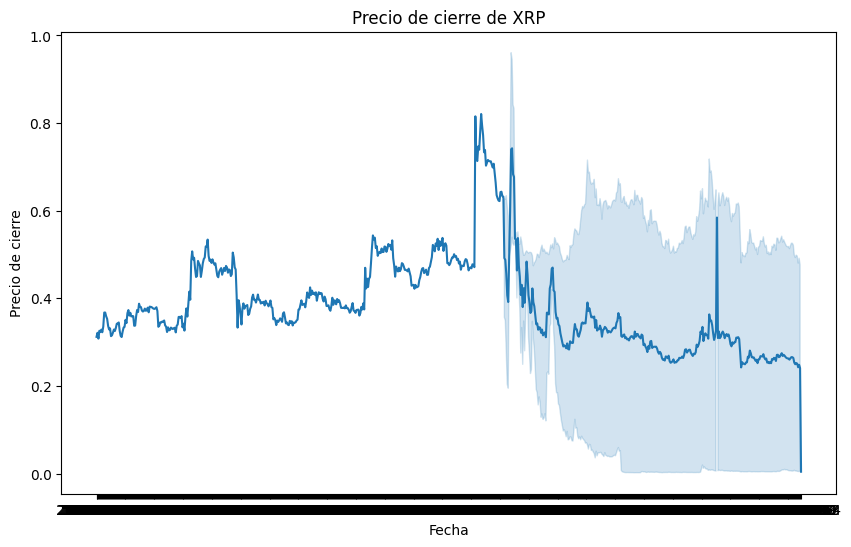

In [44]:
#@title Distribución de los precios de cierre de una criptomoneda
c = cryptoList[6]
dfCrypto = dfGrafic[dfGrafic["symbol"]==c].copy()
plt.figure(figsize=(10,6))
sns.lineplot(x=dfCrypto['date'],y=dfCrypto['close'])
plt.title(f'Precio de cierre de {c}')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.show()

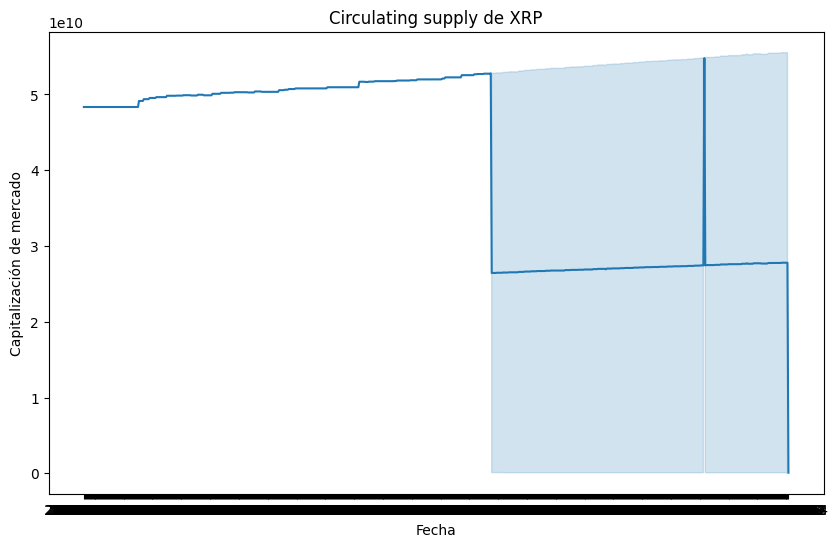

In [45]:
#@title Distribución de la capitalización del supply de una criptomoneda
c = cryptoList[6]
dfCrypto = dfGrafic[dfGrafic["symbol"]==c].copy()
plt.figure(figsize=(10,6))
sns.lineplot(x=dfCrypto['date'],y=dfCrypto['circulating_supply'])
plt.title(f'Circulating supply de {c}')
plt.xlabel('Fecha')
plt.ylabel('Capitalización de mercado')
plt.show()

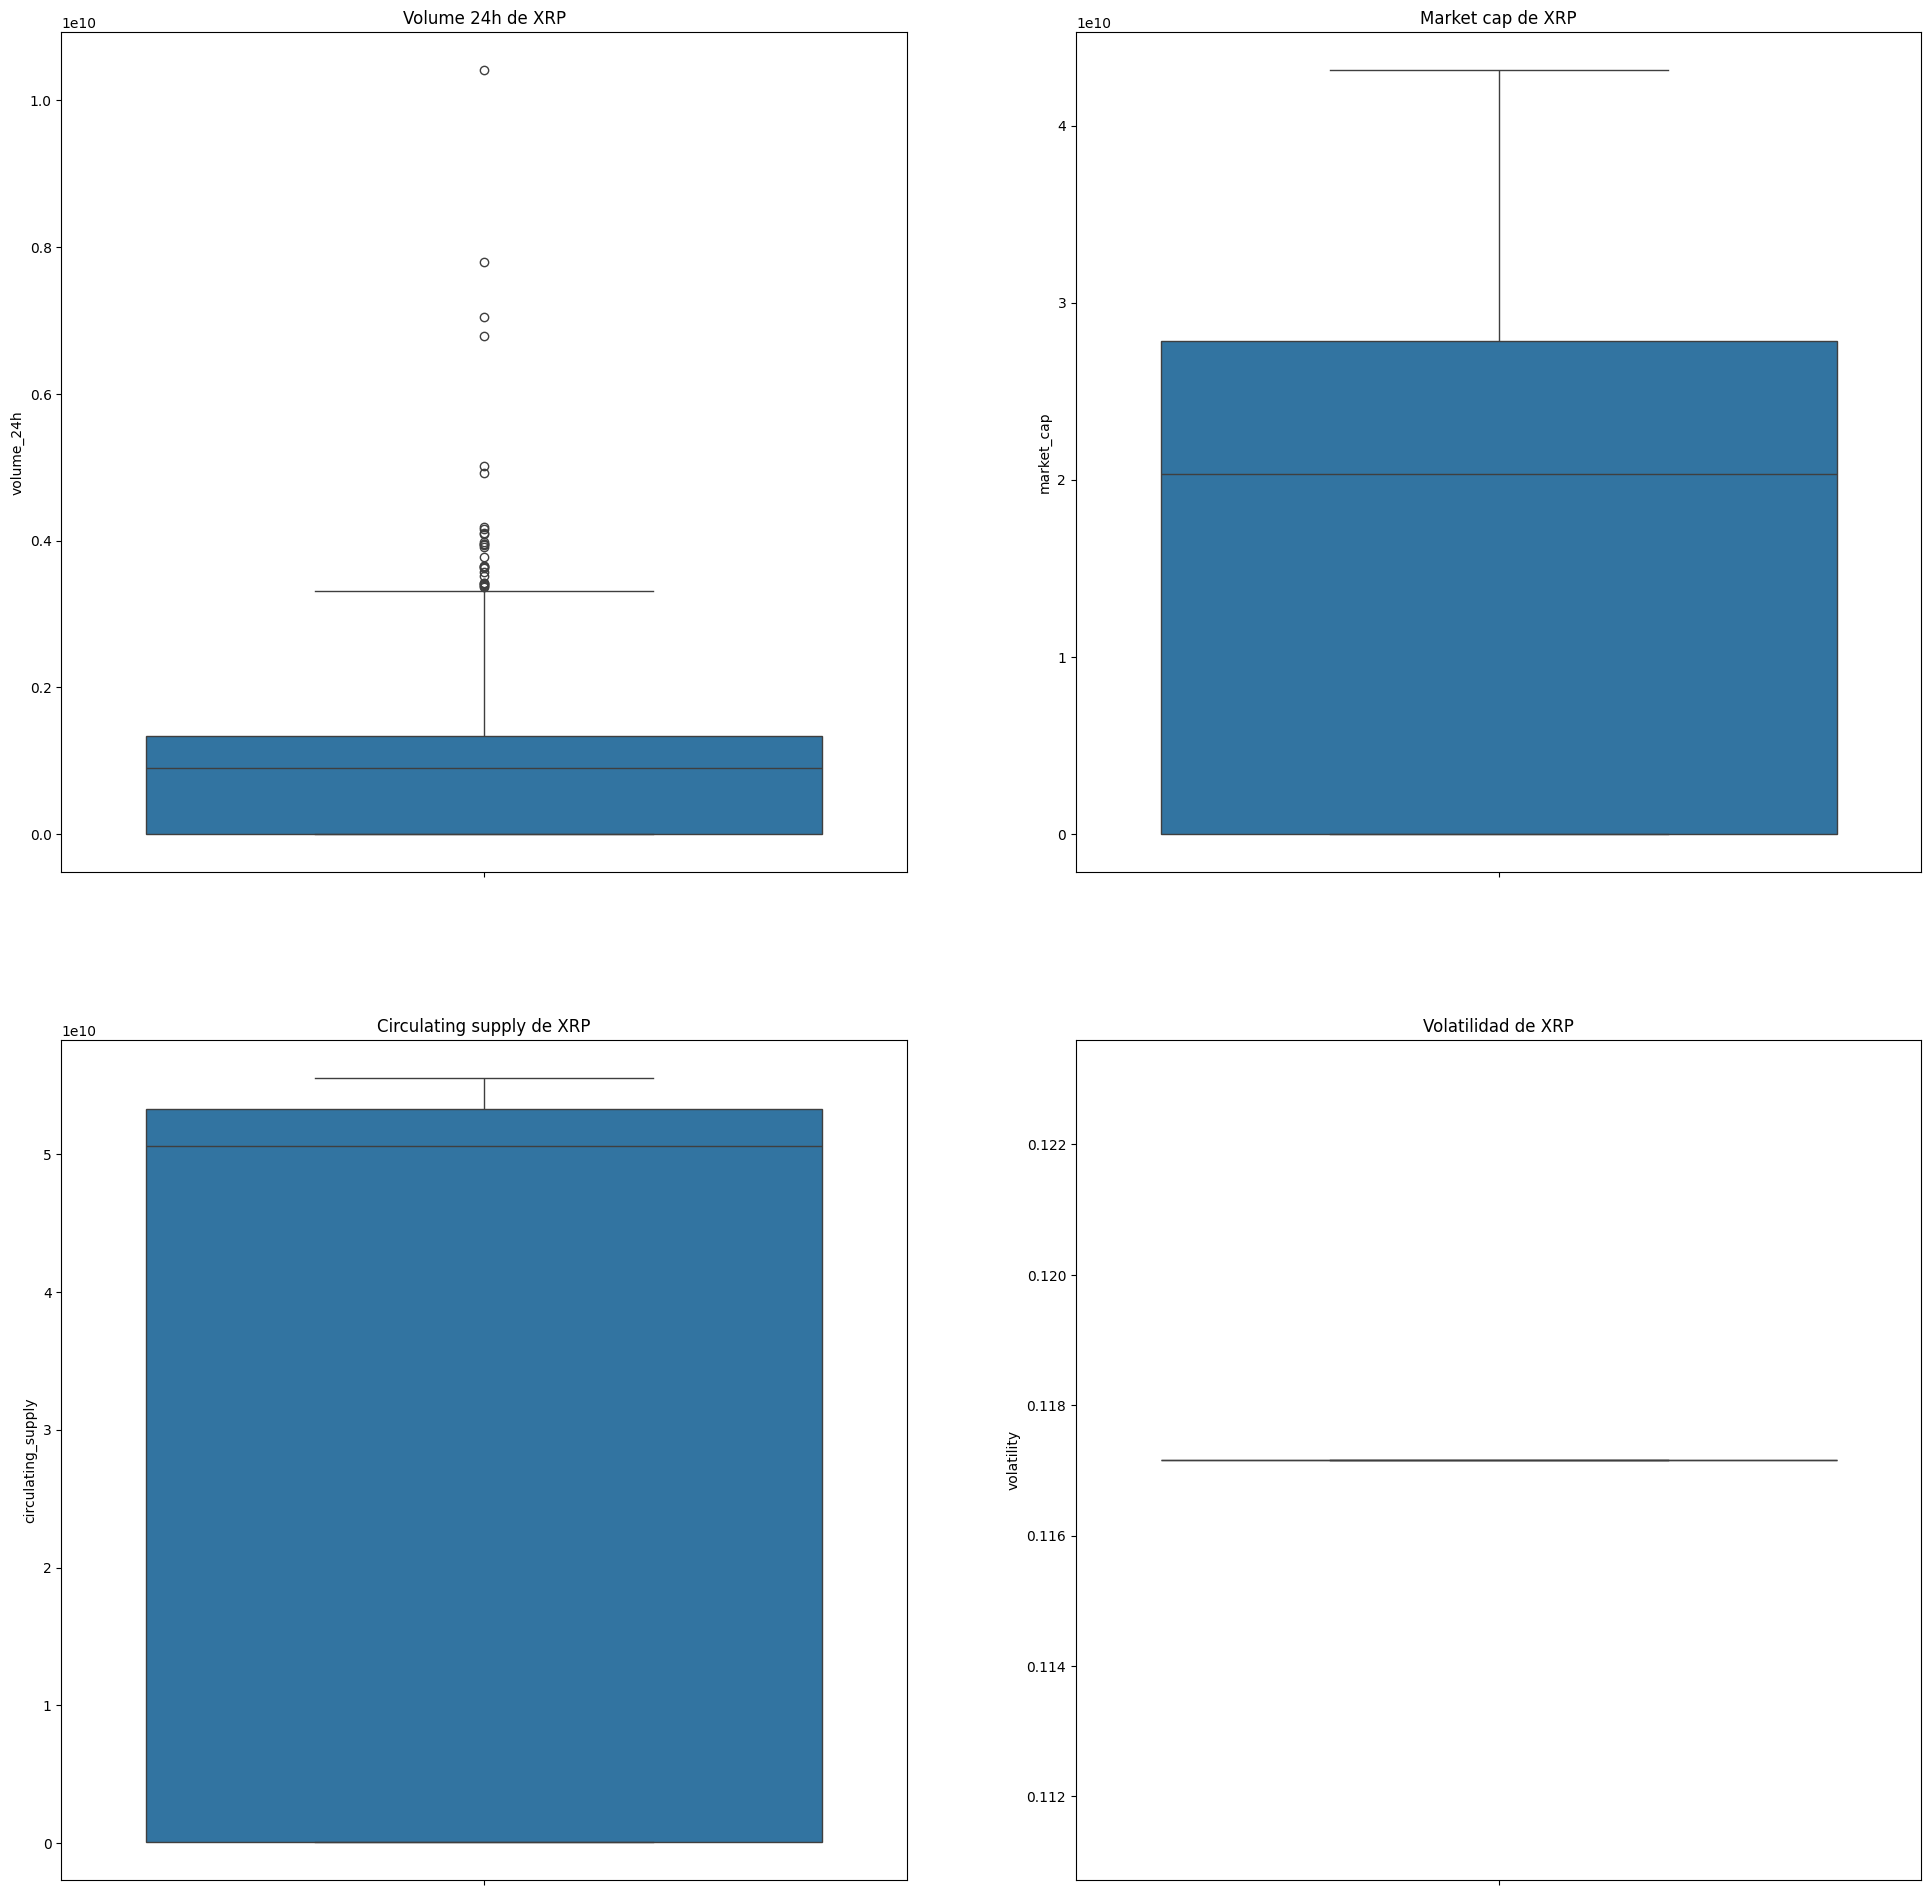

In [46]:
#@title Boxplots de una criptomoneda
c = cryptoList[6]
dfCrypto = dfGrafic[dfGrafic["symbol"] == c].copy()

fig, ax = plt.subplots(2,2,figsize=(24, 24))
sns.boxplot(y=dfCrypto['volume_24h'],ax=ax[0,0])
ax[0,0].set_title(f'Volume 24h de {c}')
sns.boxplot(y=dfCrypto['market_cap'],ax=ax[0,1])
ax[0,1].set_title(f'Market cap de {c}')
sns.boxplot(y=dfCrypto['circulating_supply'],ax=ax[1,0])
ax[1,0].set_title(f'Circulating supply de {c}')
sns.boxplot(y=dfCrypto['volatility'],ax=ax[1,1])
ax[1,1].set_title(f'Volatilidad de {c}')
plt.show()


#### Graficas grupales

C:\Users\eduar\AppData\Local\Temp\ipykernel_29264\774603532.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='symbol',y='market_cap',data=top10_df,palette='viridis',


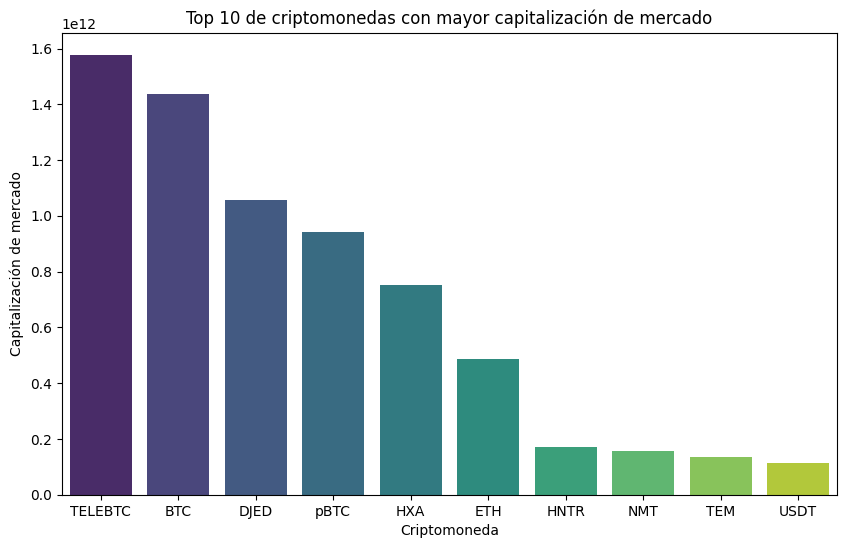

In [61]:
#@title Distribución del top 10 de criptomonedas con mayor capitalización de mercado

# Agrupar por 'symbol', calcular el máximo 'market_cap' para cada grupo, y resetear el índice
top10_df = dfGrafic.groupby('symbol')['market_cap'].max().reset_index()
# Ordenar los resultados por 'market_cap' de forma descendente y seleccionar los primeros 10
top10_df = top10_df.sort_values(by='market_cap', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='symbol',y='market_cap',data=top10_df,palette='viridis',
            order=top10_df.groupby('symbol')['market_cap'].max().sort_values(ascending=False).index)
plt.title('Top 10 de criptomonedas con mayor capitalización de mercado')
plt.xlabel('Criptomoneda')
plt.ylabel('Capitalización de mercado')
plt.show()

C:\Users\eduar\AppData\Local\Temp\ipykernel_29264\3113119325.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='symbol',y='volatility',data=top10_df,palette='viridis',


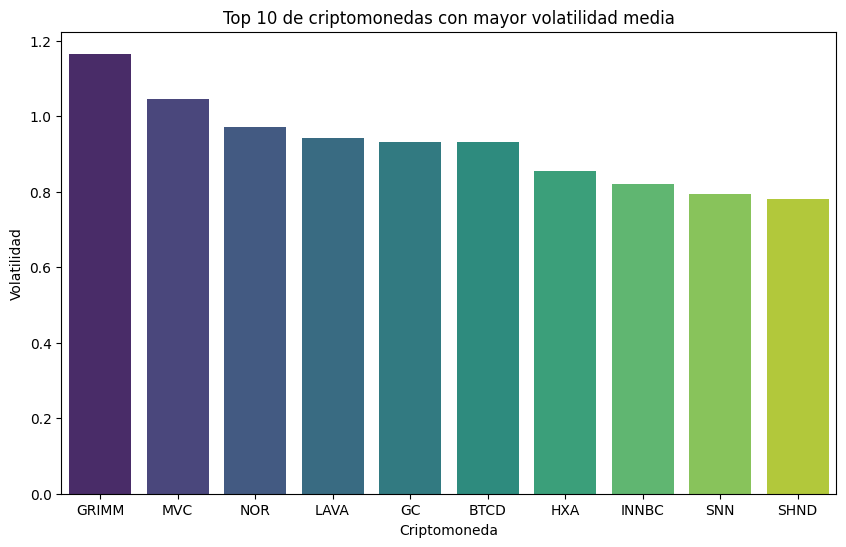

In [62]:
# Agrupar por 'symbol', calcular el promedio 'volatility' para cada grupo, y resetear el índice
top10_df = dfGrafic.groupby('symbol')['volatility'].mean().reset_index()
# Ordenar los resultados por 'volatility' de forma descendente y seleccionar los primeros 10
top10_df = top10_df.sort_values(by='volatility', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='symbol',y='volatility',data=top10_df,palette='viridis',
            order=top10_df.groupby('symbol')['volatility'].max().sort_values(ascending=False).index)
plt.title('Top 10 de criptomonedas con mayor volatilidad media')
plt.xlabel('Criptomoneda')
plt.ylabel('Volatilidad')
plt.show()

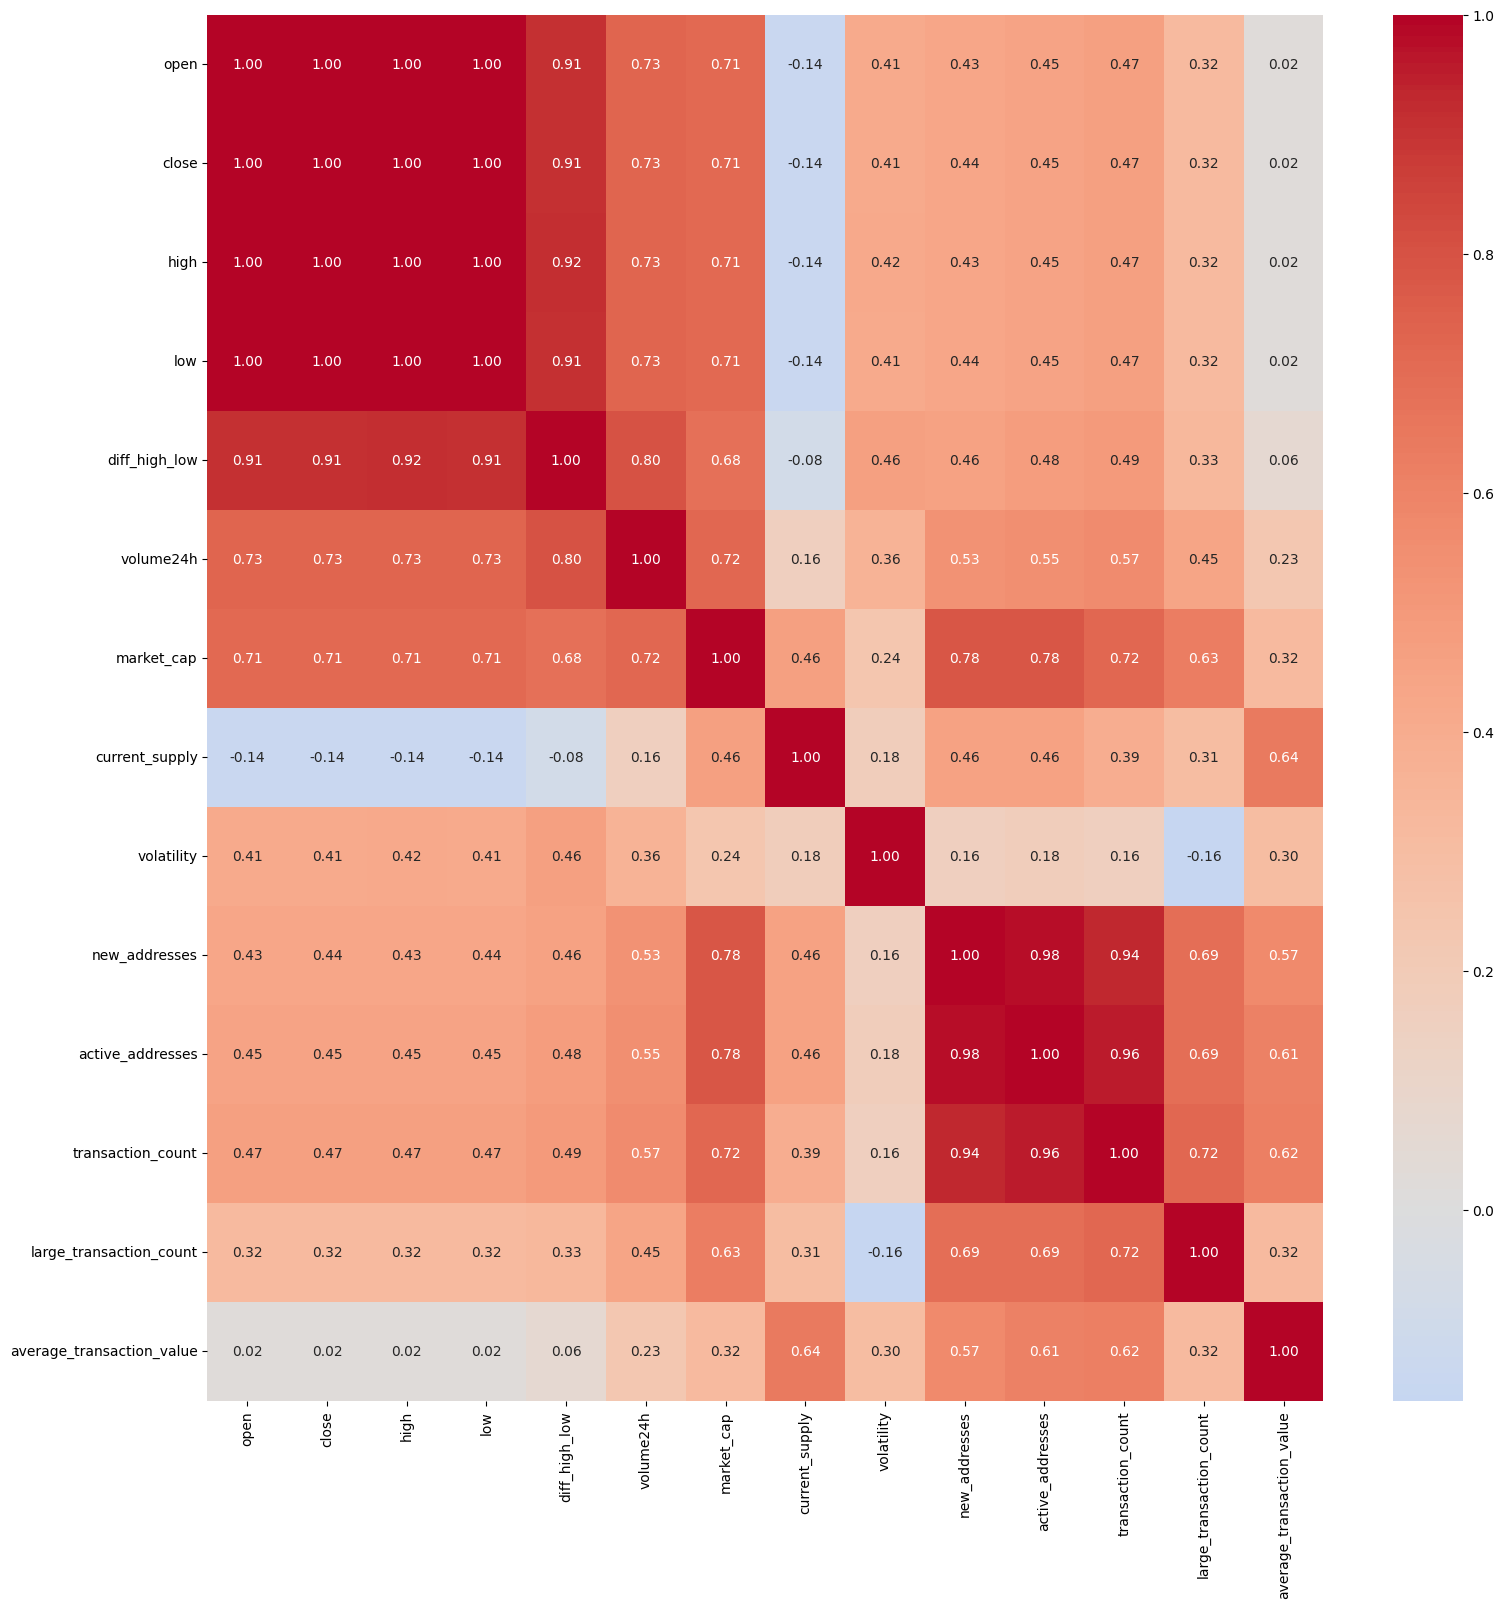

In [530]:
#@title heatmap de correlacion
plt.figure(figsize=(18, 18))
lnum = dfGrafic.select_dtypes(include=np.number).columns.tolist()
df_num=dfGrafic[lnum].copy()
#Escalamos los datos
scaler = StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns)

sns.heatmap(df_num.corr(method = 'spearman'), annot = True, fmt = '.2f', cmap = 'coolwarm', center = 0)
plt.show()

### Modelado
Para el desarrollo de este trabajo se propone utilizar técnicas de clustering para explorar patrones y estructuras dentro de los datos historicos de las criptomonedas y un modelo de detección de anomalías para predecir dichos clusters con monedas más actuales

#### CLUSTERING

Objetivos:

- Seleccionar un algoritmo de clustering adecuado, como K-Means o MEAN SHIFT, según las características de los datos historicos.
- Determinar el número óptimo de clústeres utilizando técnicas como el método del codo o el coeficiente de silueta.
- Aplicar el algoritmo de clustering seleccionado a los datos y asignar cada observación a un clúster..

In [44]:
#Creamos un cluster donde sintetizamos los datos historicos de las criptomonedas
df_model = pd.read_csv('ccHistorical_all(3th halving)(Clean).csv')
df_model['log_return'] = np.log(df_model['close'] / df_model['open'])
cryptoList = df_model['symbol'].unique().tolist()
dfCluster = pd.DataFrame()
for c in cryptoList:
    dictCrypto = {}
    dfSymbols = df_model[df_model["symbol"] == c].copy()
    lenSymbols = len(dfSymbols)
    dictCrypto["symbol"] = c
    avg_volatility_daily = dfSymbols['log_return'].std()
    dictCrypto["total_volatility"] = avg_volatility_daily*np.sqrt(lenSymbols)
    dictCrypto["price_variation_multiplier"] = (dfSymbols["close"].max() - dfSymbols["close"].iloc[0])/dfSymbols["close"].iloc[0]
    dictCrypto["avg_daily_market_cap"] =  dfSymbols["market_cap"].mean()
    dfCrypto = pd.DataFrame(dictCrypto,index=[0])
    dfCluster = pd.concat([dfCluster,dfCrypto],axis=0)
dfCluster.reset_index(drop=True,inplace=True)

In [45]:
#Hallamos outliers de la variación de precios para no perjudicar el modelo
df_non_zero = dfCluster[dfCluster['price_variation_multiplier'] != 0]
Q1 = df_non_zero['price_variation_multiplier'].quantile(0.25)
Q3 = df_non_zero['price_variation_multiplier'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

#obtenemos las listas de criptos consideradas outliers
outliers = df_non_zero[(df_non_zero['price_variation_multiplier'] < lower_bound) | (df_non_zero['price_variation_multiplier'] > upper_bound)]["symbol"].to_list()
#Mantenemos aquellos outliers que su variación de precios no sea mayor a x50
outliers = dfCluster[dfCluster["symbol"].isin(outliers) & (dfCluster["price_variation_multiplier"] > 50)]["symbol"].to_list()
print(f"El número de outliers es: {len(outliers)}")
print(f"Los outliers son: {outliers}")
dfCluster[dfCluster["symbol"].isin(outliers)]
dfCluster = dfCluster[~dfCluster["symbol"].isin(outliers)]
dfCluster.sort_values(by='price_variation_multiplier',ascending=False)

#Tambien excluimos aquellas monedas que presentan un 0 en total_volatility
dfCluster = dfCluster[dfCluster["price_variation_multiplier"] != 0]

El número de outliers es: 7
Los outliers son: ['AUC', 'AVT', 'BFT', 'COSM', 'IDEX', 'IQN', 'PNT']


<Axes: xlabel='price_variation_multiplier'>

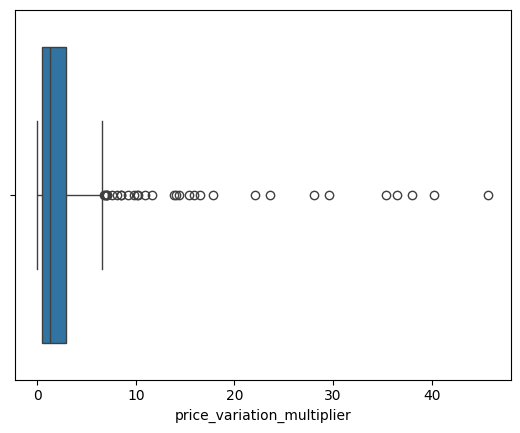

In [46]:
sns.boxplot(x=dfCluster['price_variation_multiplier'])

In [47]:
stat, p_value = shapiro(dfCluster["price_variation_multiplier"])
print(f"Estadístico de prueba: {stat}")
print(f"P-value: {p_value}")

Estadístico de prueba: 0.49506843090057373
P-value: 4.345968155289101e-26


**Debido a que la distribución de nuestros datos no sigue una distribución normal, optamos por el uso de MinMaxScaler**

##### KNN

In [48]:
#Escalamos los datos
numData = dfCluster.select_dtypes(include=np.number)
scaler = MinMaxScaler()
numData_scaled = scaler.fit_transform(numData)

ssd = []
silhouette_scores = []

# Entrena KMeans con diferentes valores de k
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numData_scaled)
    ssd.append(kmeans.inertia_)
    if k > 1:
        silhouette_avg = silhouette_score(numData_scaled, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

# Obtener los valores de k, ssd y silueta en un DataFrame
dfCodo = pd.DataFrame({'k': range(1, 20), 'ssd': ssd})
dfS = pd.DataFrame({'k': range(2, 20), 'silhouette_score': silhouette_scores})

# encuentra la k con la puntuación de silueta más alta
best_k = np.argmax(silhouette_scores) + 2


**ANÁLISIS MÉTODO DEL CODO**

A partir del gráfico del codo, podemos observar el SSD disminuye significativamente de k=1 a k=4, y después de k=5 la reducción es menos pronunciada. Esto sugiere que el número óptimo de clusters podría ser entre 4 y 5. No obstante, para una mejor comprensión aplicaremos el método de la silueta.

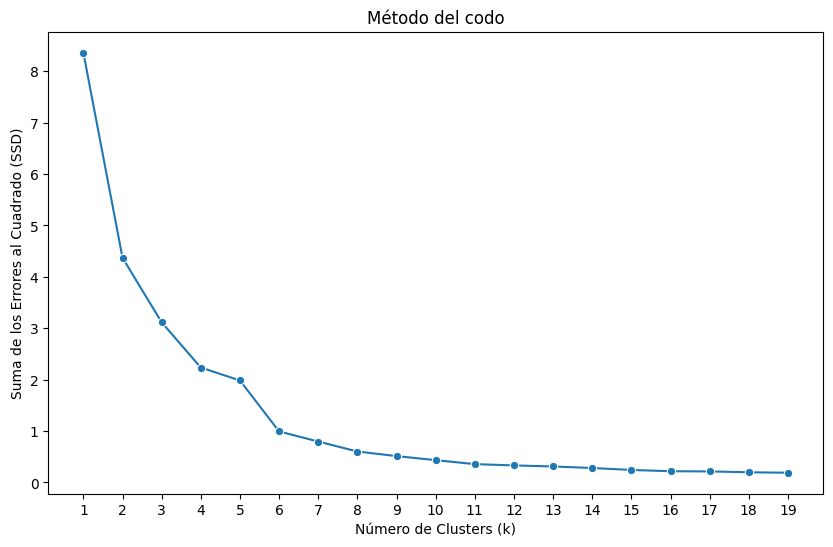

In [49]:
# Crear el diagrama de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(x='k', y='ssd', data=dfCodo, marker='o')

# Añadir título y etiquetas
plt.title('Método del codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de los Errores al Cuadrado (SSD)')
plt.xticks(range(1, 20))

# Mostrar el gráfico
plt.show()

**ANÁLISIS MÉTODO DE LA SILUETA**

A partir del gráfico de la silueta, se observa que k=2 tiene la puntuación de la silueta más alta, lo que lo vuelve un fuerte candidato para el número óptimo de clusters. Sin embargo, si se busca un balance entre la cantidad de clusters y la calidad, k=3 o k=4 también son opciones razonables. Debido a que buscamos una buena diferenciación entre clusters, pero tambien buscamos una cantidad prudente de estos, la elección de la cantidad clusters sera 4, pues mantiene un balance razonable entre el silhouette_score y el SDD

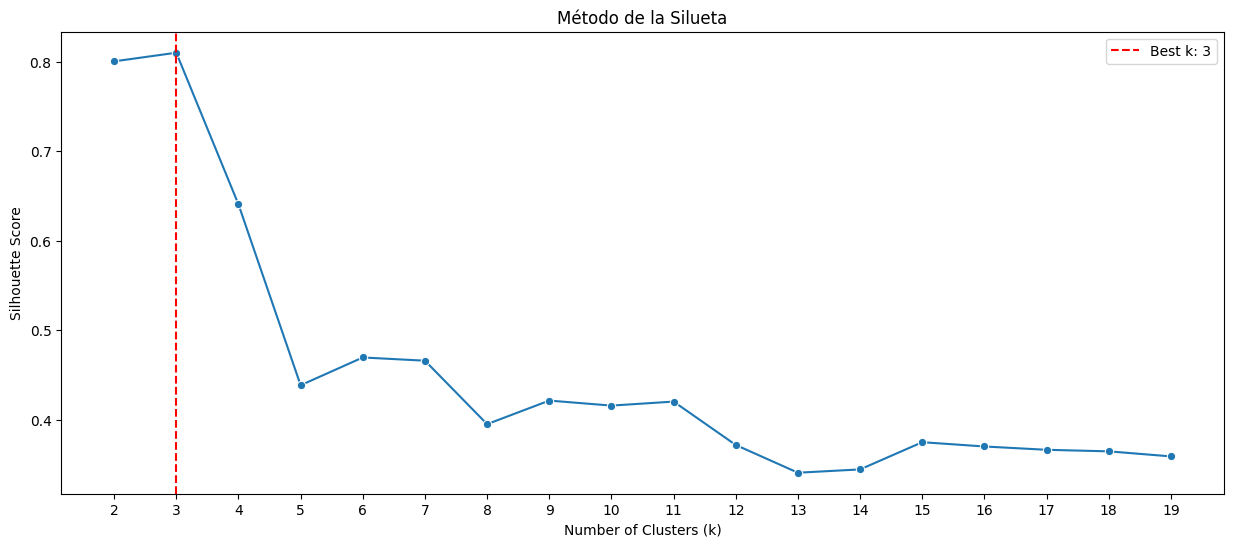

In [50]:
# Crear el gráfico de líneas
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x='k', y='silhouette_score', data=dfS, marker='o')

# Añadir título y etiquetas
ax.set_title('Método de la Silueta')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(range(2, 20))

# Añadir la línea vertical para el mejor k
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k: {best_k}')
plt.legend()

# Mostrar el gráfico
plt.show()

In [51]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)

# Ajustar el modelo KMeans en train_ds
kmeans.fit(numData_scaled)

# Obtener etiquetas de conglomerados y centroides
labelsKM = kmeans.labels_
centroids = kmeans.cluster_centers_

#Obtenemos el indice de la silueta
silhouette_avg_KM = silhouette_score(numData_scaled, labelsKM)

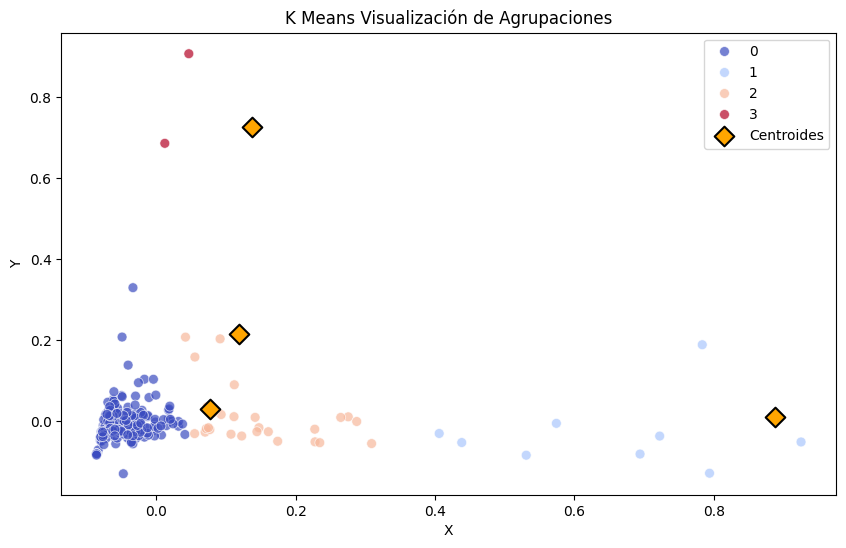

In [52]:
#Utilizamos PCA para reducir la dimensionalidad de los datos
pca = PCA(n_components=2)
data_2D = pca.fit_transform(numData_scaled)
# Crea el diagrama de dispersión 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_2D[:, 0], y=data_2D[:, 1],
    hue=labelsKM, palette='coolwarm',
    size=labelsKM, sizes=(50,50), legend='brief', alpha=0.7
)

# Agrega un seguimiento para los centros de clúster
plt.scatter(
    x=centroids[:, 0],
    y=centroids[:, 1],
    s=100, c='orange', marker='D', edgecolor='black', linewidth=1.5,
    label='Centroides'
)

# Añade etiquetas y título
plt.xlabel('X')
plt.ylabel('Y')
plt.title('K Means Visualización de Agrupaciones')

# Muestra la leyenda
plt.legend()

# Muestra el gráfico
plt.show()

##### MEAN SHIFT

In [29]:
# Escalado de datos
numData = dfCluster.select_dtypes(include=np.number)
scaler = StandardScaler()
numData_scaled = scaler.fit_transform(numData)

bandwidths = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] 
silhouette_scores = [] 

for bandwidth in bandwidths:
    meanshift = MeanShift(bandwidth=bandwidth,n_jobs=-1)
    meanshift.fit(numData_scaled)
    silhouette_avg = silhouette_score(numData_scaled, meanshift.labels_)
    silhouette_scores.append(silhouette_avg)

# Crear DataFrame para almacenar resultados de la silueta
dfS = pd.DataFrame({'bandwidth': bandwidths, 'silhouette_score': silhouette_scores})
# Encontrar el mejor ancho de banda con la puntuación de silueta más alta
best_bandwidth = bandwidths[np.argmax(silhouette_scores)]

**ANÁLISIS MÉTODO DE LA SILUETA**

Basándonos en la puntuación de la silueta, podríamos considerar valores alrededor de 2.5 o 3.0 como candidatos para el ancho de banda óptimo, ya que producen las puntuaciones de silueta más altas, lo que sugiere que estos valores pueden ser más óptimos en términos de separación y cohesión de los clústeres..

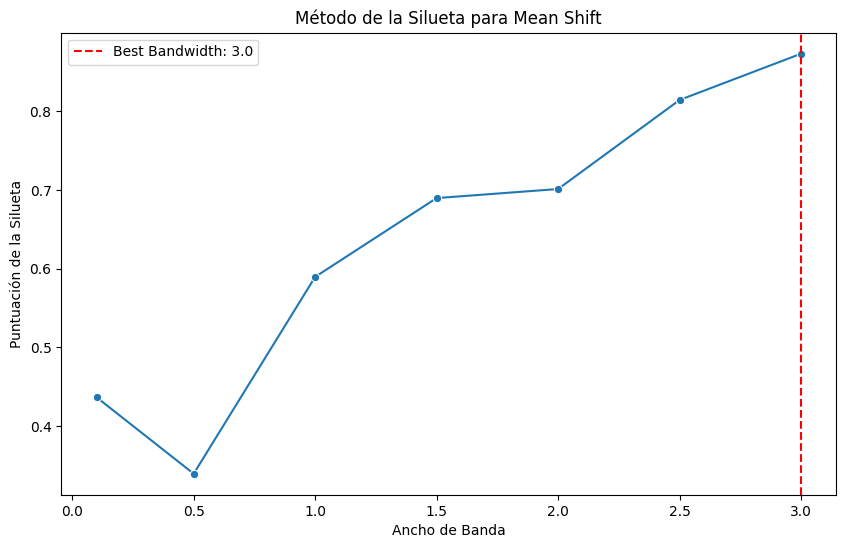

In [432]:
# Visualizar resultados de la silueta
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='bandwidth', y='silhouette_score', data=dfS, marker='o')

# Añadir título y etiquetas
ax.set_title('Método de la Silueta para Mean Shift')
ax.set_xlabel('Ancho de Banda')
ax.set_ylabel('Puntuación de la Silueta')


# Añadir línea vertical para el mejor ancho de banda
plt.axvline(x=best_bandwidth, color='red', linestyle='--', label=f'Best Bandwidth: {best_bandwidth}')
plt.legend()

# Mostrar el gráfico
plt.show()

In [30]:
# Mean Shift Clustering con el mejor ancho de banda
meanshift = MeanShift(bandwidth=best_bandwidth)
meanshift.fit(numData_scaled)

# Obtener etiquetas de clústeres y centroides (modas)
labelsMS = meanshift.labels_
cluster_centers = meanshift.cluster_centers_

#Obtenemos el indice de la silueta
silhouette_avg_MS = silhouette_score(numData_scaled, labelsMS)

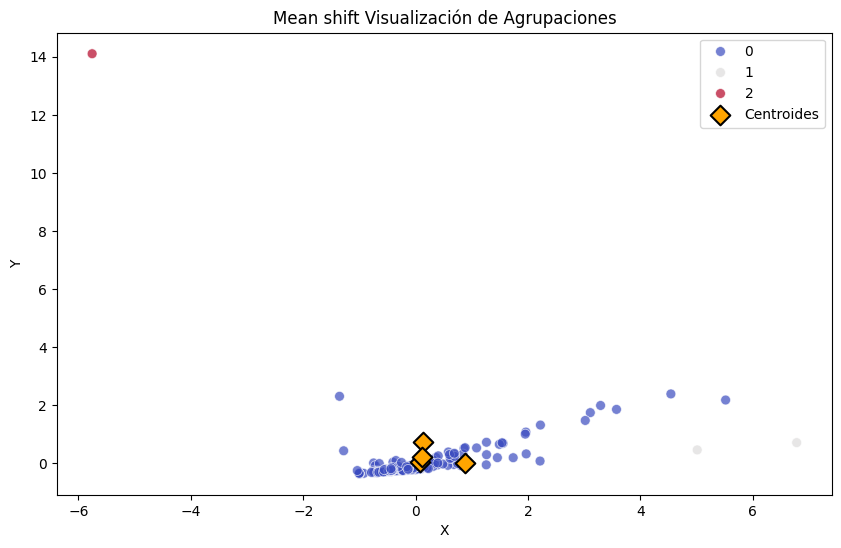

In [31]:
#Utilizamos PCA para reducir la dimensionalidad de los datos
pca = PCA(n_components=2)
data_2D = pca.fit_transform(numData_scaled)
# Crea el diagrama de dispersión 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_2D[:, 0], y=data_2D[:, 1],
    hue=labelsMS, palette='coolwarm',
    size=labelsMS, sizes=(50,50), legend='brief', alpha=0.7
)

# Agrega un seguimiento para los centros de clúster
plt.scatter(
    x=centroids[:, 0],
    y=centroids[:, 1],
    s=100, c='orange', marker='D', edgecolor='black', linewidth=1.5,
    label='Centroides'
)

# Añade etiquetas y título
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mean shift Visualización de Agrupaciones')

# Muestra la leyenda
plt.legend()

# Muestra el gráfico
plt.show()

##### Comparación

In [53]:
#Comparación de los indices de silueta
print(f"Silueta KMeans: {silhouette_avg_KM}")
print(f"Silueta Mean Shift: {silhouette_avg_MS}")


Silueta KMeans: 0.640760409777578
Silueta Mean Shift: 0.8748861861357756


In [54]:
#Asignamos las etiquetas a los datos
dfCluster['labelsKM'] = labelsKM
dfCluster['labelsMS'] = labelsMS

In [55]:
dfCluster['labelsMS'].value_counts()

labelsMS
0    246
1      2
2      1
Name: count, dtype: int64

In [56]:
dfCluster['labelsKM'].value_counts()

labelsKM
0    211
2     27
1      9
3      2
Name: count, dtype: int64

**EVALUACIÓN DEL USO DE CLUSTERING**

Al comparar los resultado obtenidos entre KNN y Mean Shift para el clustering de los datos, se observa que el algoritmo de Mean Shift obtuvo una mejor puntuación en el índice de la silueta; sin embargo, el algoritmo de KNN obtuvo un mejor resultado en su clusterización, pues los 4 clusters generados por este cuenta con caracteristicas más diferenciadas entre si.

In [57]:
#Eliminamos la columna de los labels generados por mean shift
dfCluster.drop(columns=['labelsMS'],inplace=True)

In [ ]:
grouped_stats = dfCluster.groupby('labelsKM').describe()
#Seleccionamos las columnas que nos interesan de volatilidad y precio (media, max y min)
grouped_stats = grouped_stats['price_variation_multiplier'][['mean','max','min']]
# agregamos un count
grouped_stats = grouped_stats.join(dfCluster.groupby('labelsKM')['price_variation_multiplier'].count())
grouped_stats = grouped_stats.join(dfCluster.groupby('labelsKM')['total_volatility'].mean())
#grouped_stats = grouped_stats.join(dfCluster.groupby('labelsKM')['avg_daily_volume'].mean())
grouped_stats = grouped_stats.join(dfCluster.groupby('labelsKM')['avg_daily_market_cap'].mean())
grouped_stats = grouped_stats.join(dfCluster.groupby('labelsKM')['avg_daily_market_cap'].max(),rsuffix="max")
grouped_stats = grouped_stats.join(dfCluster.groupby('labelsKM')['avg_daily_market_cap'].min(),rsuffix="min")
grouped_stats.rename(columns={'total_volatility':'avg_volatility',
                              'avg_daily_market_cap':'avg_market_cap',
                              'price_variation_multiplier':'count',
                              'mean':'avg_price_variation',
                              'max':'max_price_variation',
                              'min':'min_price_variation',
                              'avg_daily_market_capmax':'max_market_cap',
                              'avg_daily_market_capmin':'min_market_cap'},inplace=True)
grouped_stats

A partir de ello podemos notar que nuestras 4 clases se encuentran bien diferenciadas y poseen las siguientes caracteristicas:

- Label 0: Moneda de bajo riego/  ganancia a largo plazo
    - Cuenta con una capitalización variada, entre alta y baja
    - Menor volatilidad
    - Suelen tener ganancias a un largo plazo, de crecimiento continuo pero lento
- Label 1: Moneda de riesgo moderado/ alta ganancia
    - La mayoría cuenta con una baja capitalización  (Menos 2 mil millones)
    - Volatilidad moderada
    - Gran probabilidad de obtener ganancias muy altas
    - Es un tipo de criptomoneda inusual
- Label 2: Moneda de alto riesgo/ ganancia media
    - Cuentan con una baja capitalizacion (Menos 2 mil millones)
    - Volatilidad alta
    - Incertidumbre al momento de conocer sus ganancias
    - Es un tipo de criptomoneda poco común
- Label 3: Moneda de riesgo alto/ baja ganancia
    - Todas cuentan con una baja capitalización  (Menos 2 mil millones)
    - Volatilidad muy alta
    - Alta probabilidad de obtener perdidas y/o ganancias
    - Es un tipo de criptomoneda bastante inusual


#### MODELO DE CLASIFICACIÓN 

Objetivos
- Selección de los modelos a aplicar, asi como ajuste de hiperparametros.
- Evaluar la precisión y la capacidad de clasificación de los modelos utilizando métricas como precisión, recall y F1-score en un conjunto de datos de prueba.
- Seleccionar el modelo con mejor rendimiento

In [677]:
dfCluster=pd.read_csv('Clustered_Cryptos.csv')

In [678]:
#@title asignamos nombres a los clusters
dfCluster['type'] = dfCluster['type'].map({"Conservadora":'Estable',"Gran oportunidad":'Oportunidad',"Especulativa":'Especulativa',"Volatil":'Volatil'})
dfCluster.rename(columns={'type':'type'},inplace=True)

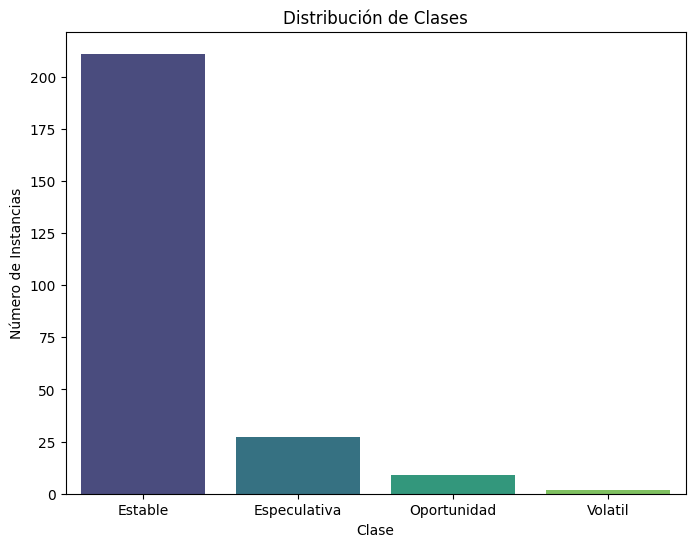

In [679]:
#@title Observamos la distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=dfCluster,hue='type',palette='viridis',order=dfCluster['type'].value_counts().index)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Número de Instancias')
plt.show()

In [680]:
#Distribución porcentual de las criptomonedas en los clusters
dfCluster['type'].value_counts(normalize=True)*100

type
Estable         84.738956
Especulativa    10.843373
Oportunidad      3.614458
Volatil          0.803213
Name: proportion, dtype: float64

In [681]:
#Guardamos nuestro df de clusterización
dfCluster.to_csv("Clustered_Cryptos.csv",index=False)

In [751]:
#Seleccionamos las monedas desde 2 meses antes y despues a el 03/05/2020 (3re halving)
df_helper = pd.read_csv('Clustered_Cryptos.csv')
df_model = pd.read_csv('ccHistorical_all(3th halving)(Clean).csv')
df_model['date'] = pd.to_datetime(df_model['date'])
baseDate = datetime(2020, 5, 3)
startDate = baseDate - timedelta(days=60)
endDate = baseDate + timedelta(days=60)
df_model = df_model[(df_model['date'] >= startDate) & (df_model['date'] <= endDate)]
cryptoList = df_helper['symbol'].unique().tolist()
for c in cryptoList:
    symbol_data = df_model[df_model['symbol'] == c]
    df_model.loc[df_model['symbol'] == c, 'cum_max'] = symbol_data['close'].cummax()
    symbol_data = df_model[df_model['symbol'] == c]
    df_model.loc[df_model['symbol'] == c, 'drawdown'] = symbol_data['close'] / symbol_data['cum_max'] - 1
df_model["log_return"] = np.log(df_model['close'] / df_model['open'])
dfClas = pd.DataFrame()

for c in cryptoList:
    dictCrypto = {}
    dfSymbols = df_model[df_model["symbol"] == c].copy()
    lenSymbols = len(dfSymbols)
    dictCrypto["symbol"] = c
    avg_volatility_daily = dfSymbols['log_return'].std()
    dictCrypto["total_volatility"] = avg_volatility_daily*np.sqrt(lenSymbols)
    #dictCrypto["price_variation_multiplier"] = (dfSymbols["close"].max() - dfSymbols["close"].iloc[0])/dfSymbols["close"].iloc[0]
    dictCrypto["avg_daily_market_cap"] =  dfSymbols["market_cap"].mean()
    dictCrypto["max_drawdown"] = dfSymbols["drawdown"].min()
    dictCrypto["avg_volume_24h"] = dfSymbols["volume_24h"].mean()
    dictCrypto["type"] = df_helper[df_helper["symbol"] == c]["type"].values[0]
    dfCrypto = pd.DataFrame(dictCrypto,index=[0])
    dfClas = pd.concat([dfClas,dfCrypto],axis=0)
dfClas.reset_index(drop=True,inplace=True)

In [752]:
dfClas

,symbol,total_volatility,avg_daily_market_cap,max_drawdown,avg_volume_24h,type
0,ABT,0.858195,9.059667e+06,-0.536084,1.154450e+06,Estable
1,ABYSS,0.600776,1.579687e+06,-0.494536,1.714723e+02,Estable
2,ADA,0.836730,1.364116e+09,-0.551451,1.476437e+06,Estable
3,ADB,1.461466,4.133706e+05,-0.664977,1.333405e+04,Estable
4,ADX,0.954993,6.602162e+06,-0.567734,2.283487e+04,Estable
...,...,...,...,...,...,...
244,ZCN,1.857818,2.984993e+06,-0.707865,2.269836e+03,Estable
245,ZEC,0.717308,4.044657e+08,-0.538519,1.826768e+07,Estable
246,ZIL,1.123849,1.016593e+08,-0.576352,6.594341e+05,Especulativa
247,ZRX,0.813377,1.697474e+08,-0.513028,3.163005e+06,Estable


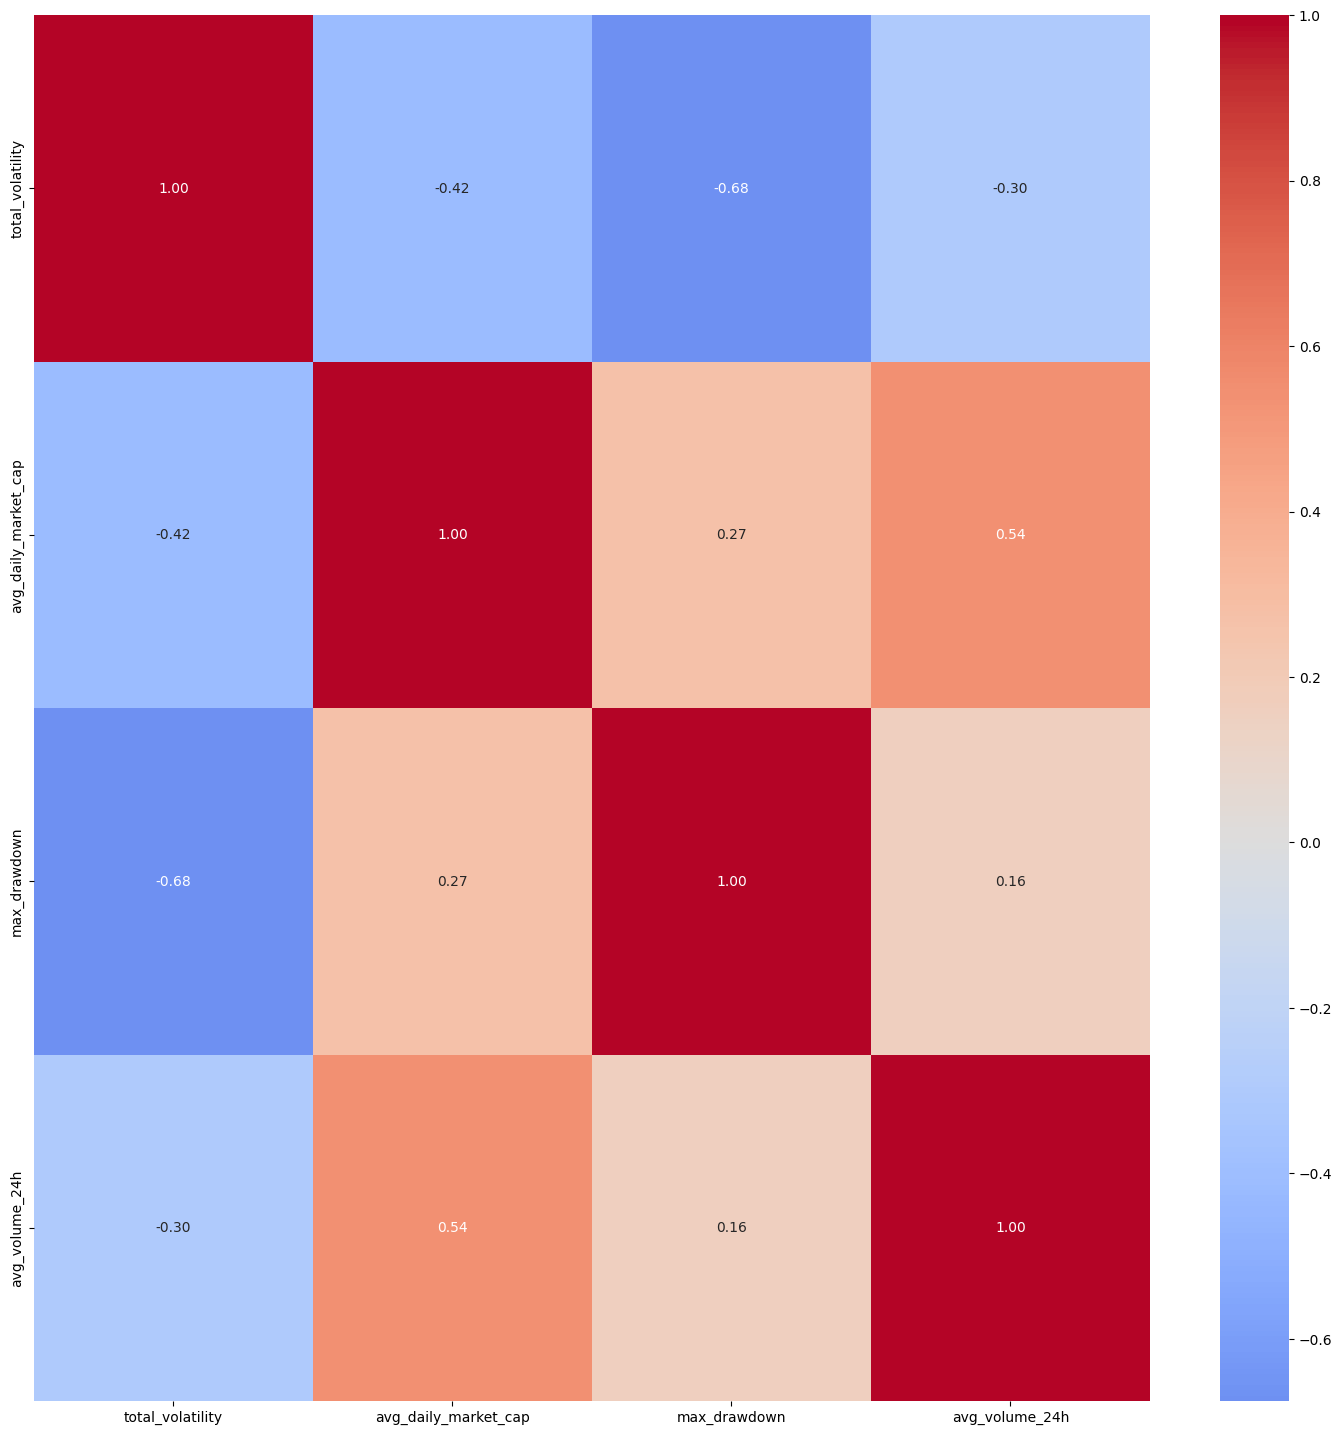

In [753]:
#Realizamos un mapa de calor para ver la correlación entre las variables
plt.figure(figsize=(18, 18))
lnum = dfClas.select_dtypes(include=np.number).columns.tolist()
df_num=dfClas[lnum].copy()
#Escalamos los datos

df_num = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns)

sns.heatmap(df_num.corr(method = 'spearman'), annot = True, fmt = '.2f', cmap = 'coolwarm', center = 0)
plt.show()


Al analizar la distribución de clases, podemos observar que existe un desbalance extremo entre la clases, por ende, se opta por usar la generación de data sintetica.

In [755]:
#Eliminamos las criptomonedas con la clase volatil
dfClas.drop(dfClas[dfClas["type"] == "Volatil"].index,inplace=True)

#Uso de SMOTE para balancear los datos
X = dfClas.drop(columns=['symbol',"type"])
y = dfClas['type']

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
#Usamos SMOTE
smote = SMOTE(random_state=42, k_neighbors=5,sampling_strategy={'Oportunidad':300,'Especulativa': 300,'Estable': 300})
X_smote, y_smote = smote.fit_resample(X_scaled, y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

In [756]:
y_smote.value_counts()

type
Estable         300
Especulativa    300
Oportunidad     300
Name: count, dtype: int64

In [757]:
def evaluation(model, name, X_train, y_train, X_test, y_test):
    model_dict = {}
    model_dict['model_name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['precision_tests'] = precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['recall_tests'] = recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['f1_tests'] = f1_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    return model_dict

def seeScores(models):
    evaluacion = list()
    for key, model in models.items():
        evaluacion.append(evaluation(model=model, name=key,
                                    X_train=X_train, y_train=y_train,
                                    X_test=X_test, y_test=y_test))

    # Pasamos los resultados a un DataFrame para visualizarlos mejor
    dfEvaluation = pd.DataFrame.from_dict(evaluacion)
    dfEvaluation.set_index("model_name", inplace=True)
    return dfEvaluation

def drawScores(df):
    METRICS = ["accuracy", "precision", "recall", "f1"]
    df_plot = df.reset_index().melt(id_vars='model_name').rename(columns=str.title)
    plt.figure(figsize=(32, 14))
    pos = 1
    for metric in METRICS:
        df_aux = df_plot[df_plot['Variable'].str.contains(metric)]

        plt.subplot(2, 2, pos)
        sns.barplot(x='Model_Name', y='Value', hue='Variable', data=df_aux, palette="coolwarm")
        plt.title(metric.upper(),fontweight='bold')
        plt.grid()
        plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.4)
        plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        plt.xticks(rotation=20)
        pos += 1
    plt.show()

In [758]:
#Definimos metricas
metric = "accuracy"
cv_num =  StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
models = dict()

##### RANDOM FOREST

In [759]:
#Seleccion de hiperparametros
param_grid = {
    'n_estimators': [30,40,50,75,100,125],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3,4,5,6,7,9],
    'min_samples_split': [3,4,5],
    'min_samples_leaf': [2, 4,6]
}

In [760]:
#Definimos el modelo

clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=cv_num, n_jobs=-1,verbose=2,scoring=metric)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [30, 40, 50, 75, 100, 125]},
             scoring='accuracy', verbose=2)

In [761]:
#Obtenemos los mejores parametros
for key in grid.best_params_:
    print(f"Mejor parametro {key}: {grid.best_params_[key]}")
print(f"Mejor puntuación: {grid.best_score_}")

#Entrenamos el modelo
clf = grid.best_estimator_
clf.fit(X_train,y_train)

Mejor parametro max_depth: 9
Mejor parametro max_features: sqrt
Mejor parametro min_samples_leaf: 2
Mejor parametro min_samples_split: 5
Mejor parametro n_estimators: 30
Mejor puntuación: 0.838095238095238


RandomForestClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=30, random_state=42)

In [762]:
models["Random Forest Classifier"] = clf
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705


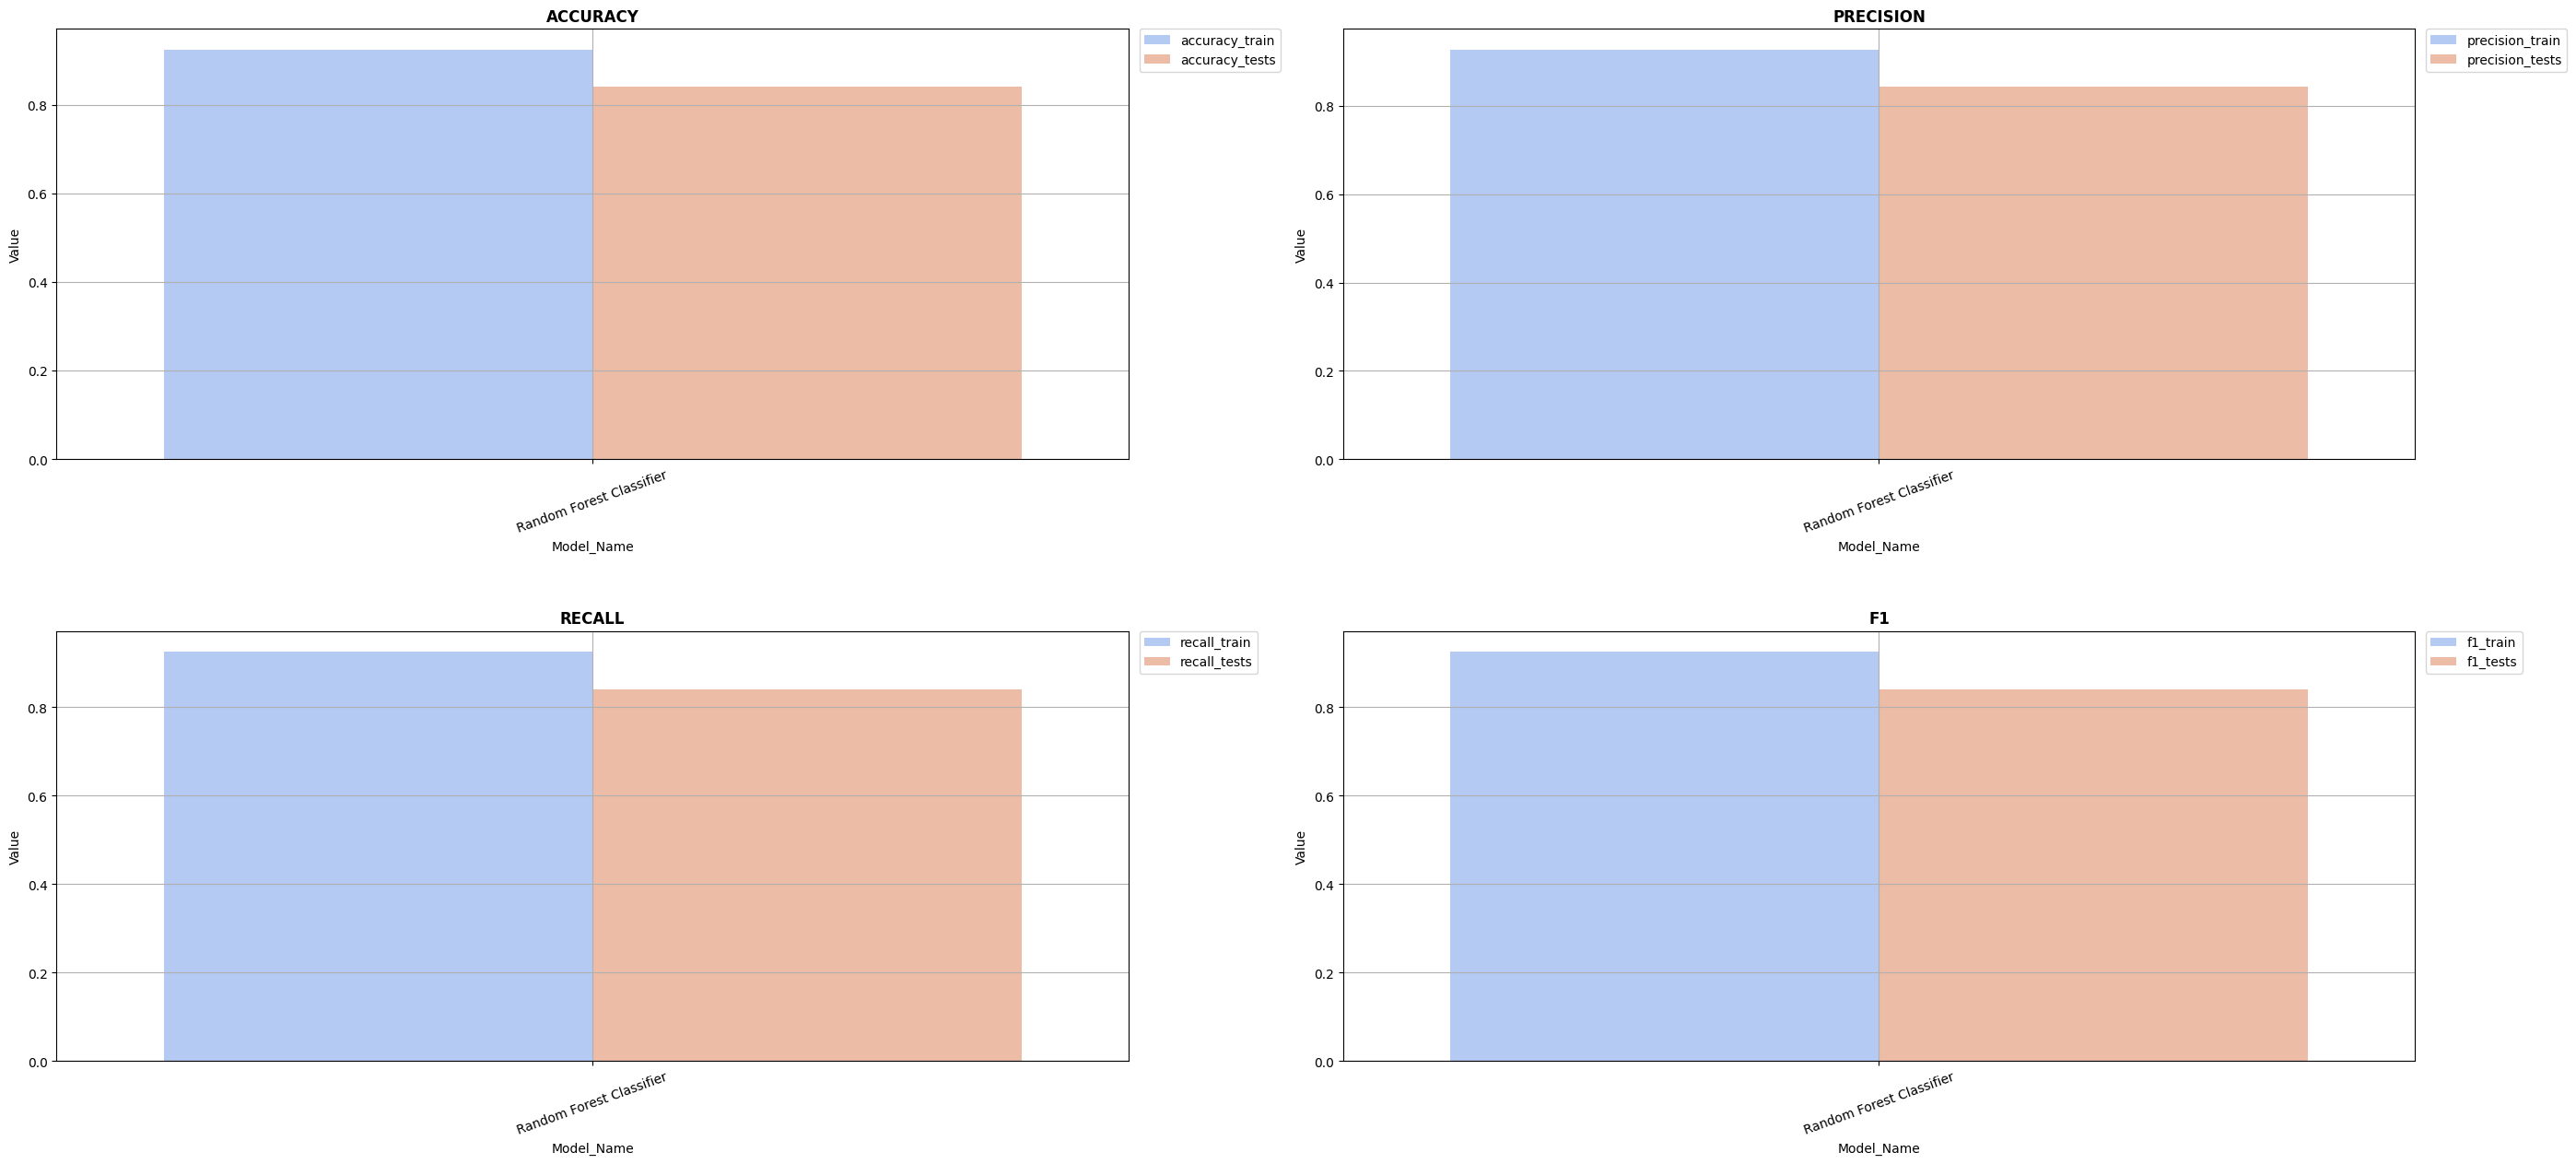

In [763]:
drawScores(scores)

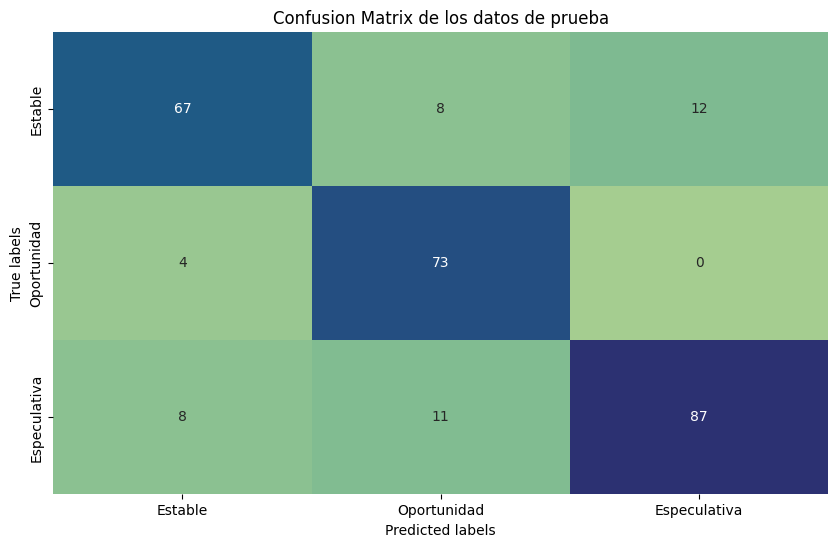

In [764]:
#Matriz de confusión
unique_classes = pd.unique(y_test)
y_pred_test = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test,labels=unique_classes)
plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap="crest",xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix de los datos de prueba')
plt.show()  

##### ADA BOOST CLASSIFIER

In [765]:
param_grid = {
    'n_estimators': [10,25,50,75, 100],  # Número de estimadores base
    'learning_rate': [0.01,0.05,0.03,0.08, 0.1]  # Tasa de aprendizaje
}

In [766]:
#Definimos el modelo
adaBoost = AdaBoostClassifier(random_state=42)
grid = GridSearchCV(adaBoost, param_grid, cv=cv_num, n_jobs=-1,verbose=2,scoring=metric)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.03, 0.08, 0.1],
                         'n_estimators': [10, 25, 50, 75, 100]},
             scoring='accuracy', verbose=2)

In [767]:
#Obtenemos los mejores parametros
for key in grid.best_params_:
    print(f"Mejor parametro {key}: {grid.best_params_[key]}")
print(f"Mejor puntuación: {grid.best_score_}")

#Entrenamos el modelo con los mejores parametros
adaBoost = grid.best_estimator_
adaBoost.fit(X_train,y_train)

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mejor parametro learning_rate: 0.05
Mejor parametro n_estimators: 75
Mejor puntuación: 0.7142857142857142


AdaBoostClassifier(learning_rate=0.05, n_estimators=75, random_state=42)

In [768]:
models["Ada Boost Classifier"] = adaBoost
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705
Ada Boost Classifier,0.749206,0.766667,0.755415,0.769769,0.749206,0.766667,0.747512,0.766344


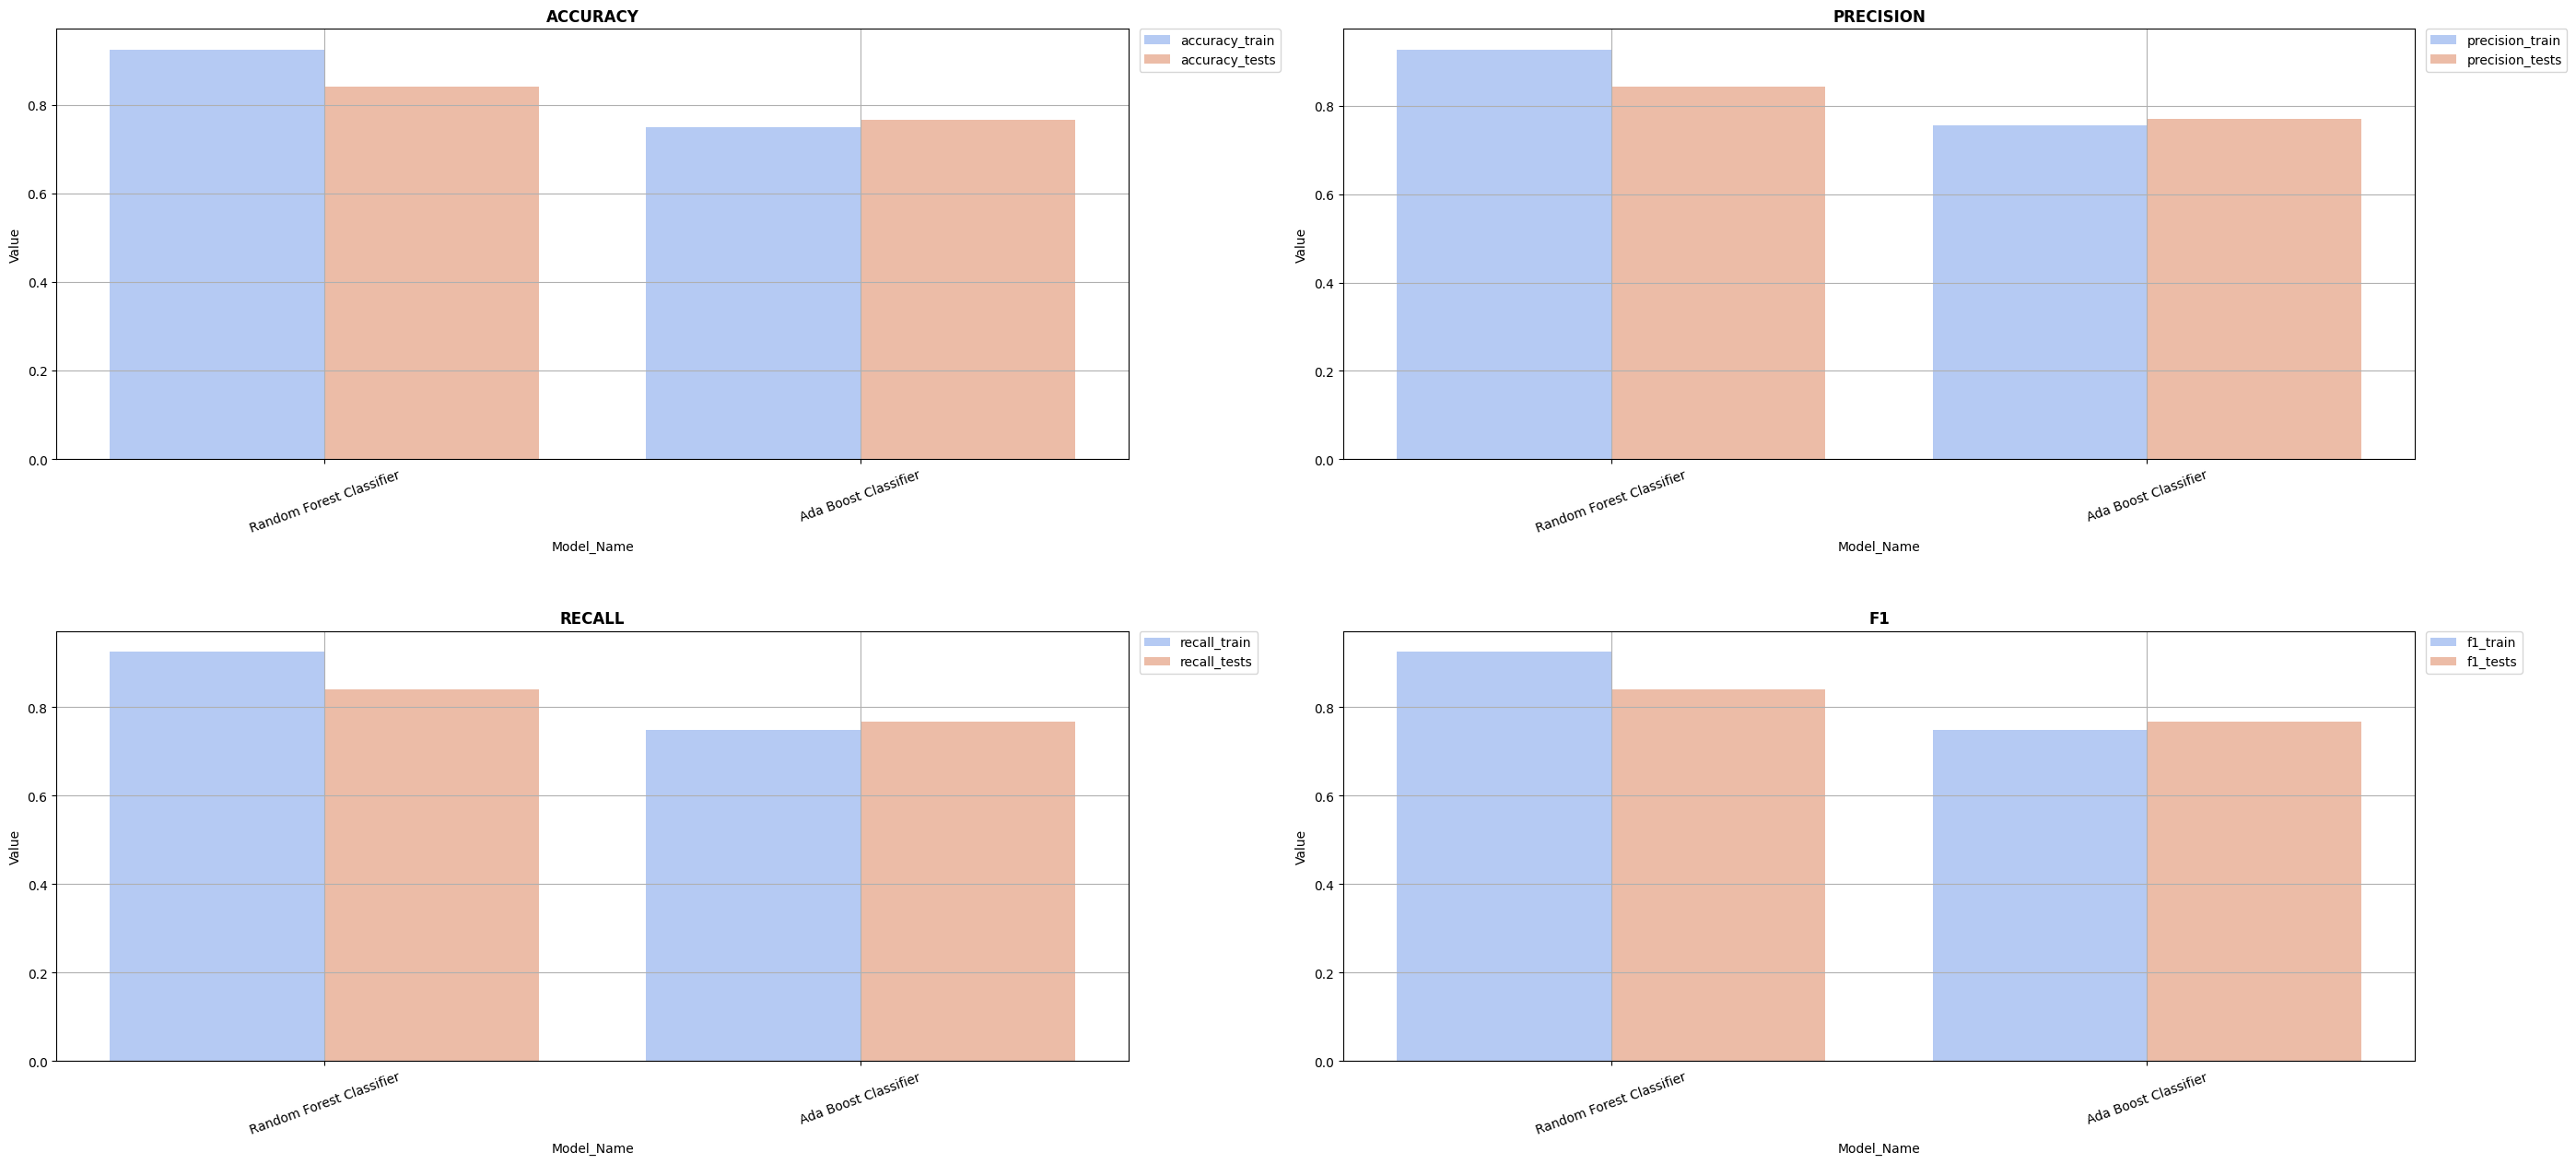

In [769]:
drawScores(scores)

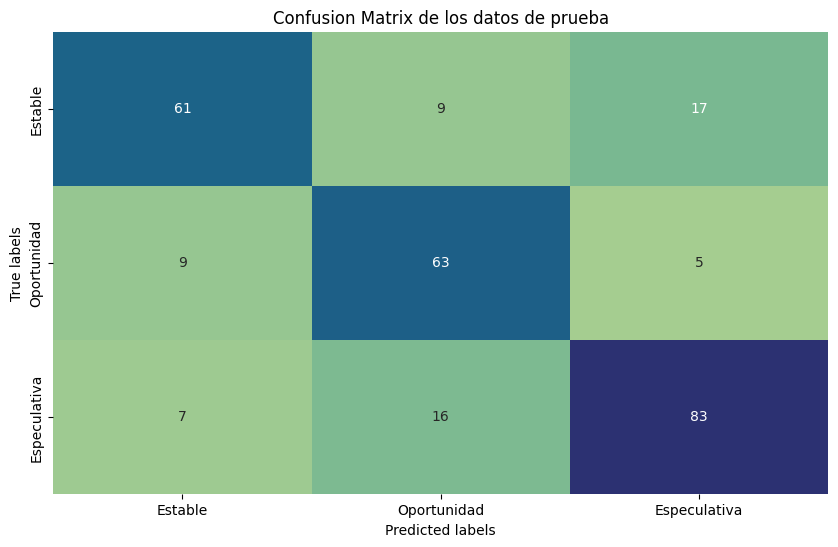

In [770]:
#Matriz de confusión
unique_classes = pd.unique(y_test)
y_pred_test=adaBoost.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test,labels=unique_classes)
plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap="crest",xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix de los datos de prueba')
plt.show()  

##### SUPPORT VECTOR CLASSIFIER

In [771]:
param_grid = {
    'C': [0.1,0.5, 1,5, 10,20,30,40,50,60,70,80],                
    'kernel': ['linear', 'rbf', 'poly','sigmoid'], 
    'gamma': ['scale', 'auto',  0.01,0.05, 0.06, 0.07, 0.08, 0.09,0.1,0.2]  
}

In [772]:
#Definimos el modelo
SVM = SVC(random_state=42)
grid = GridSearchCV(SVM, param_grid, cv=cv_num, n_jobs=-1,verbose=2,scoring=metric)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80],
                         'gamma': ['scale', 'auto', 0.01, 0.05, 0.06, 0.07,
                                   0.08, 0.09, 0.1, 0.2],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [773]:
#Obtenemos los mejores parametros
for key in grid.best_params_:
    print(f"Mejor parametro {key}: {grid.best_params_[key]}")
print(f"Mejor puntuación: {grid.best_score_}")

#Entrenamos el modelo con los mejores parametros
SVM = grid.best_estimator_
SVM.fit(X_train,y_train)

Mejor parametro C: 60
Mejor parametro gamma: scale
Mejor parametro kernel: rbf
Mejor puntuación: 0.6492063492063493


SVC(C=60, random_state=42)

In [774]:
models["Support Vector Classifier"] = SVM
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705
Ada Boost Classifier,0.749206,0.766667,0.755415,0.769769,0.749206,0.766667,0.747512,0.766344
Support Vector Classifier,0.669841,0.600000,0.675167,0.607234,0.669841,0.600000,0.667318,0.595920


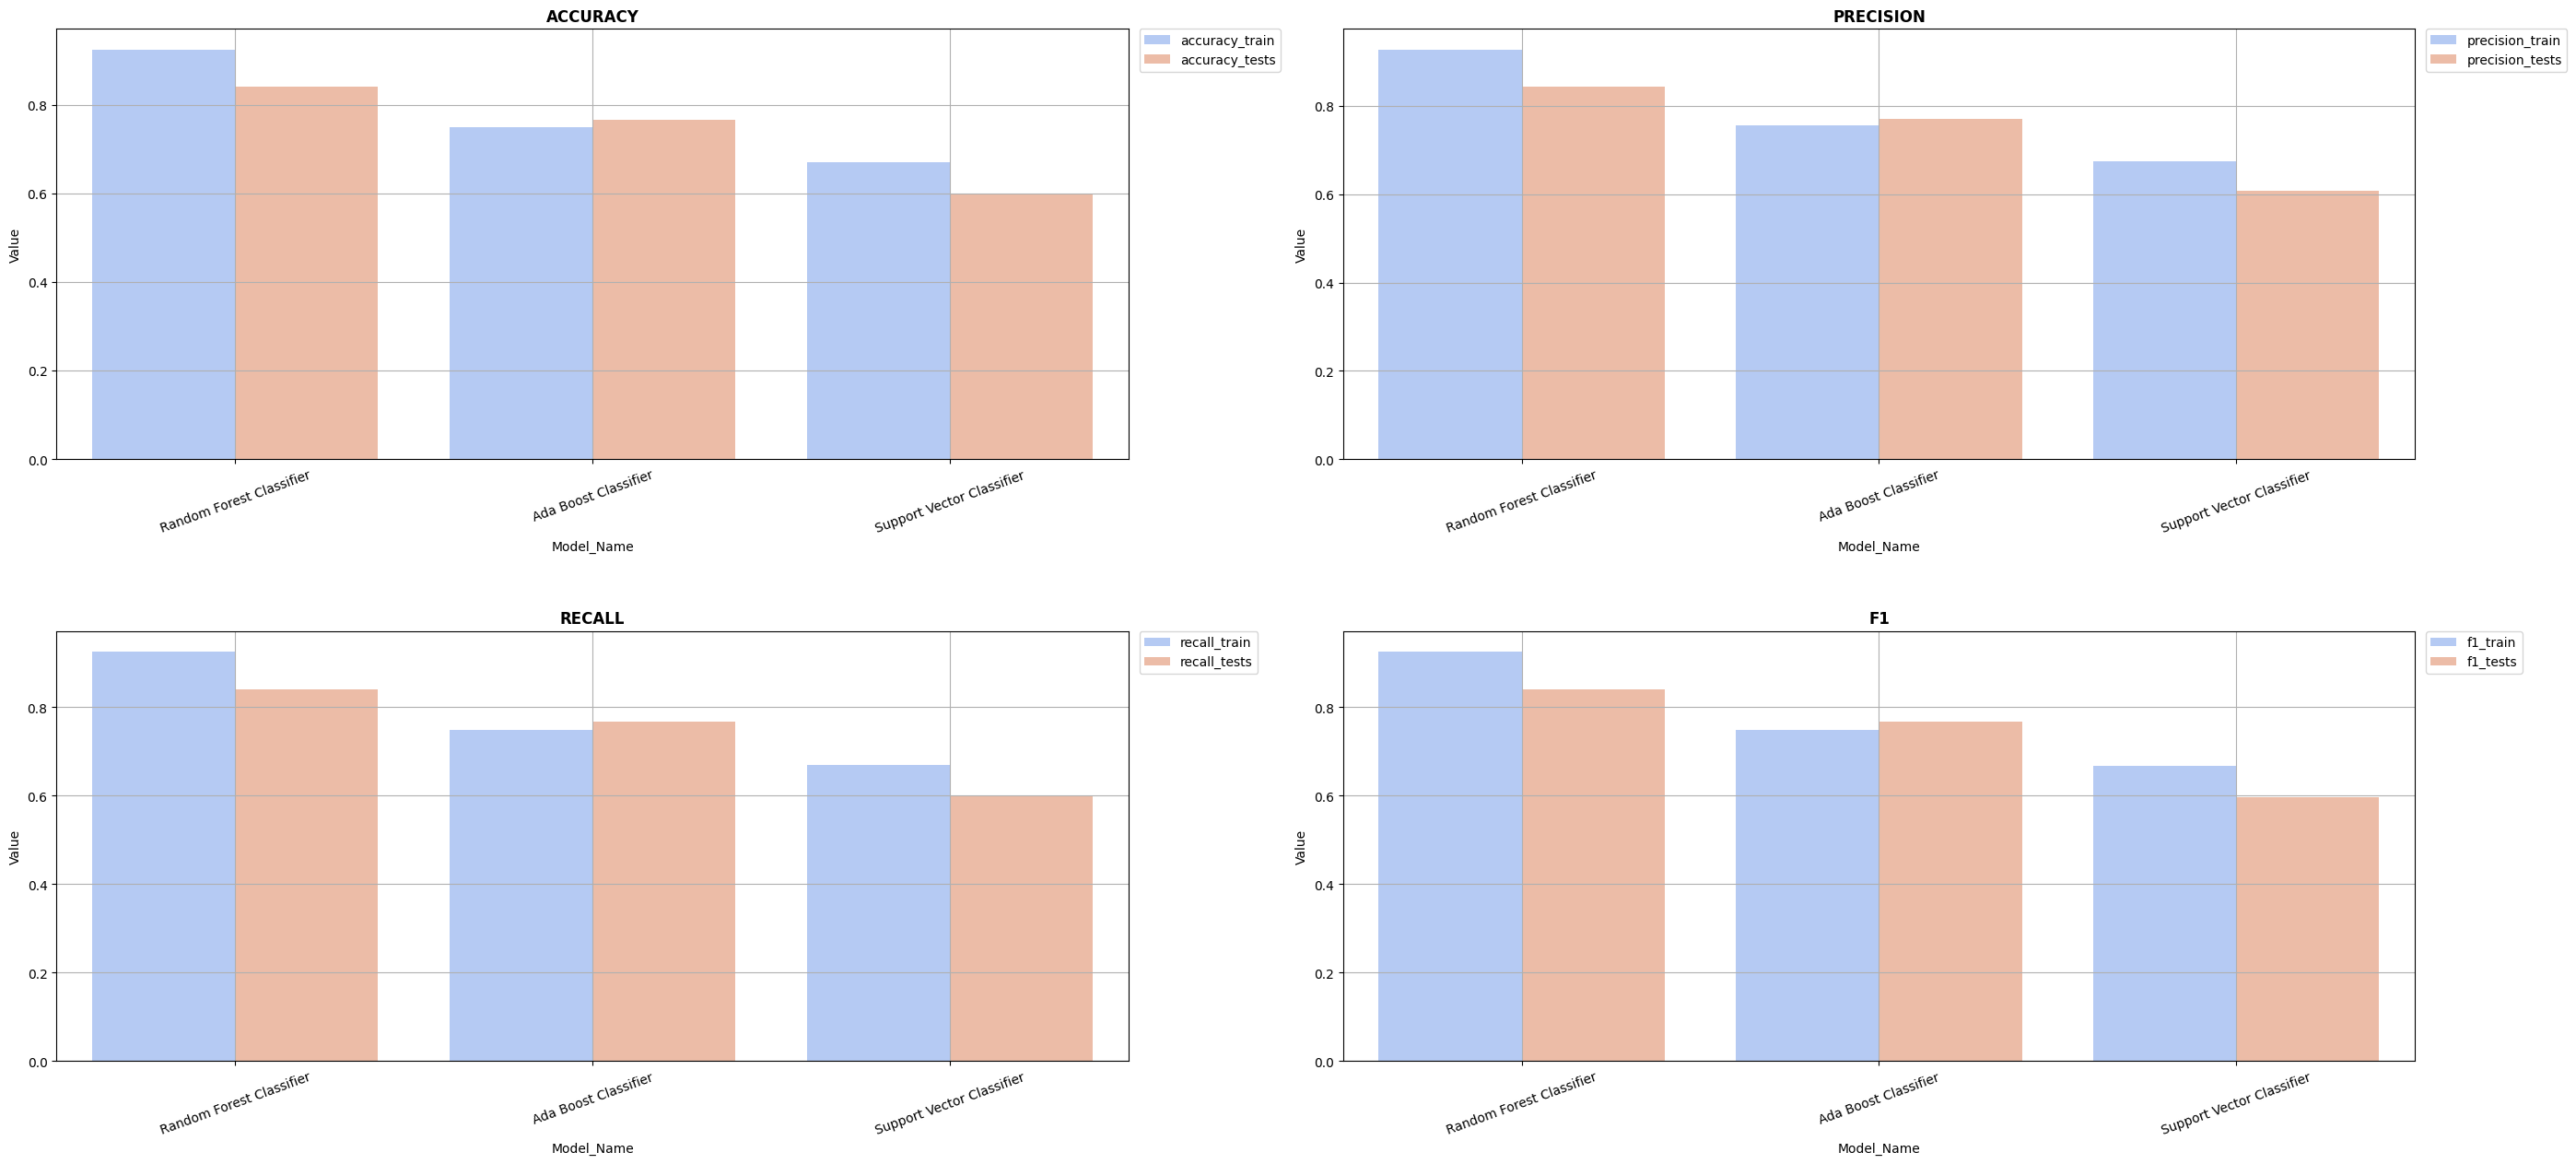

In [775]:
drawScores(scores)

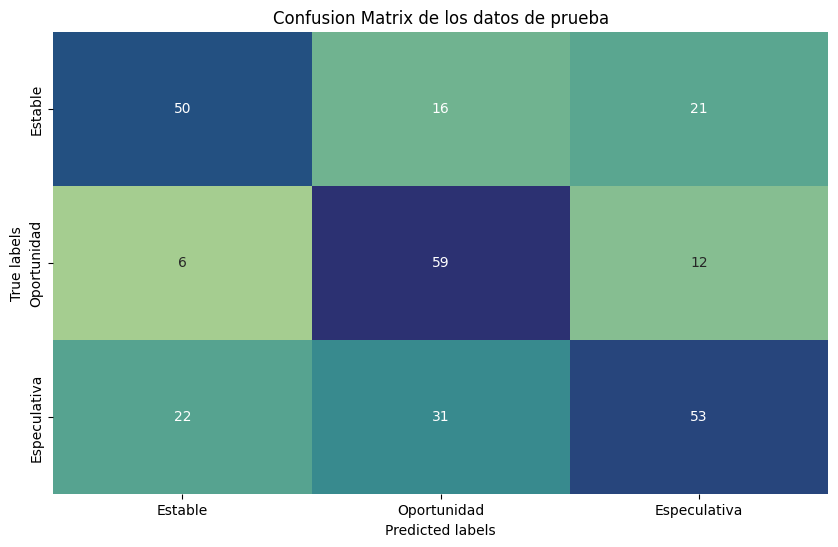

In [776]:
#Matriz de confusión
unique_classes = pd.unique(y_test)
y_pred_test=SVM.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test,labels=unique_classes)
plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap="crest",xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix de los datos de prueba')
plt.show()  

##### KNN CLASSIFIER

In [777]:
param_grid = {
    'n_neighbors': [3,4,5,6,7],       
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]                        
}

In [778]:
#Definimos el modelo
KNN = KNeighborsClassifier()
grid = GridSearchCV(KNN, param_grid, cv=cv_num, n_jobs=-1,verbose=2,scoring=metric)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 4, 5, 6, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [779]:
#Obtenemos los mejores parametros
for key in grid.best_params_:
    print(f"Mejor parametro {key}: {grid.best_params_[key]}")
print(f"Mejor puntuación: {grid.best_score_}")

#Entrenamos el modelo con los mejores parametros
KNN = grid.best_estimator_
KNN.fit(X_train,y_train)

Mejor parametro metric: manhattan
Mejor parametro n_neighbors: 4
Mejor parametro p: 1
Mejor parametro weights: distance
Mejor puntuación: 0.784126984126984


KNeighborsClassifier(metric='manhattan', n_neighbors=4, p=1, weights='distance')

In [780]:
models["KNN Classifier"] = KNN
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705
Ada Boost Classifier,0.749206,0.766667,0.755415,0.769769,0.749206,0.766667,0.747512,0.766344
Support Vector Classifier,0.669841,0.600000,0.675167,0.607234,0.669841,0.600000,0.667318,0.595920
KNN Classifier,1.000000,0.788889,1.000000,0.796827,1.000000,0.788889,1.000000,0.789865


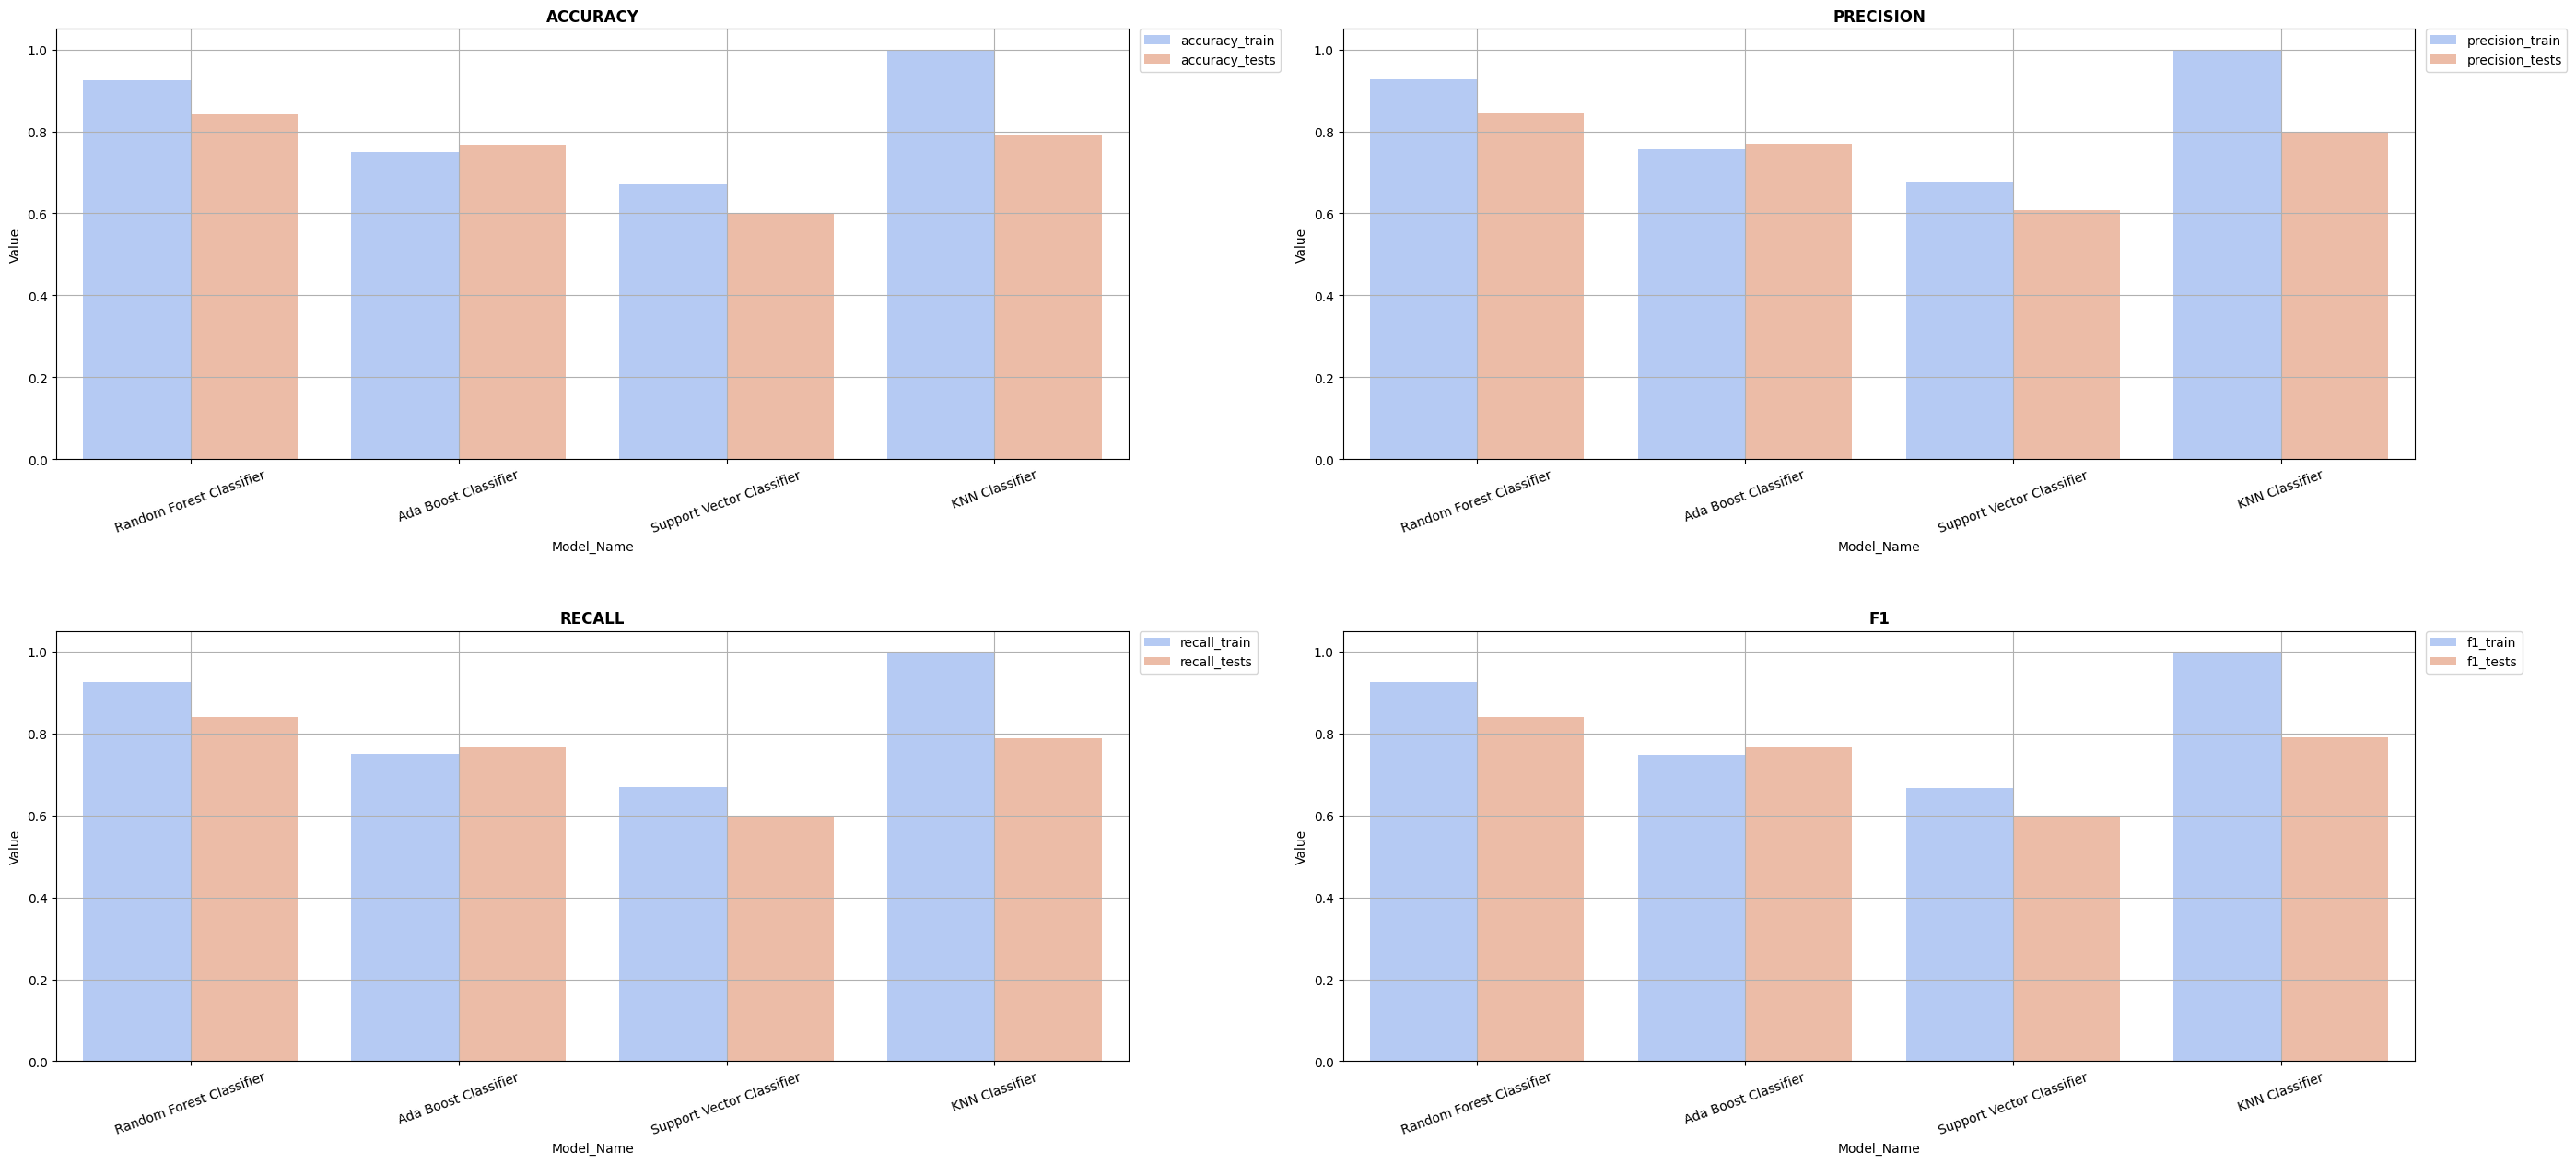

In [781]:
drawScores(scores)

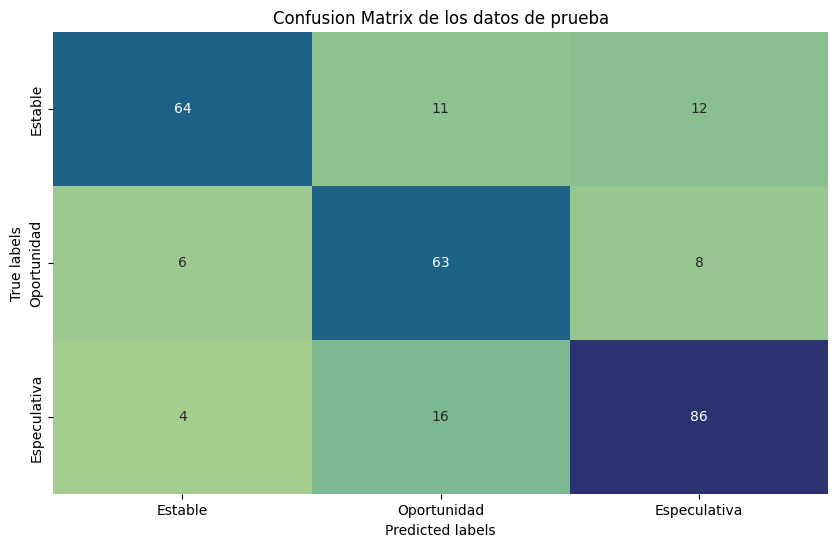

In [782]:
#Matriz de confusión
unique_classes = pd.unique(y_test)
y_pred_test=KNN.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test,labels=unique_classes)
plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap="crest",xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix de los datos de prueba')
plt.show()  

##### GAUSSIAN NB

In [783]:
NB = GaussianNB()
NB.fit(X_train,y_train)

GaussianNB()

In [784]:
models["Gaussian Naive Bayes"] = NB
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705
Ada Boost Classifier,0.749206,0.766667,0.755415,0.769769,0.749206,0.766667,0.747512,0.766344
Support Vector Classifier,0.669841,0.600000,0.675167,0.607234,0.669841,0.600000,0.667318,0.595920
KNN Classifier,1.000000,0.788889,1.000000,0.796827,1.000000,0.788889,1.000000,0.789865
Gaussian Naive Bayes,0.460317,0.448148,0.666711,0.779636,0.460317,0.448148,0.383770,0.402708


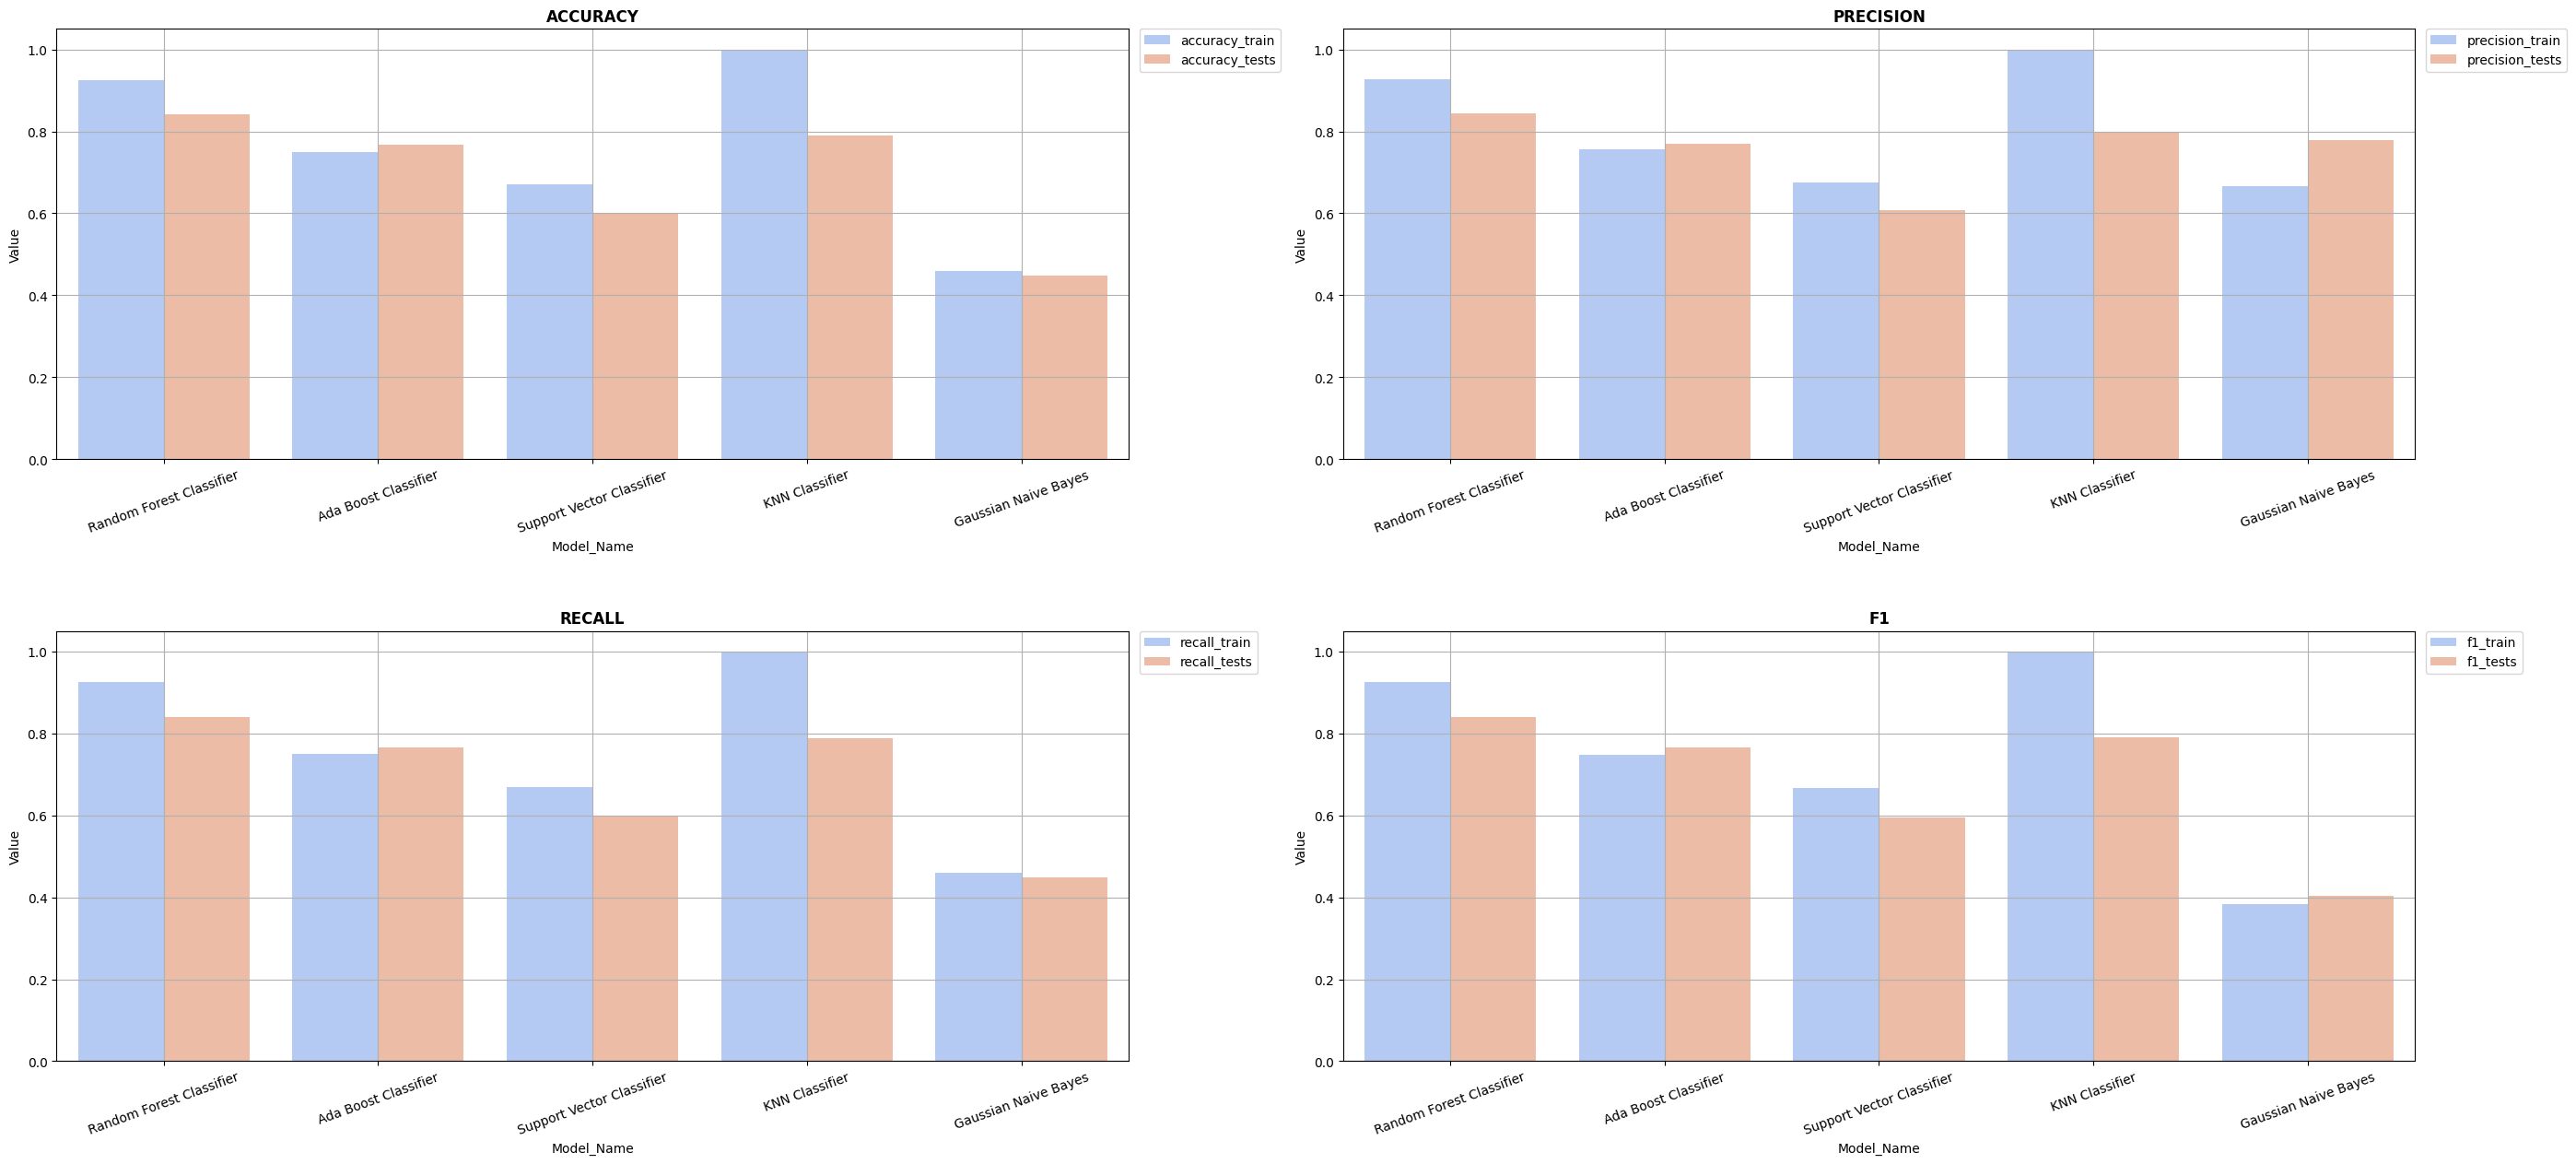

In [785]:
drawScores(scores)

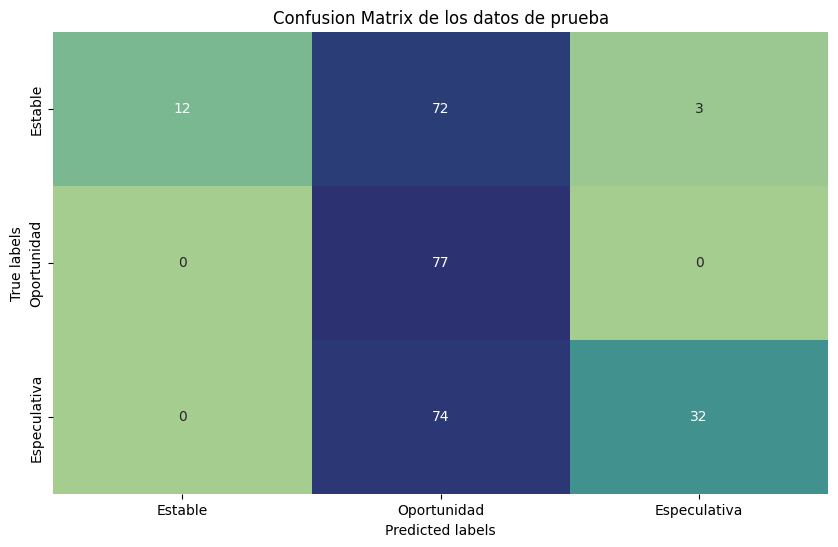

In [786]:
#Matriz de confusión
unique_classes = pd.unique(y_test)
y_pred_test=NB.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test,labels=unique_classes)
plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap="crest",xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix de los datos de prueba')
plt.show()  

##### GRADIENT BOOSTING CLASSIFIER

In [787]:
param_grid = {
    'n_estimators': [10,25,50, 100, 150, 200],  
    'max_depth': [2,3,5,7],      
    'learning_rate': [0.01,0.03,0.05, 0.07],                
}

In [788]:
#Definimos el modelo
GBC = GradientBoostingClassifier()
grid = GridSearchCV(GBC, param_grid, cv=cv_num, n_jobs=-1,verbose=2,scoring=metric)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05, 0.07],
                         'max_depth': [2, 3, 5, 7],
                         'n_estimators': [10, 25, 50, 100, 150, 200]},
             scoring='accuracy', verbose=2)

In [789]:
#Obtenemos los mejores parametros
for key in grid.best_params_:
    print(f"Mejor parametro {key}: {grid.best_params_[key]}")
print(f"Mejor puntuación: {grid.best_score_}")

#Entrenamos el modelo con los mejores parametros
GBC = grid.best_estimator_
GBC.fit(X_train,y_train)

Mejor parametro learning_rate: 0.07
Mejor parametro max_depth: 7
Mejor parametro n_estimators: 200
Mejor puntuación: 0.8571428571428573


GradientBoostingClassifier(learning_rate=0.07, max_depth=7, n_estimators=200)

In [790]:
models["Gradient Boosting Classifier"] = GBC
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705
Ada Boost Classifier,0.749206,0.766667,0.755415,0.769769,0.749206,0.766667,0.747512,0.766344
Support Vector Classifier,0.669841,0.600000,0.675167,0.607234,0.669841,0.600000,0.667318,0.595920
KNN Classifier,1.000000,0.788889,1.000000,0.796827,1.000000,0.788889,1.000000,0.789865
Gaussian Naive Bayes,0.460317,0.448148,0.666711,0.779636,0.460317,0.448148,0.383770,0.402708
Gradient Boosting Classifier,1.000000,0.874074,1.000000,0.878941,1.000000,0.874074,1.000000,0.873596


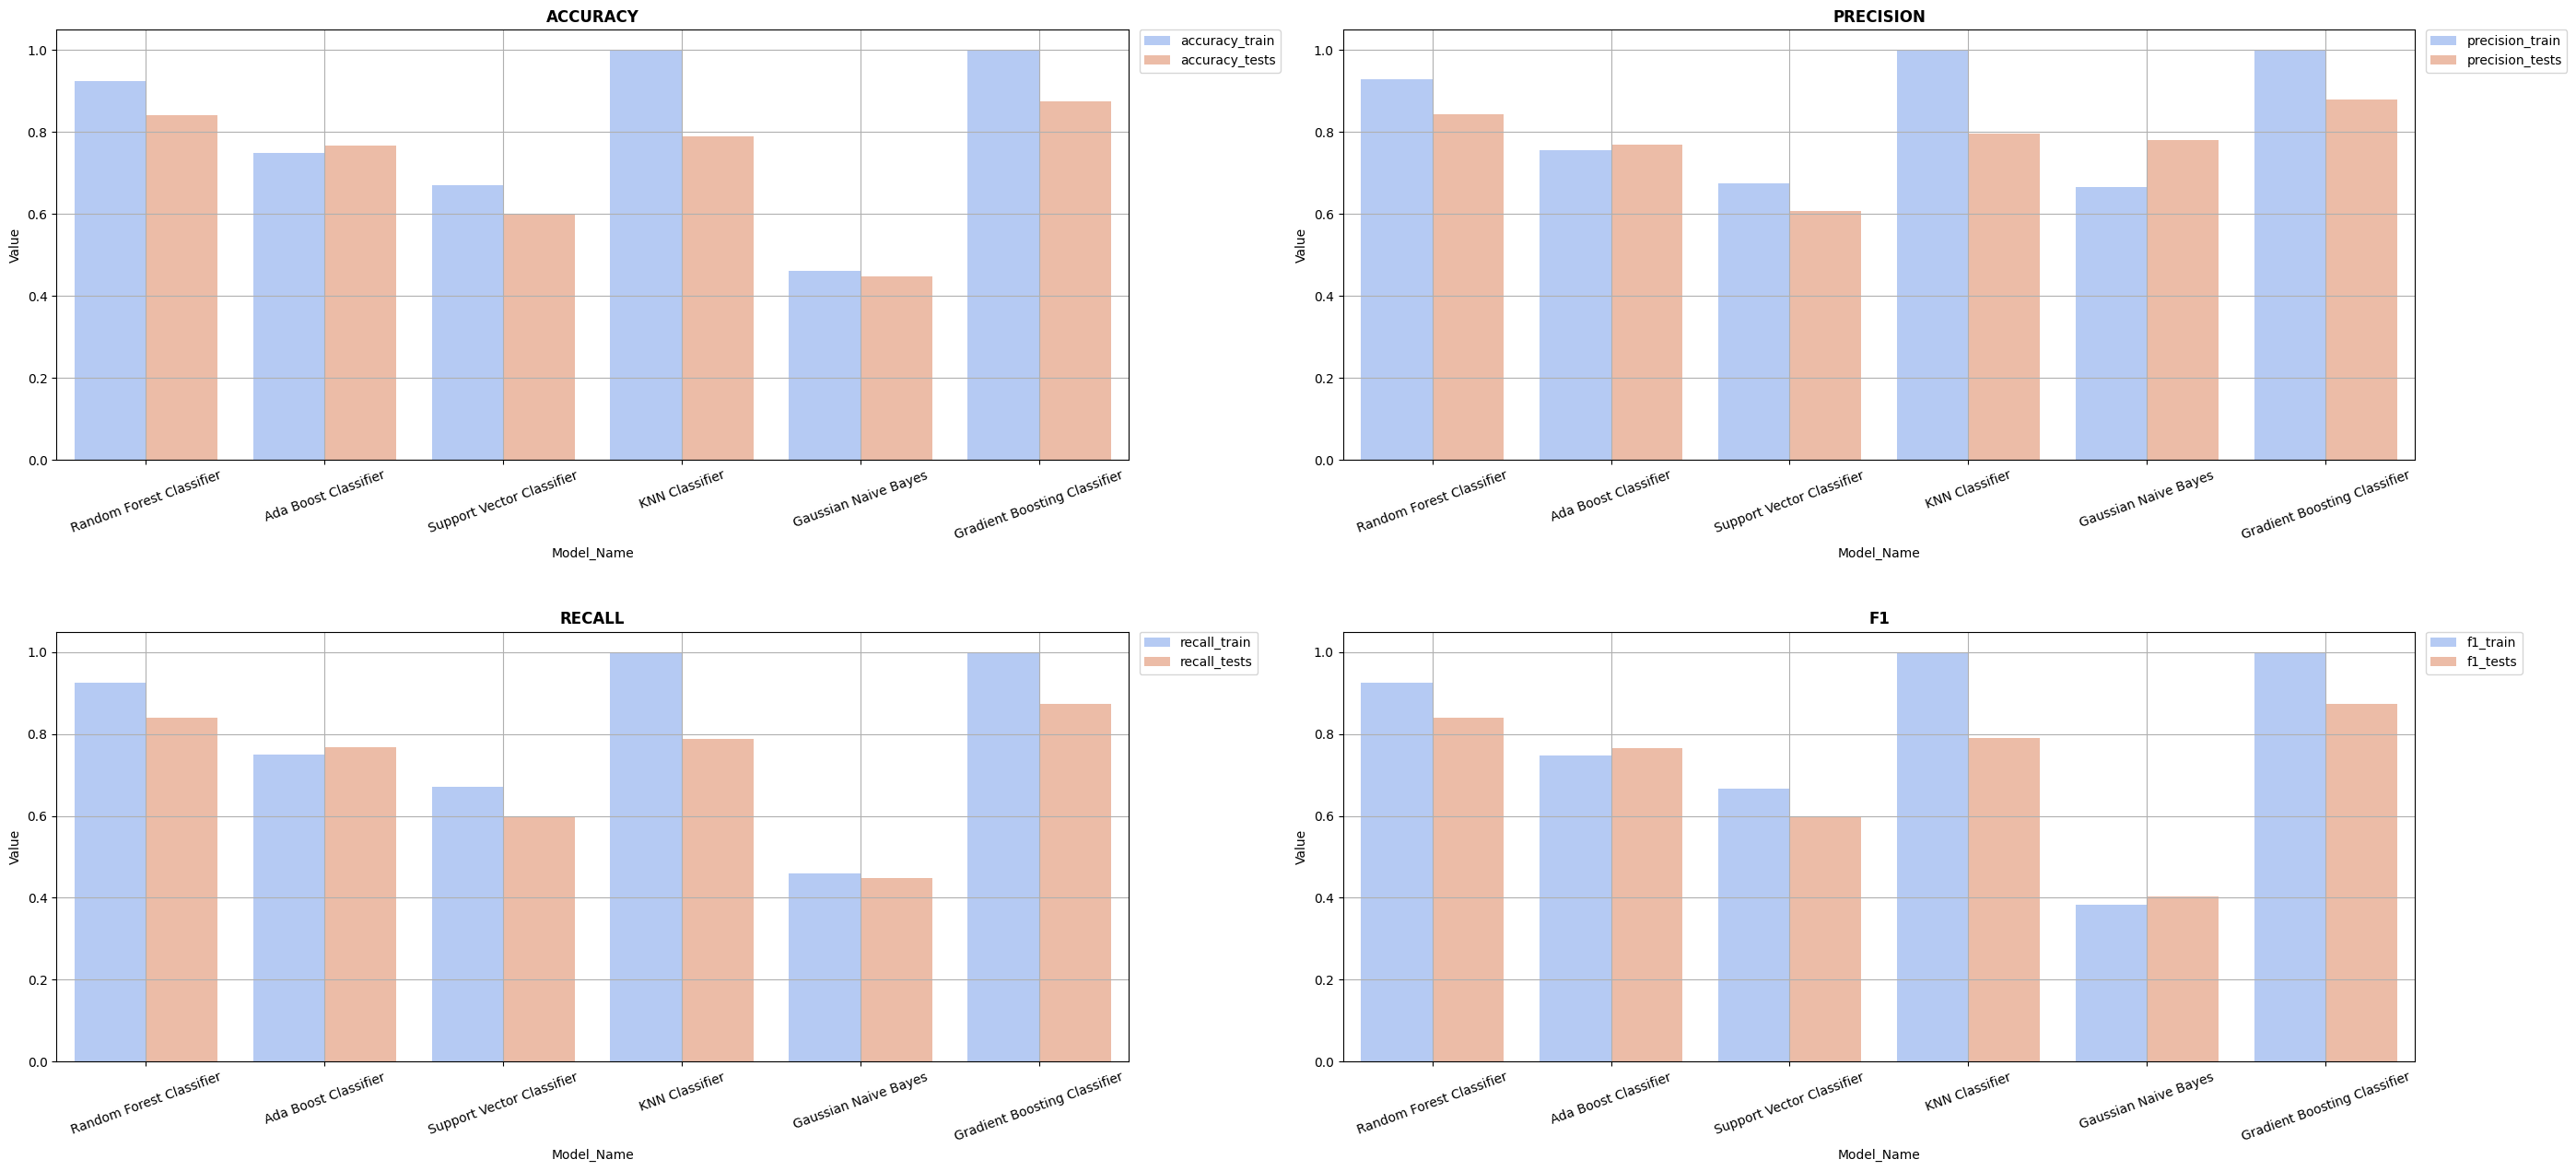

In [791]:
drawScores(scores)

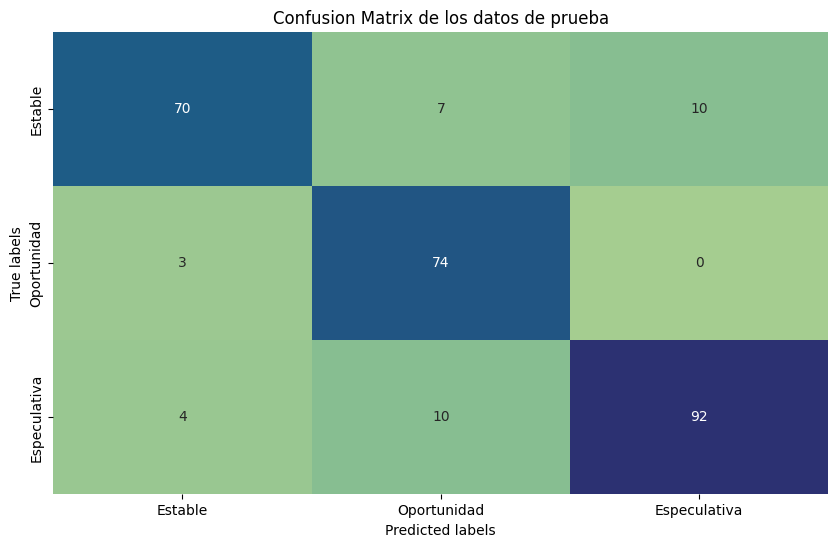

In [792]:
#Matriz de confusión
unique_classes = pd.unique(y_test)
y_pred_test=GBC.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test,labels=unique_classes)
plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap="crest",xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix de los datos de prueba')
plt.show()  

##### LOGISTIC REGRESSION

In [793]:
param_grid = {
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100,200,300,400,500,600,700,800,900,1000],
}

In [794]:
log_reg  = LogisticRegression(random_state=42,multi_class='multinomial',)
grid = GridSearchCV(log_reg , param_grid, cv=cv_num, n_jobs=-1,verbose=2,scoring=metric)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'max_iter': [100, 200, 300, 400, 500, 600, 700, 800,
                                      900, 1000],
                         'solver': ['lbfgs', 'saga']},
             scoring='accuracy', verbose=2)

In [795]:
#Obtenemos los mejores parametros
for key in grid.best_params_:
    print(f"Mejor parametro {key}: {grid.best_params_[key]}")
print(f"Mejor puntuación: {grid.best_score_}")

#Entrenamos el modelo con los mejores parametros
log_reg = grid.best_estimator_
log_reg.fit(X_train,y_train)

Mejor parametro max_iter: 100
Mejor parametro solver: lbfgs
Mejor puntuación: 0.42857142857142855


LogisticRegression(multi_class='multinomial', random_state=42)

In [796]:
models["Logistic Regression"] = log_reg
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705
Ada Boost Classifier,0.749206,0.766667,0.755415,0.769769,0.749206,0.766667,0.747512,0.766344
Support Vector Classifier,0.669841,0.600000,0.675167,0.607234,0.669841,0.600000,0.667318,0.595920
KNN Classifier,1.000000,0.788889,1.000000,0.796827,1.000000,0.788889,1.000000,0.789865
Gaussian Naive Bayes,0.460317,0.448148,0.666711,0.779636,0.460317,0.448148,0.383770,0.402708
Gradient Boosting Classifier,1.000000,0.874074,1.000000,0.878941,1.000000,0.874074,1.000000,0.873596
Logistic Regression,0.433333,0.414815,0.413876,0.363870,0.433333,0.414815,0.365553,0.332098


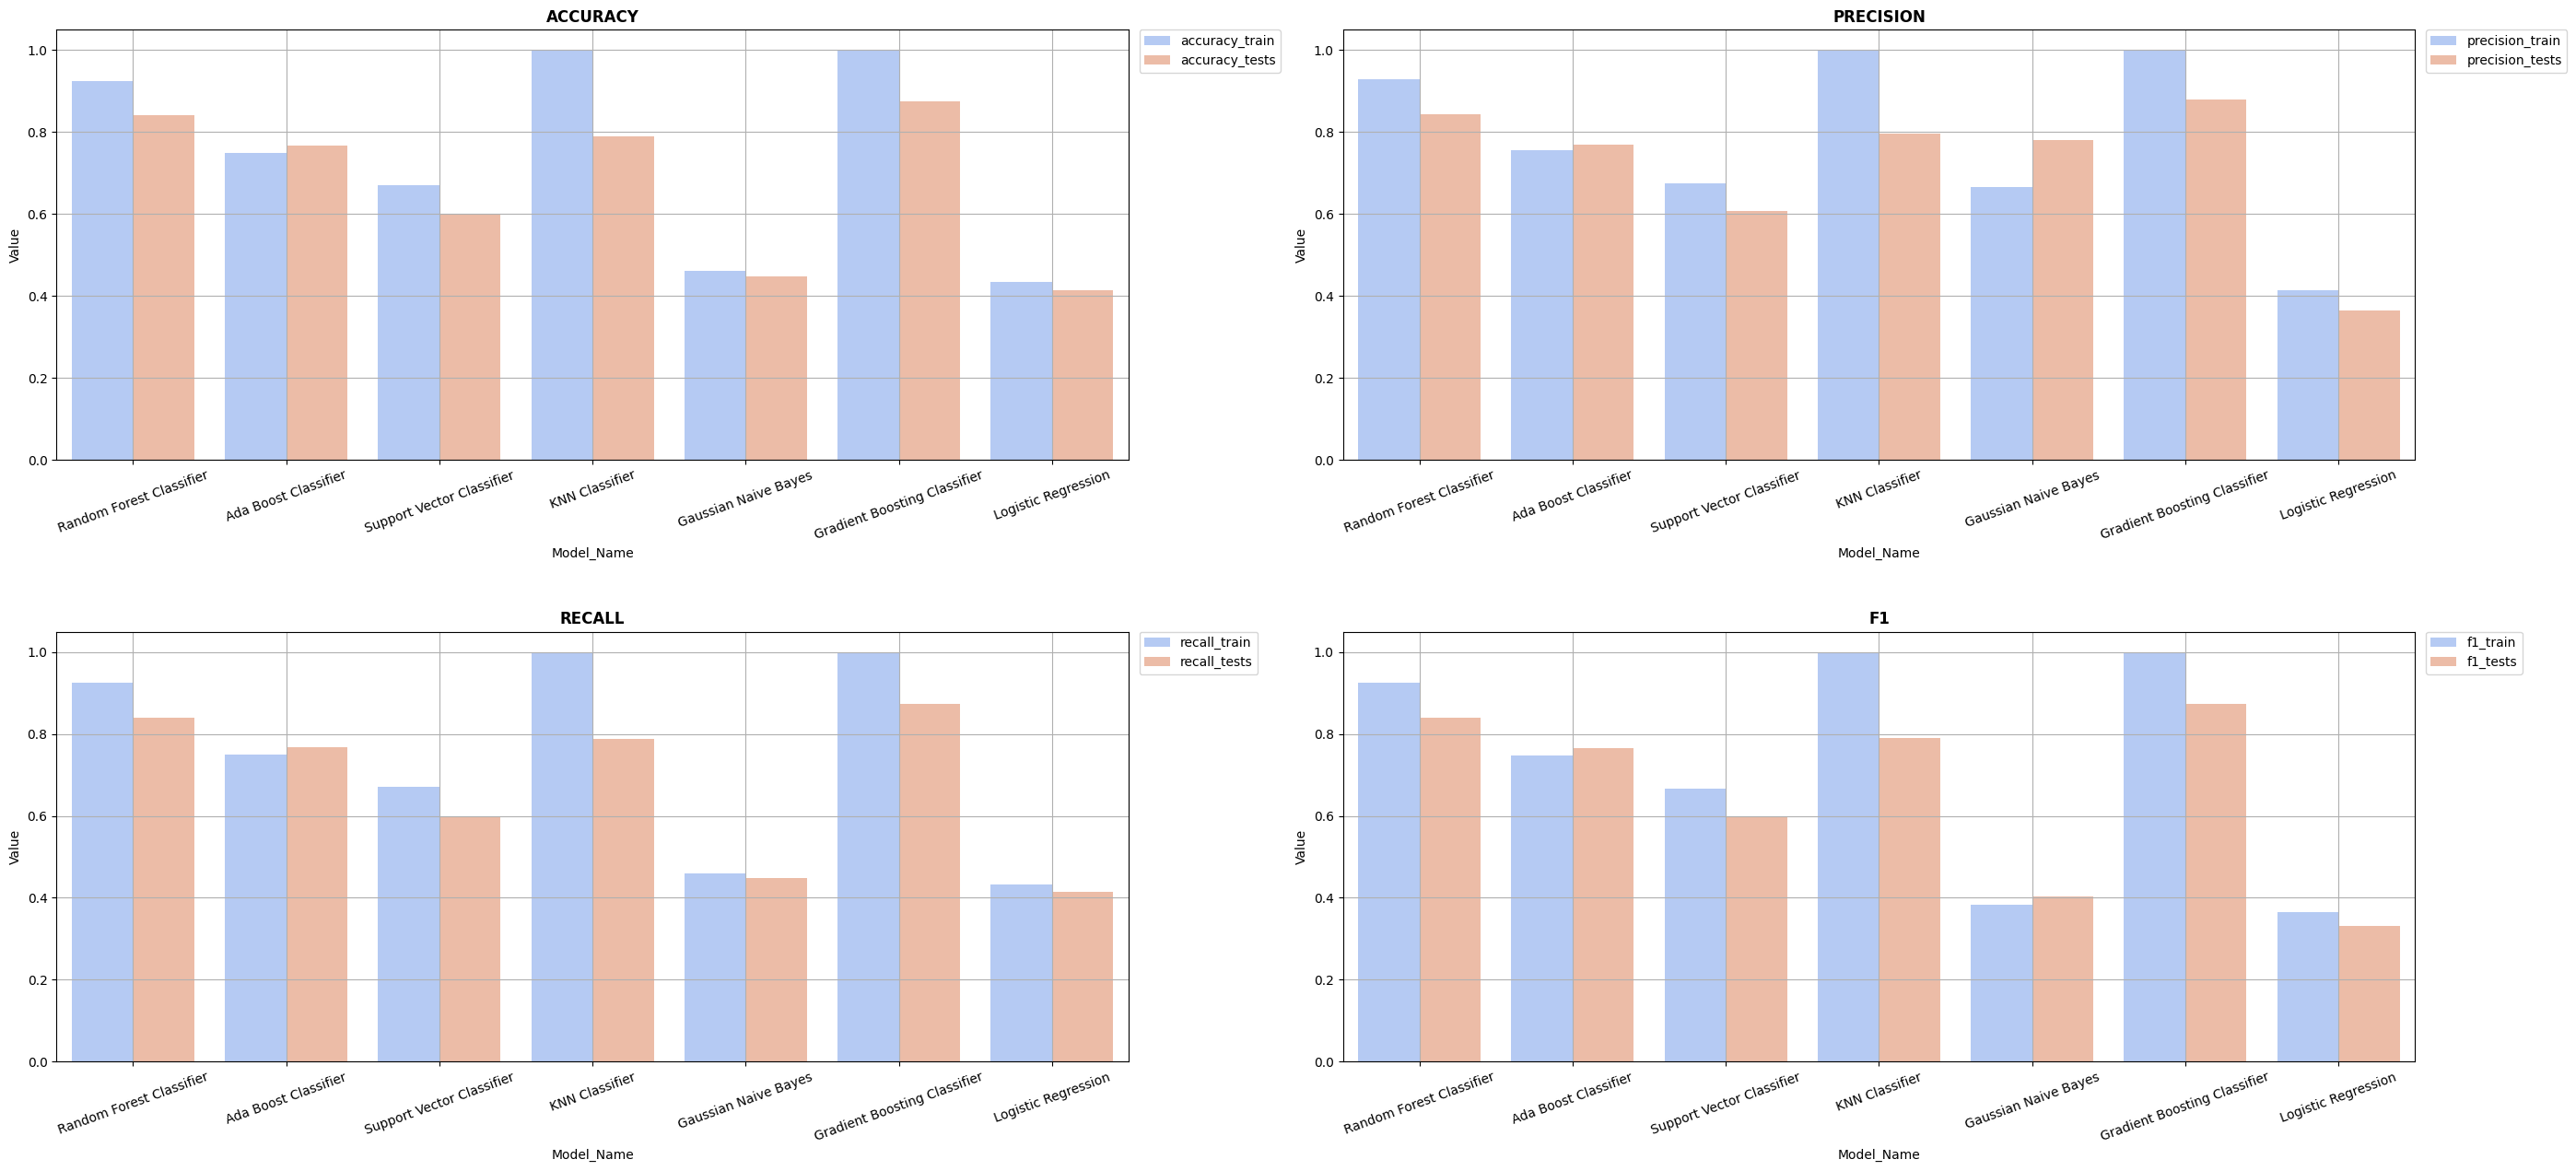

In [797]:
drawScores(scores)

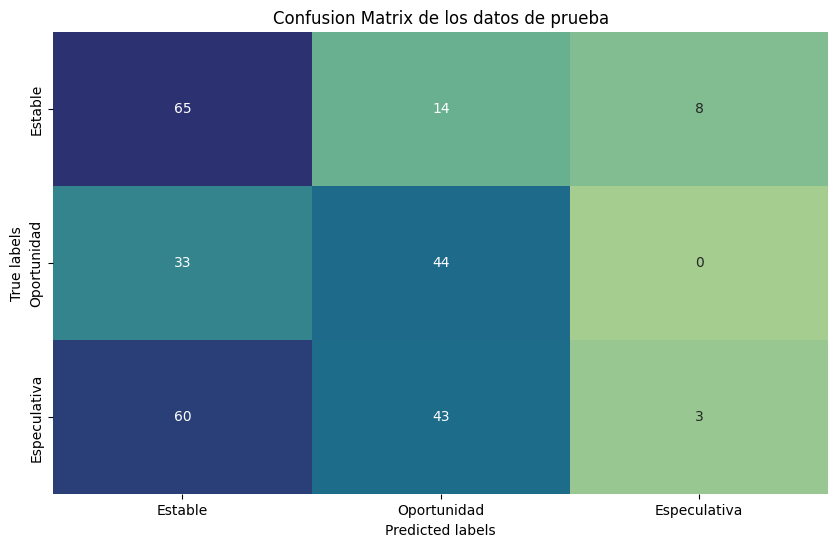

In [798]:
#Matriz de confusión
unique_classes = pd.unique(y_test)
y_pred_test=log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test,labels=unique_classes)
plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap="crest",xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix de los datos de prueba')
plt.show()  

##### VOTING CLASSIFIER

In [799]:
estimators = [
    ('rf', clf),
    ('ada', adaBoost),
    ('gbc', GBC),
    ('log_reg', log_reg)
]
#Obtenemos los mejores parametros
voting_clf = VotingClassifier(estimators=estimators, voting='hard')
voting_clf.fit(X_train,y_train)

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=9,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=30,
                                                     random_state=42)),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.05,
                                                 n_estimators=75,
                                                 random_state=42)),
                             ('gbc',
                              GradientBoostingClassifier(learning_rate=0.07,
                                                         max_depth=7,
                                                         n_estimators=200)),
                             ('log_reg',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=42))])

In [800]:
models["Voting Classifier"] = voting_clf
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705
Ada Boost Classifier,0.749206,0.766667,0.755415,0.769769,0.749206,0.766667,0.747512,0.766344
Support Vector Classifier,0.669841,0.600000,0.675167,0.607234,0.669841,0.600000,0.667318,0.595920
KNN Classifier,1.000000,0.788889,1.000000,0.796827,1.000000,0.788889,1.000000,0.789865
Gaussian Naive Bayes,0.460317,0.448148,0.666711,0.779636,0.460317,0.448148,0.383770,0.402708
Gradient Boosting Classifier,1.000000,0.874074,1.000000,0.878941,1.000000,0.874074,1.000000,0.873596
Logistic Regression,0.433333,0.414815,0.413876,0.363870,0.433333,0.414815,0.365553,0.332098
Voting Classifier,0.942857,0.848148,0.943984,0.853033,0.942857,0.848148,0.942741,0.846799


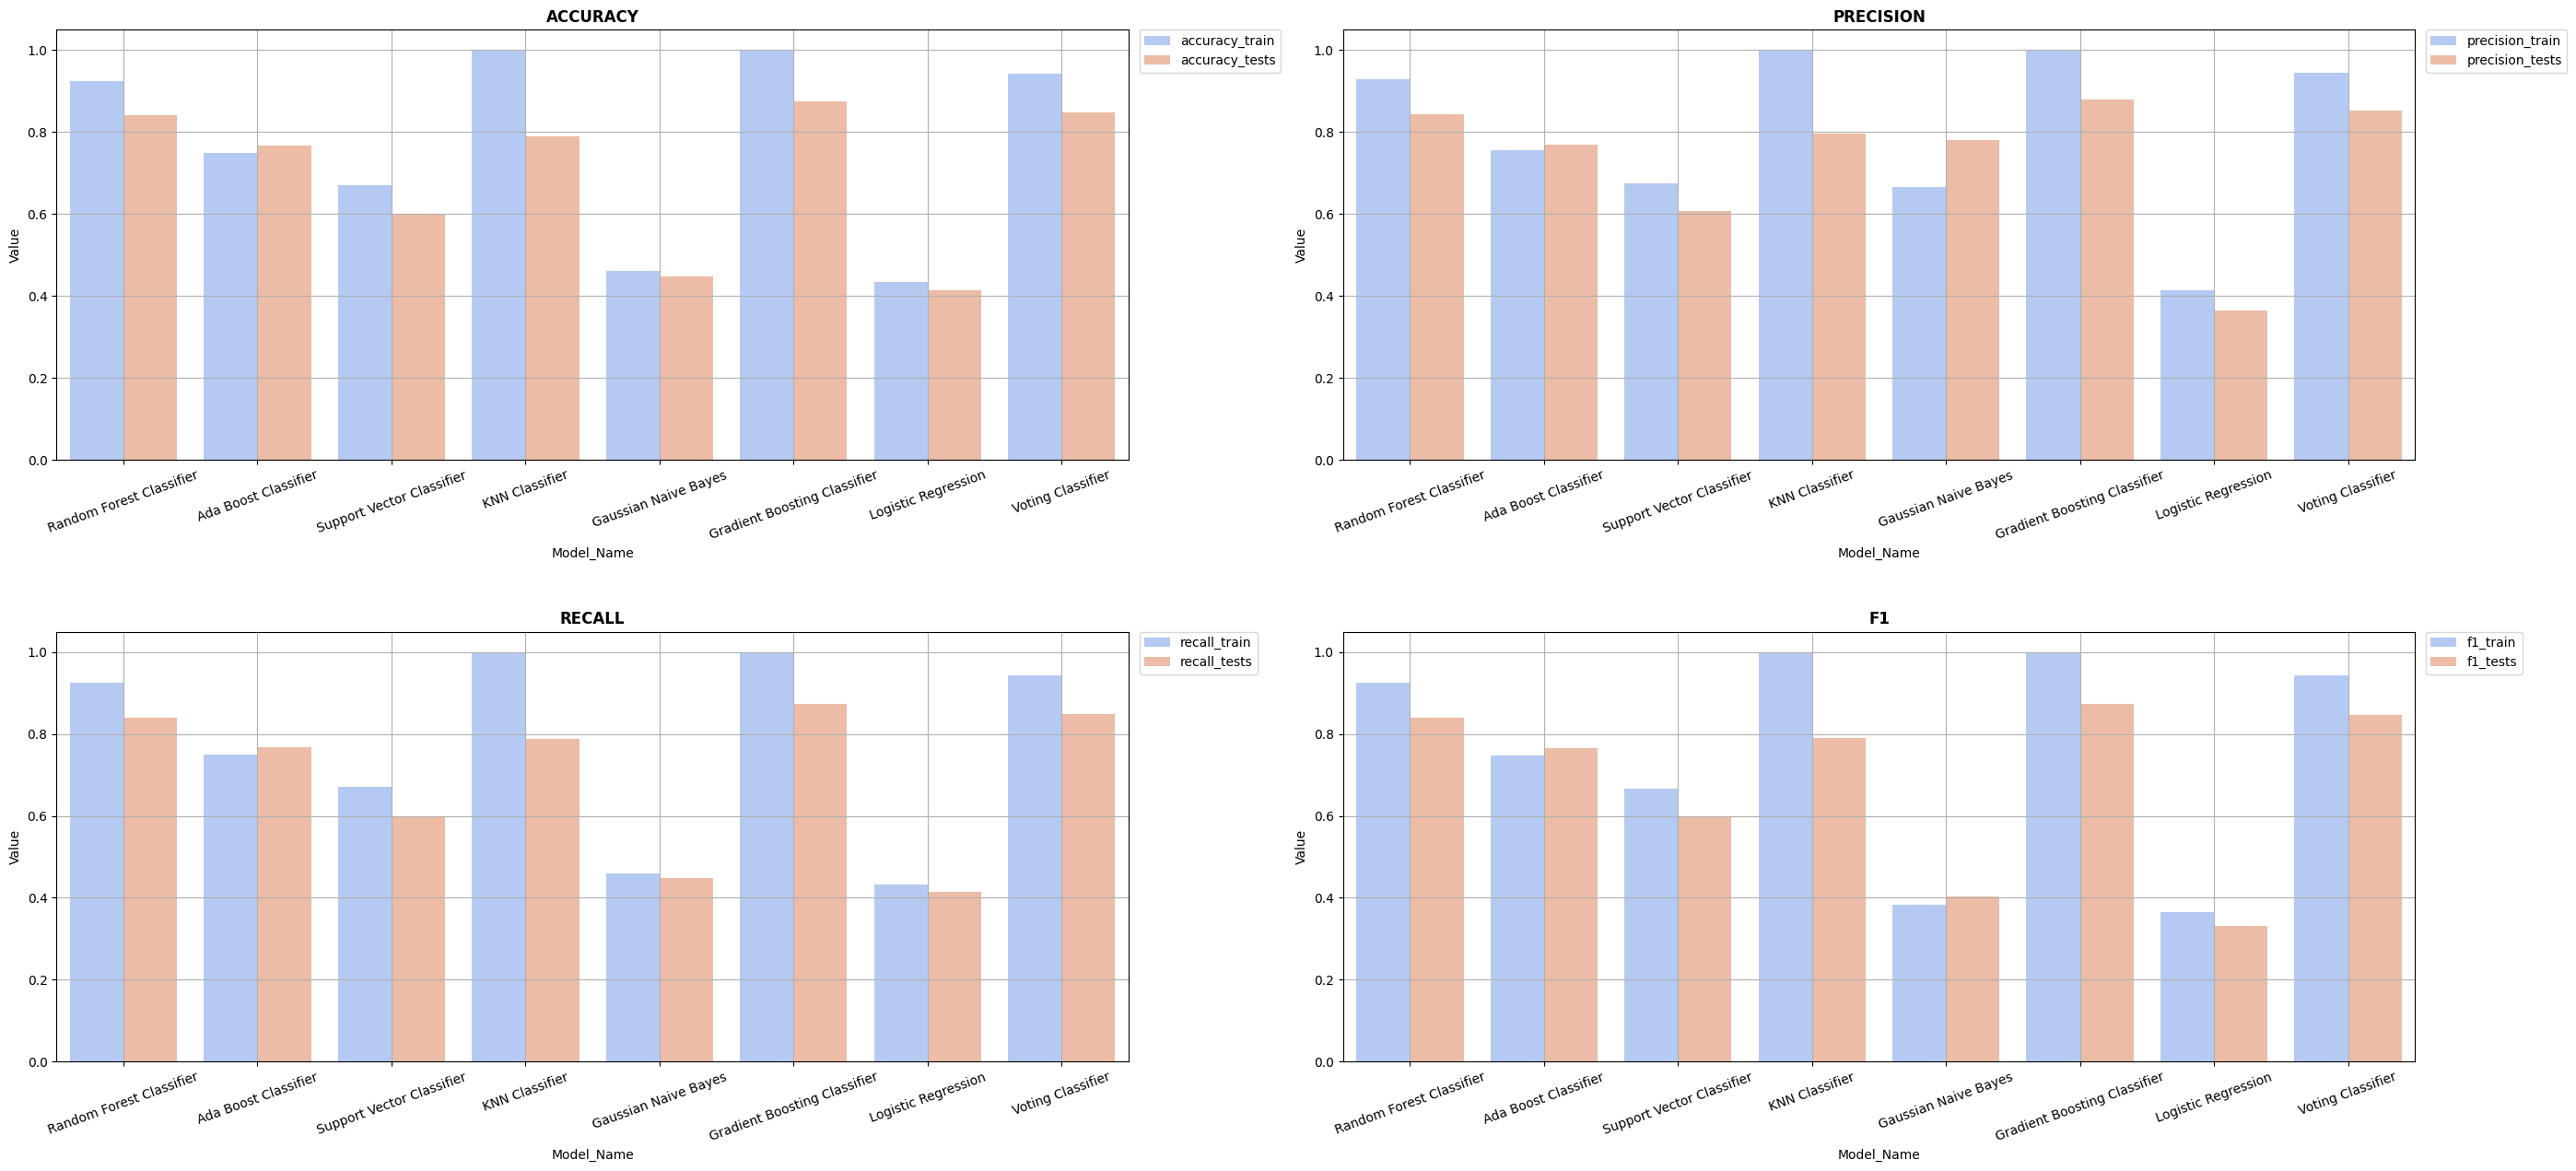

In [801]:
drawScores(scores)

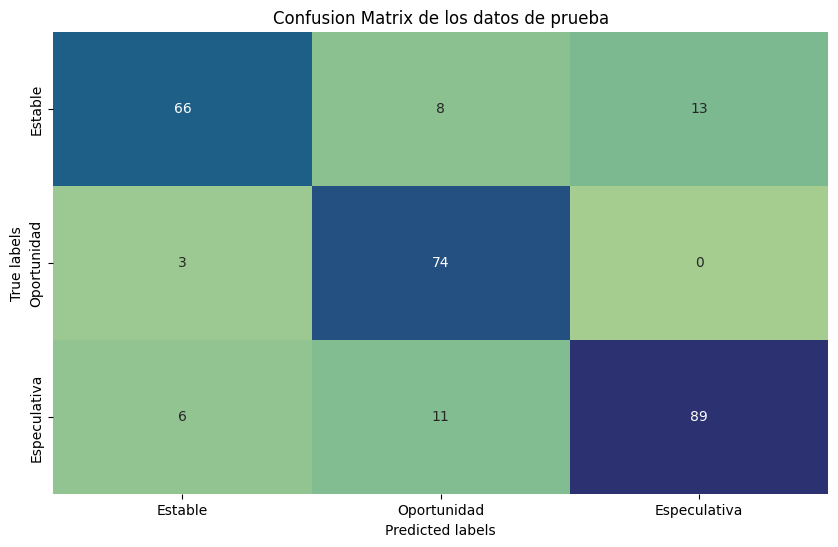

In [802]:
#Matriz de confusión
unique_classes = pd.unique(y_test)
y_pred_test=voting_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test,labels=unique_classes)
plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap="crest",xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix de los datos de prueba')
plt.show()  

##### ANÁLISIS DE LOS MODELOS

1) PRUEBA DE COMPARACIÓN ENTRE RESULTADOS DE PRUEBA Y DE ENTRENAMIENTO

    A partir de este análisis, se comprueba que no existe una diferencia significativa entre sus resultados en el conjuto de datos de prueba y entrenamiento

In [803]:
scores = seeScores(models)
scores

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
model_name,,,,,,,,
Random Forest Classifier,0.925397,0.840741,0.928035,0.844571,0.925397,0.840741,0.925403,0.839705
Ada Boost Classifier,0.749206,0.766667,0.755415,0.769769,0.749206,0.766667,0.747512,0.766344
Support Vector Classifier,0.669841,0.600000,0.675167,0.607234,0.669841,0.600000,0.667318,0.595920
KNN Classifier,1.000000,0.788889,1.000000,0.796827,1.000000,0.788889,1.000000,0.789865
Gaussian Naive Bayes,0.460317,0.448148,0.666711,0.779636,0.460317,0.448148,0.383770,0.402708
Gradient Boosting Classifier,1.000000,0.874074,1.000000,0.878941,1.000000,0.874074,1.000000,0.873596
Logistic Regression,0.433333,0.414815,0.413876,0.363870,0.433333,0.414815,0.365553,0.332098
Voting Classifier,0.942857,0.848148,0.943984,0.853033,0.942857,0.848148,0.942741,0.846799


2) CURVAS DE APRENDIZAJE

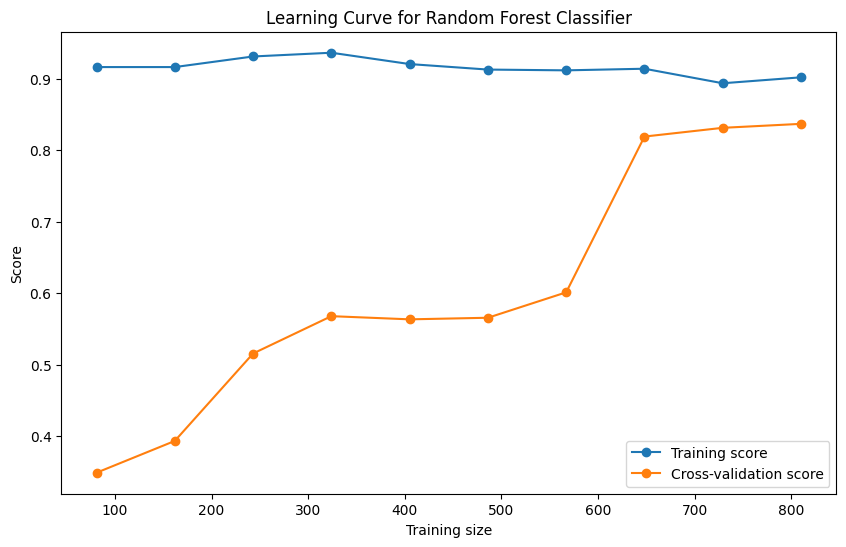

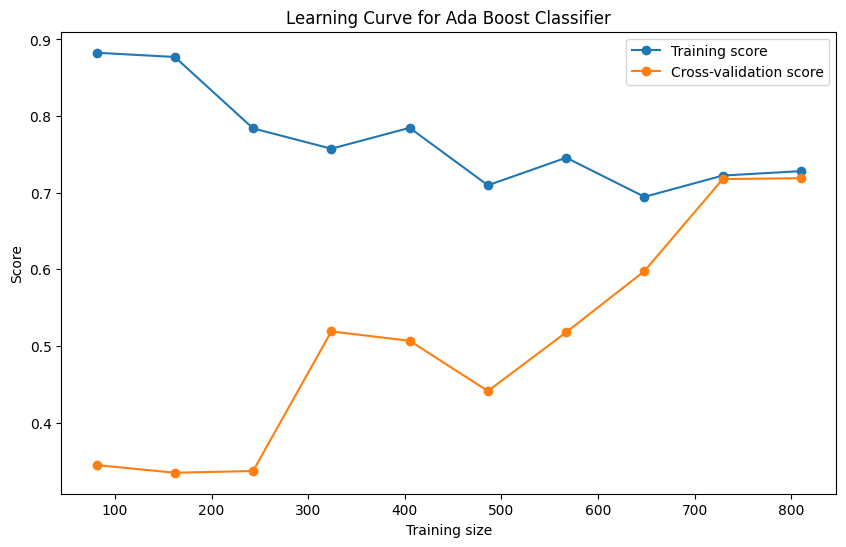

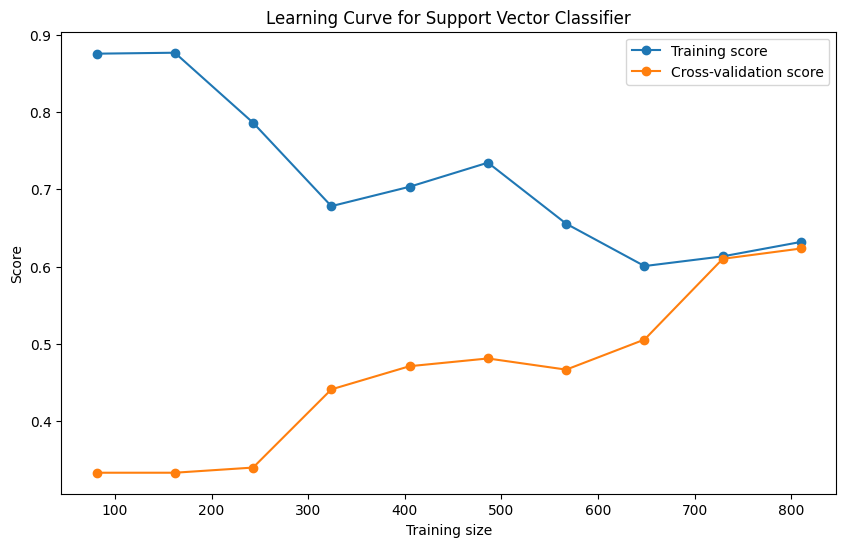

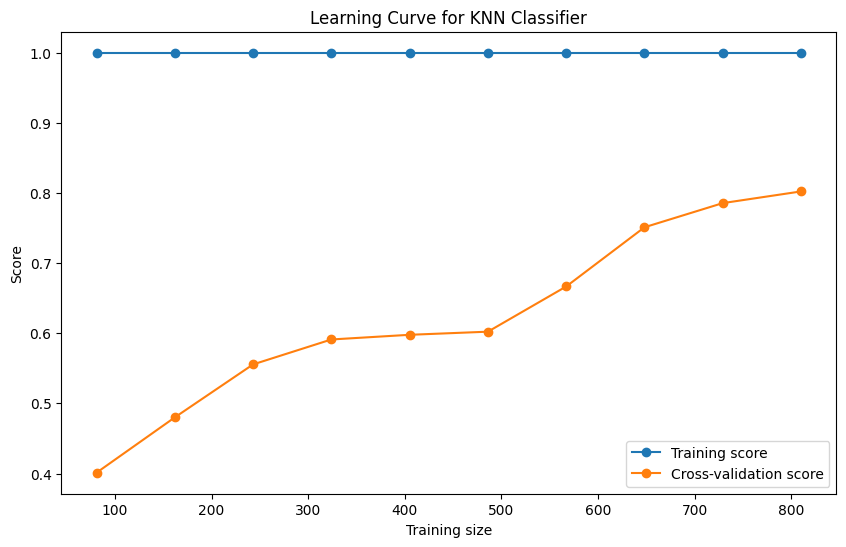

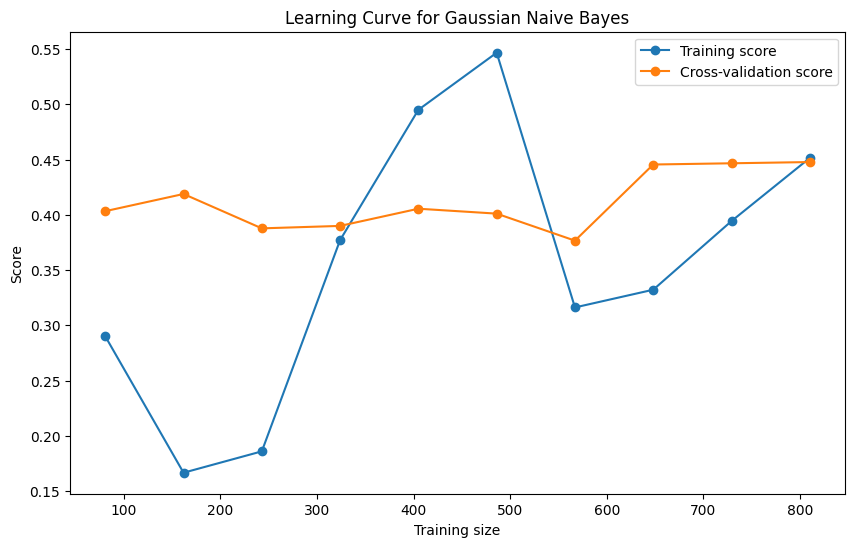

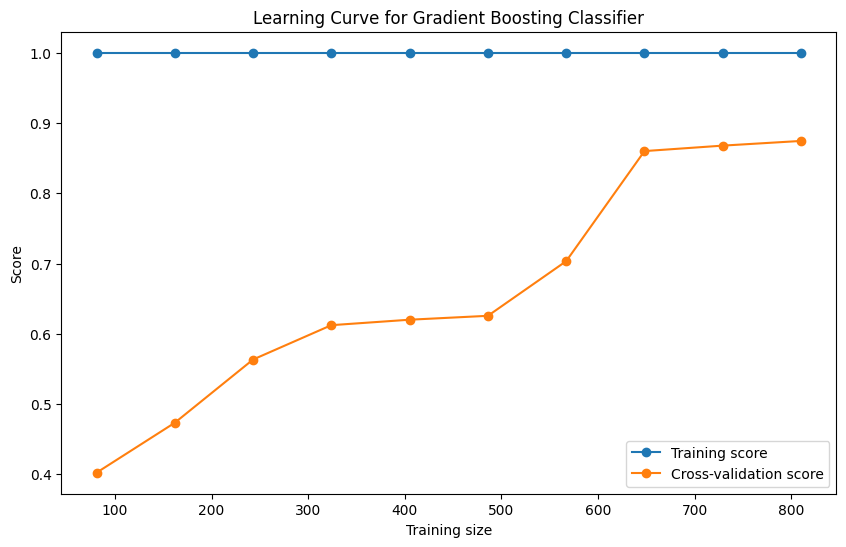

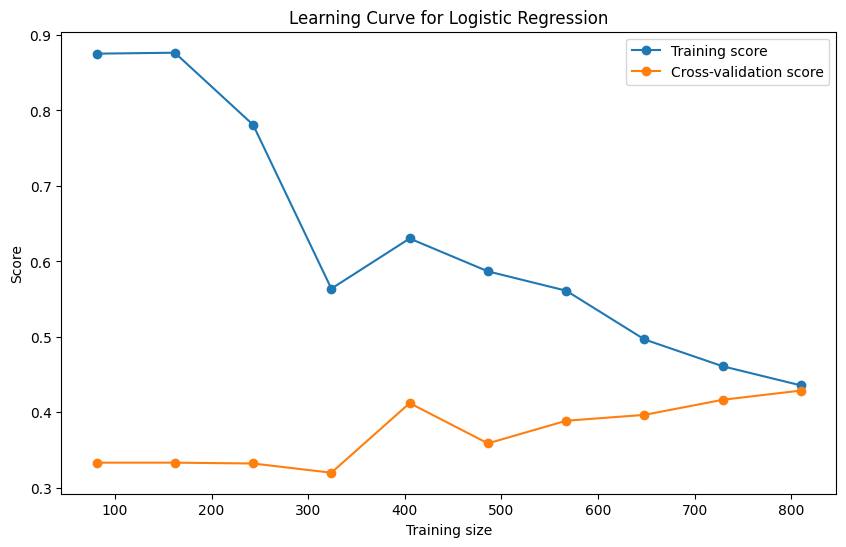

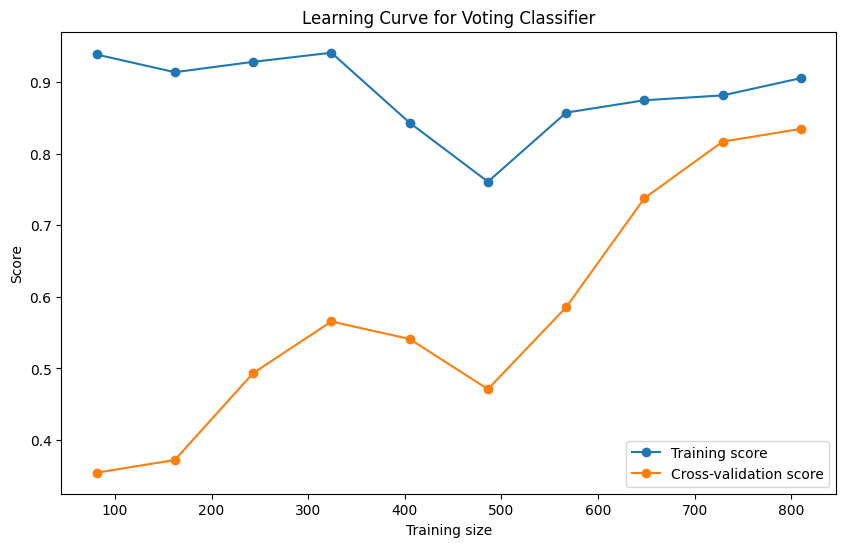

In [804]:
for name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X_smote, y_smote, cv=cv_num, scoring=metric, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    
    plt.title(f'Learning Curve for {name}')
    plt.xlabel('Training size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()

**Despues de analizar las curvas de aprendizaje de cada uno de los modelo, se opta por usar el modelo de Random Forest Classifier, pues este logro obtener un accuracy en las pruebas por encima del 80%, lo cual es bastante similar a su accuracy en las pruebas de entrenamiento, lo que indica una baja probabilidad de Overfiting. Asimismo, al realizar las pruebas con este modelo podemos corroborar que no tiene problemas para clasificar correctamente a aquellas monedas consideradas como "Estables". No obstante, en el caso de los grupos de "Oportunidad" y "Especulación" puede llegar a tener ciertos problemas, lo cual evidencia que en muchos casos aquellas monedas que suelen contar con un mayor porcentaje de ganancia, tambien pueden contar con una gran probabilidad de perdida**

In [805]:
#@title Descargamos el modelo
import joblib
#joblib.dump(voting_clf, 'voting.pkl')
##joblib.dump(GBC, 'GBC.pkl')
#joblib.dump(adaBoost, 'AdaBoost.pkl')
#joblib.dump(log_reg, 'LogisticRegression.pkl')
##joblib.dump(KNN, 'KNN.pkl')
#oblib.dump(SVM, 'SVM.pkl')

joblib.dump(clf, 'RandomForest.pkl')


['SVM.pkl']

In [806]:
# Cargar datos
df_model = pd.read_csv('cmcHistorical(2022-2024)(CleanV2).csv')
df_model['date'] = pd.to_datetime(df_model['date'])

# Definir fechas
baseDate = datetime(2024, 4, 15)
startDate = baseDate - timedelta(days=60)
endDate = baseDate + timedelta(days=60)

# Filtrar datos por rango de fechas
df_model = df_model[(df_model['date'] >= startDate) & (df_model['date'] <= endDate)]

# Filtrar criptomonedas con al menos 120 días de datos
cryptoList = df_model['symbol'].unique().tolist()
for c in cryptoList:
    symbol_data = df_model[df_model['symbol'] == c]
    if len(symbol_data) < 120:
        df_model.drop(symbol_data.index, inplace=True)
    elif len(symbol_data) > 120:
        df_model.drop(symbol_data.index[120:], inplace=True)
    #Calculamos el cum_max y drawdown y log_return
    df_model.loc[df_model['symbol'] == c, 'cum_max'] = symbol_data['close'].cummax()
    symbol_data = df_model[df_model['symbol'] == c]
    df_model.loc[df_model['symbol'] == c, 'drawdown'] = symbol_data['close'] / symbol_data['cum_max'] - 1
df_model["log_return"] = np.log(df_model['close'] / df_model['open'])
# Inicializar DataFrame para clasificación
dfClasTest = pd.DataFrame()
# Calcular características agregadas para cada criptomoneda
for c in cryptoList:
    symbol_data = df_model[df_model["symbol"] == c]
    if len(symbol_data) == 0:
        continue
    avg_volatility_daily = symbol_data['log_return'].std()
    total_volatility = avg_volatility_daily * np.sqrt(len(symbol_data))
    price_variation_multiplier = (symbol_data["close"].max() - symbol_data["close"].iloc[0]) / symbol_data["close"].iloc[0]
    avg_daily_market_cap = symbol_data["market_cap"].mean()
    max_drawdown = symbol_data["drawdown"].min()
    avg_volume_24h = symbol_data["volume_24h"].mean()
    
    dictCrypto = {
        "symbol": c,
        "total_volatility": total_volatility,
        "price_variation_multiplier": price_variation_multiplier,
        "avg_daily_market_cap": avg_daily_market_cap,
        "max_drawdown": max_drawdown,
        "avg_volume_24h": avg_volume_24h
    }
    dfClasTest = pd.concat([dfClasTest, pd.DataFrame(dictCrypto, index=[0])], axis=0)

dfClasTest.reset_index(drop=True, inplace=True)
dfClasTest

,symbol,total_volatility,price_variation_multiplier,avg_daily_market_cap,max_drawdown,avg_volume_24h
0,$MONG,0.927846,1.771146,1.188357e+07,-0.654694,2.869260e+06
1,$OPHX,1.084769,0.273076,3.402402e+06,-0.875315,2.446578e+05
2,0XDEV,1.616387,2.388453,2.839001e+06,-0.876223,1.347174e+06
3,0x0,0.848207,2.214189,2.705839e+08,-0.541083,1.683813e+06
4,0xBTC,1.587261,0.685026,8.808281e+05,-0.700886,1.193551e+05
...,...,...,...,...,...,...
2219,stTON,0.818517,3.898805,3.099484e+07,-0.409801,4.338409e+04
2220,stWEMIX,1.782707,0.775335,1.035996e+07,-0.708676,4.141448e+04
2221,vBNB,6.067479,95.723004,1.632319e+09,-0.983036,5.448476e+08
2222,wROSE,0.521808,0.460392,9.810469e+08,-0.547300,3.515742e+04


In [808]:
dfAux = dfClasTest[(dfClasTest["price_variation_multiplier"] > 0) & (dfClasTest["price_variation_multiplier"] < 15) 
                   & (dfClasTest["max_drawdown"]>-0.85) & (dfClasTest["avg_volume_24h"]>0)].copy()

In [813]:
#Cargar el modelo
dfAux.drop(columns=['type'],inplace=True)
calssifier = joblib.load('RandomForest.pkl')
X_test = dfAux.drop(columns=['symbol','price_variation_multiplier'])
scaler = MinMaxScaler(feature_range=(0, 1))
X_test_scaled = scaler.fit_transform(X_test)
y_pred_test = calssifier.predict(X_test_scaled)
dfAux['type'] = y_pred_test

In [814]:
dfAux["type"].value_counts(normalize=True)*100

type
Estable         79.436769
Especulativa    16.790648
Oportunidad      3.772582
Name: proportion, dtype: float64

In [815]:
dfAux[dfAux["type"]=="Oportunidad"]

,symbol,total_volatility,price_variation_multiplier,avg_daily_market_cap,max_drawdown,avg_volume_24h,type
4,0xBTC,1.587261,0.685026,8.808281e+05,-0.700886,1.193551e+05,Oportunidad
20,ABYSS,1.866332,0.341814,1.315674e+06,-0.709400,4.736083e+00,Oportunidad
30,ACX,0.751667,1.630742,3.907507e+07,-0.431493,7.367560e+05,Oportunidad
101,AOA,3.502615,2.029378,1.189883e+06,-0.683194,5.495583e+00,Oportunidad
142,ATA,0.934692,1.591058,8.284015e+07,-0.478890,1.198512e+07,Oportunidad
...,...,...,...,...,...,...,...
2103,XCASH,2.003136,0.289187,1.815131e+05,-0.582894,6.788742e+01,Oportunidad
2129,XNC,2.516398,2.600218,1.116191e+07,-0.792558,9.587821e+02,Oportunidad
2184,ZIK,2.706013,11.416985,1.679946e+06,-0.635926,1.018131e+04,Oportunidad
2190,ZNZ,2.142865,2.713085,1.140872e+05,-0.613346,4.596842e+01,Oportunidad


#### LSTM

In [824]:
df = pd.read_csv('ccHistorical_all(3th halving)(Clean).csv')
dfAux =pd.read_csv('Clustered_Cryptos.csv')
df['date'] = pd.to_datetime(df['date'])

In [825]:
df.drop(columns=['new_addresses','active_addresses','transaction_count','large_transaction_count','average_transaction_value',"circulating_supply"],inplace=True)
cryptos_with_zeros = df[(df['open'] == 0) | (df['close'] == 0) | (df['high'] == 0) | (df['low'] == 0)]['symbol'].unique()

# Eliminar esas criptomonedas del DataFrame
df = df[~df['symbol'].isin(cryptos_with_zeros)]
dfAux = dfAux[dfAux["type"] != "Volatil"]

dfAux = dfAux.groupby('type').head(9)
df = df[df['symbol'].isin(dfAux['symbol'].unique())]

In [826]:
cryptoList = df['symbol'].unique().tolist()
for c in cryptoList:
    symbol_data = df[df['symbol'] == c]
    if len(symbol_data) < 300:
        df.drop(symbol_data.index, inplace=True)
    elif len(symbol_data) > 300:
        df.drop(symbol_data.index[300:], inplace=True)

In [827]:
columns_to_scale_crypto = ['open', 'high', 'low', 'close', 'volume_24h', 'market_cap']
scalers = {symbol: {} for symbol in cryptoList}

for symbol in cryptoList:
    symbol_data = df[df['symbol'] == symbol]
    if len(symbol_data) > 0:  # Verifica si el DataFrame no está vacío
        for column in columns_to_scale_crypto:
            scaler = MinMaxScaler(feature_range=(0, 1))
            df.loc[df['symbol'] == symbol, column] = scaler.fit_transform(symbol_data[[column]])
            scalers[symbol][column] = scaler

In [828]:
pca = PCA(n_components=3)
pca_data = df[columns_to_scale_crypto].values
pca_result = pca.fit_transform(pca_data)

pca_columns = [f'pca_{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca_result, columns=pca_columns, index=df.index)
df = pd.concat([df, df_pca], axis=1)

In [829]:
volatility_scaler = MinMaxScaler(feature_range=(0, 1))
df['volatility'] = volatility_scaler.fit_transform(df[['volatility']])
df.reset_index(drop=True,inplace=True)


In [830]:

def create_sequences(data, features, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[features].iloc[i:i + n_steps].values)
        y.append(data['close'].iloc[i + n_steps])  # Aquí estamos prediciendo el cierre del próximo día
    return np.array(X), np.array(y)

# Lista de características a usar para crear secuencias
features = pca_columns + ['volatility']

# Crear secuencias por criptomoneda
data_dict = {}
n_steps = 60  # Usar 90 días de datos para predecir el próximo día

for symbol in cryptoList:
    symbol_data = df[df['symbol'] == symbol]
    X, y = create_sequences(symbol_data, features, n_steps)
    data_dict[symbol] = (X, y)


# Combinar todas las secuencias
train_test_data = {}

for symbol, (X, y) in data_dict.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_test_data[symbol] = (X_train, X_test, y_train, y_test)

In [835]:
# Definir una función para crear el modelo
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(n_steps, len(features)), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Incrementa la tasa de dropout
    model.add(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.003)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [836]:
# Entrenar un modelo para cada criptomoneda
models = {}
histories = {}

for symbol, (X_train, X_test, y_train, y_test) in train_test_data.items():
    model = create_model((n_steps, len(features)))
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
    models[symbol] = model
    histories[symbol] = history

Epoch 1/100


c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 4.2329 - val_loss: 2.9321
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.5471 - val_loss: 2.7999
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.2266 - val_loss: 2.6483
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.9670 - val_loss: 2.4907
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8273 - val_loss: 2.3278
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.6441 - val_loss: 2.1515
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.3694 - val_loss: 1.9956
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.1402 - val_loss: 1.8485
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.0423 - val_loss: 1.6903
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.8711 - val_loss: 1.5612
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.7263 - val_loss: 1.4578
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6104 - val_loss: 1.3404


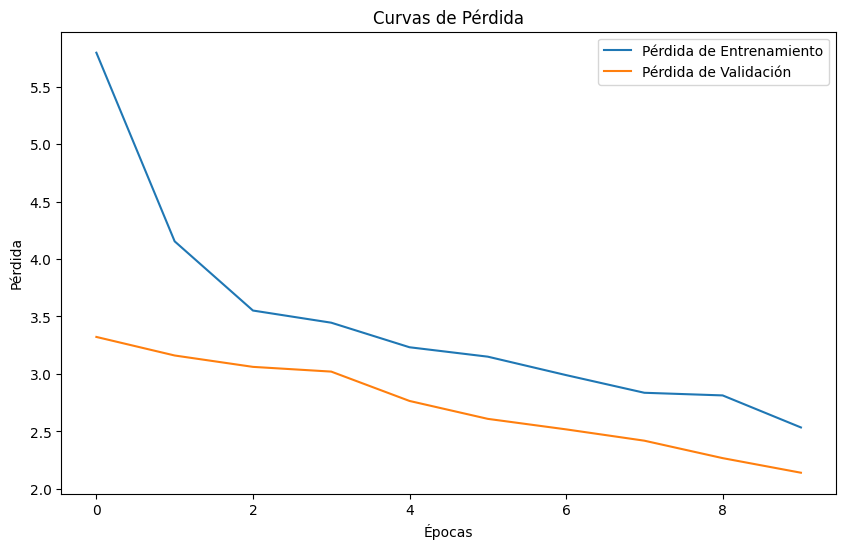

In [837]:
# Graficar las pérdidas de entrenamiento y validación
symbol = 'ADA'
history = histories[symbol]
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


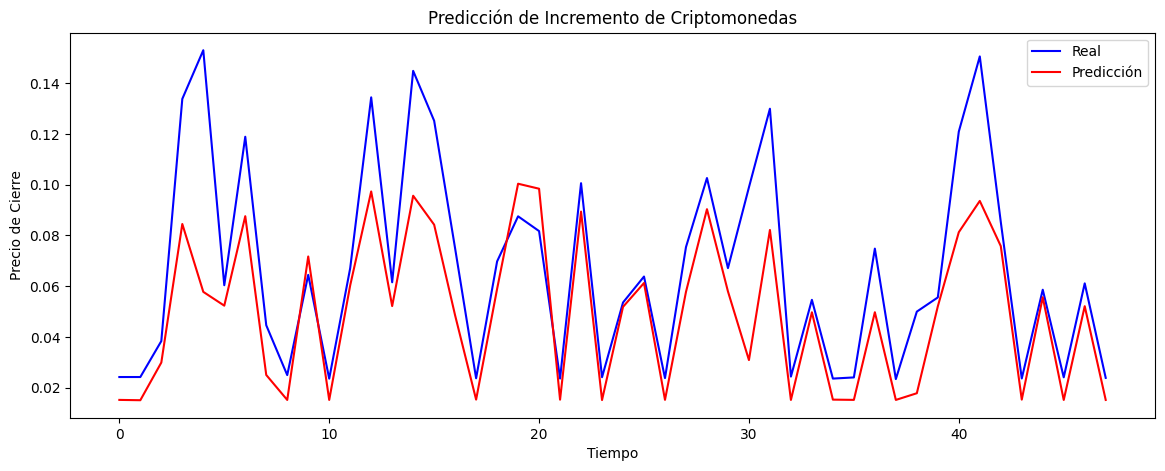

In [838]:
# Supongamos que 'scalers' es un diccionario que contiene los escaladores para cada criptomoneda
# y 'scalers[symbol]' es el escalador usado para 'BTC'
scaler = scalers[symbol]['close']

# Hacer predicciones
y_pred = model.predict(X_test)

# Invertir la normalización de las predicciones y valores reales
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Convertir los arrays de nuevo a 1D para graficar
y_test_inv = y_test_inv.flatten()
y_pred_inv = y_pred_inv.flatten()

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, color='blue', label='Real')
plt.plot(y_pred_inv, color='red', label='Predicción')
plt.title('Predicción de Incremento de Criptomonedas')
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [839]:
dfInicial = pd.read_csv('ccHistorical_all(3th halving)(Clean).csv')

In [840]:
value = dfInicial[dfInicial["symbol"] == symbol]["close"].iloc[0]

In [841]:
print(f"{symbol} podria tener un incremento del {((y_pred_inv.max()-value)/value)*100}% en el precio de cierre")

ADA podria tener un incremento del 105.44856686892892% en el precio de cierre


In [844]:
#Descargamos los modelos
model_dir = 'modelos_guardados'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Guardar cada modelo
for symbol in cryptoList:
    model_name = f'modelo_{symbol}.h5'
    model_path = os.path.join(model_dir, model_name)
    models[symbol].save(model_path)

In [845]:
scaler_dir = 'escaladores_guardados'
if not os.path.exists(scaler_dir):
    os.makedirs(scaler_dir)

# Guardar los escaladores en archivos separados para cada criptomoneda y cada columna
for symbol in scalers:
    for column in scalers[symbol]:
        scaler_name = f'scaler_{symbol}_{column}.pkl'
        scaler_path = os.path.join(scaler_dir, scaler_name)
        joblib.dump(scalers[symbol][column], scaler_path)